***Import Libararies***

In [1]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import plotly
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm

import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default parameters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

print(" All packages imported successfully!")

 All packages imported successfully!


***Figure Default Parameter***

In [2]:
sns.set_style("whitegrid")

#set default font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Tahoma']

#set default font size
small_size= 10
medium_size = 12
large_size = 14

#change font size for individual elements

matplotlib.rc('font', size=small_size)          # default text
matplotlib.rc('axes', titlesize=medium_size)    # axes title
matplotlib.rc('axes', labelsize=medium_size)    # x and y labels
matplotlib.rc('xtick', labelsize=small_size)    # x tick labels
matplotlib.rc('ytick', labelsize=small_size)    # y tick labels
matplotlib.rc('legend', fontsize=small_size)     # legend font size
matplotlib.rc('figure', titlesize=large_size)    # figure title



***Read DataFrame***

In [3]:
df = pd.read_csv('historic_demand_2009_2024.csv', index_col=0)
df.head(5)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0        1/1/2009                  1  37910  38704                 33939   
1        1/1/2009                  2  38047  38964                 34072   
2        1/1/2009                  3  37380  38651                 33615   
3        1/1/2009                  4  36426  37775                 32526   
4        1/1/2009                  5  35687  37298                 31877   

   embedded_wind_generation  embedded_wind_capacity  \
0                        54                    1403   
1                        53                    1403   
2                        53                    1403   
3                        50                    1403   
4                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                          0                        0            0  ...   
1                          0                        0            0  ...   
2                          0                        0            0  ...   
3                          0                        0            0  ...   
4                          0                        0            0  ...   

   ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
0          0             0        -161               0          0       NaN   
1          0             0        -160               0          0       NaN   
2          0             0        -160               0          0       NaN   
3          0             0        -160               0          0       NaN   
4          0             0        -160               0          0       NaN   

   eleclink_flow  scottish_transfer  viking_flow  greenlink_flow  
0            NaN                NaN          NaN             NaN  
1            NaN                NaN          NaN             NaN  
2            NaN                NaN          NaN             NaN  
3            NaN                NaN          NaN             NaN  
4            NaN                NaN          NaN             NaN  

[5 rows x 22 columns]

In [4]:
df.shape

(279264, 22)

In [5]:
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      279264.000000  279264.000000  279264.000000         279264.000000   
mean           24.500229   31186.565042   32627.843779          28389.002868   
std            13.853821    7827.270027    7710.008440           7087.628201   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.750000   24908.000000   26582.000000          22677.000000   
50%            24.500000   30495.000000   31782.000000          27756.000000   
75%            36.250000   36913.000000   38096.000000          33615.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             279264.000000           279264.000000   
mean                1270.098774             4447.695772   
std                  966.304596             1957.216235   
min                    0.000000             1403.000000   
25%                  551.000000             2102.000000   
50%                 1016.000000             4831.000000   
75%                 1726.000000             6527.000000   
max                 5930.000000             6622.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              279264.000000            279264.000000  279264.000000   
mean                  878.177069              8685.163430       6.654220   
std                  1709.142408              5875.188186      39.150778   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              2028.000000       0.000000   
50%                     0.000000             11503.000000       0.000000   
75%                   883.000000             13080.000000       0.000000   
max                 11224.000000             17197.000000     893.000000   

       pump_storage_pumping  ...      ifa2_flow   britned_flow     moyle_flow  \
count         279264.000000  ...  279264.000000  279264.000000  279264.000000   
mean             304.734674  ...      53.852140     503.999842    -125.610222   
std              528.372063  ...     353.722565     541.490053     230.333166   
min                0.000000  ...   -1030.000000   -1215.000000    -505.000000   
25%                8.000000  ...       0.000000       0.000000    -304.000000   
50%               11.000000  ...       0.000000     725.000000    -149.000000   
75%              368.000000  ...       0.000000     994.000000      24.000000   
max             2019.000000  ...    1016.000000    1143.000000     499.000000   

       east_west_flow      nemo_flow       nsl_flow  eleclink_flow  \
count   279264.000000  279264.000000  103968.000000  103968.000000   
mean       -50.967919     175.876626     416.582977     114.173929   
std        262.941668     421.668169     650.866003     490.431568   
min       -585.000000   -1023.000000   -1455.000000   -1028.000000   
25%       -208.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000     332.000000    1095.000000      75.000000   
max        504.000000    1033.000000    1401.000000    1002.000000   

       scottish_transfer   viking_flow  greenlink_flow  
count       33840.000000  33840.000000         16320.0  
mean         1704.910757    196.312145             0.0  
std          1825.530303    562.922278             0.0  
min         -2851.000000  -1465.000000             0.0  
25%           267.750000      0.000000             0.0  
50%          1543.000000      0.000000             0.0  
75%          3058.000000    512.000000             0.0  
max          6585.000000   1436.000000             0.0  

[8 rows x 21 columns]

In [6]:
df.sort_values(by=['settlement_date', 'settlement_period'], inplace=True)
df.reset_index(drop=True, inplace=True)

***Data Preparation***

In [7]:
df.isnull().sum()

settlement_date                   0
settlement_period                 0
nd                                0
tsd                               0
england_wales_demand              0
embedded_wind_generation          0
embedded_wind_capacity            0
embedded_solar_generation         0
embedded_solar_capacity           0
non_bm_stor                       0
pump_storage_pumping              0
ifa_flow                          0
ifa2_flow                         0
britned_flow                      0
moyle_flow                        0
east_west_flow                    0
nemo_flow                         0
nsl_flow                     175296
eleclink_flow                175296
scottish_transfer            245424
viking_flow                  245424
greenlink_flow               262944
dtype: int64

In [8]:
#drop columns with null values
df = df.dropna(axis=1)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

settlement_date              0
settlement_period            0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_wind_capacity       0
embedded_solar_generation    0
embedded_solar_capacity      0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
dtype: int64

In [9]:
df.shape

(279232, 17)

In [10]:
df.dtypes

settlement_date              object
settlement_period             int64
nd                            int64
tsd                           int64
england_wales_demand          int64
embedded_wind_generation      int64
embedded_wind_capacity        int64
embedded_solar_generation     int64
embedded_solar_capacity       int64
non_bm_stor                   int64
pump_storage_pumping          int64
ifa_flow                      int64
ifa2_flow                     int64
britned_flow                  int64
moyle_flow                    int64
east_west_flow                int64
nemo_flow                     int64
dtype: object

***Holiday***

In [11]:
#Compare England and Wales bank holidays with UK holidays
bank_holiday_england = holidays.UK(subdiv='England', years=range(2009, 2025), observed=True).items()
bank_holiday_wales = holidays.UK(subdiv='Wales', years=range(2009, 2025), observed=True).items()
print(bank_holiday_england==bank_holiday_wales)

True


In [12]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [13]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
84397       12/26/2023                 14  18483  23523                 16994   
85074       12/27/2022                 19  27059  27665                 24422   
246405       8/26/2013                  6  21145  23300                 19069   
83420       12/25/2017                 45  25483  26088                 22891   
96            1/1/2011                  1  34606  35648                 31058   
176823       5/27/2019                 24  23484  23998                 20221   
84508       12/27/2010                 29  42488  43547                 38089   

        embedded_wind_generation  embedded_wind_capacity  \
84397                       2443                    6488   
85074                       1810                    6545   
246405                       230                    2313   
83420                       2648                    5754   
96                           484                    1730   
176823                      1905                    6137   
84508                       1432                    2141   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
84397                           0                    15905            0   
85074                         333                    13861            0   
246405                          0                     2933            0   
83420                           0                    12916            0   
96                              0                       79            0   
176823                       5950                    13080            0   
84508                           2                       77            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
84397                   1194      -521         -5          -653        -390   
85074                      6      1005        992           805         326   
246405                  1359      1291          0           805           0   
83420                      5      1600          0           803         207   
96                        60      1939          0             0        -382   
176823                    14      1500          0           757          97   
84508                      9        16          0             0        -450   

        east_west_flow  nemo_flow  is_holiday  
84397             -531        348           1  
85074              321        988           1  
246405            -296          0           1  
83420              378          0           1  
96                   0          0           1  
176823             217        641           1  
84508                0          0           1

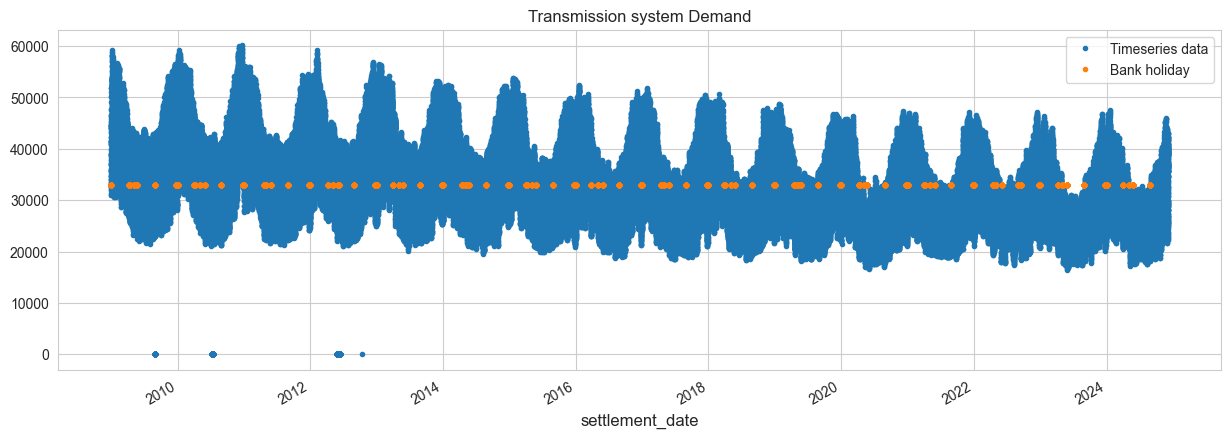

In [14]:
#inspect holiday using plot
df_plot = df.copy()
df_plot = df_plot.set_index('settlement_date')
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15,5))
df_plot['tsd'].plot(
    style='.', ax=ax, title='Transmission system Demand', 
    label='Timeseries data'
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)

ax.legend()

* This plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. Theis should be handled properly.

<Axes: title={'center': 'Transmission system Demand for first week of 2016'}, xlabel='settlement_date'>

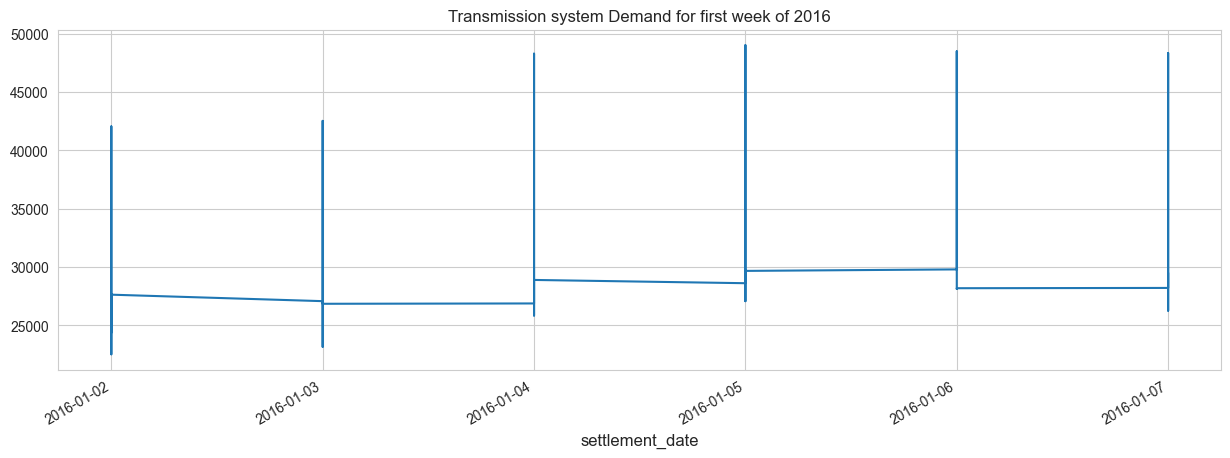

In [15]:
#create new plot for single week
df_plot.loc[(df_plot.index > '2016-01-01') & (df_plot.index < '2016-01-08'), 'tsd'].plot(figsize=(15,5), title='Transmission system Demand for first week of 2016')

* The plot was not expected. lets inspect the data

In [16]:
df_plot.head(5)

settlement_period     nd    tsd  england_wales_demand  \
settlement_date                                                          
2009-01-01                       1  37910  38704                 33939   
2009-01-01                       2  38047  38964                 34072   
2009-01-01                       3  37380  38651                 33615   
2009-01-01                       4  36426  37775                 32526   
2009-01-01                       5  35687  37298                 31877   

                 embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                     
2009-01-01                             54                    1403   
2009-01-01                             53                    1403   
2009-01-01                             53                    1403   
2009-01-01                             50                    1403   
2009-01-01                             50                    1403   

                 embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                       
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   

                 non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  \
settlement_date                                                           
2009-01-01                 0                    33      2002          0   
2009-01-01                 0                   157      2002          0   
2009-01-01                 0                   511      2002          0   
2009-01-01                 0                   589      1772          0   
2009-01-01                 0                   851      1753          0   

                 britned_flow  moyle_flow  east_west_flow  nemo_flow  \
settlement_date                                                        
2009-01-01                  0        -161               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   

                 is_holiday  
settlement_date              
2009-01-01                1  
2009-01-01                1  
2009-01-01                1  
2009-01-01                1  
2009-01-01                1

The plot wasn't wrong! In the process of setting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

***OutLier Analysis***

<Axes: xlabel='tsd', ylabel='Count'>

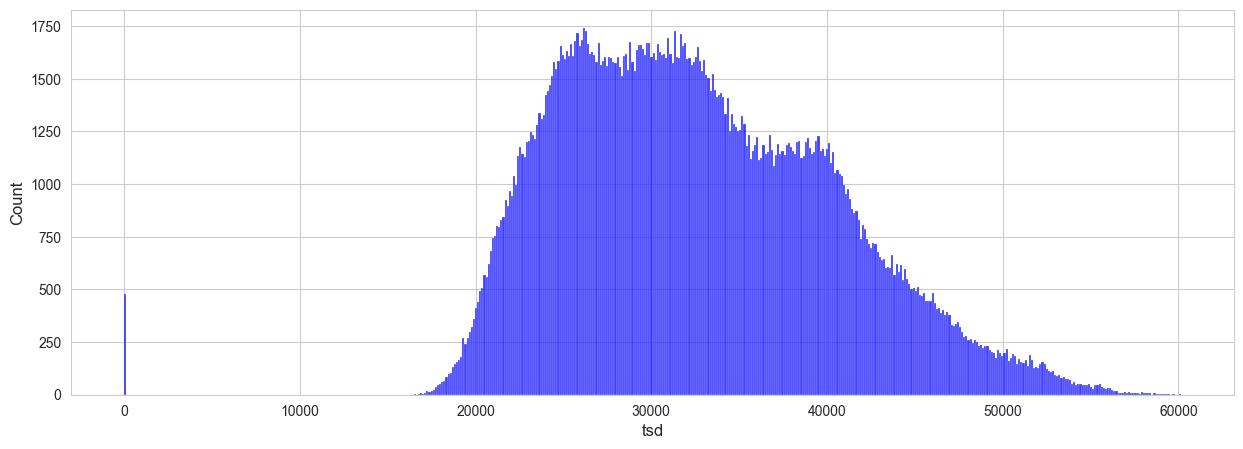

In [17]:
fig, ax = plt.subplots(figsize=(15,5))

sns.histplot(df_plot['tsd'], bins=500, ax=ax, color='Blue')

### Key insights this visualization provides:

* Outlier detection: Extreme values that appear as isolated bars far from the main distribution
* Data quality issues: Zero values or other anomalies that shouldn't exist in real demand data
* Distribution shape: Whether your demand data follows a normal distribution, is skewed, or has multiple peaks
* Data range: The minimum and maximum realistic values for transmission system demand

I will not only delete the values equal to 0 but the entire day where there are values equal to 0. The reason being that otherwise the remaining daily values would not be representative of the entire day, which becomes more relevant for the SARIMA models as I will be using daily data instead of hourly

In [18]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)



***Feature Creation***

In [19]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00

df["hour"] = df["settlement_period"].apply(lambda x: str(datetime.timedelta(hours=(x-1)*0.5)))

df.loc[df["hour"] == "1 day, 0:00:00", "hour"] = "00:00:00"

#move the new column third position
hour_col = df.pop("hour")
df.insert(2, "hour", hour_col)

df.head(48)


settlement_date  settlement_period      hour     nd    tsd  \
0         1/1/2009                  1   0:00:00  37910  38704   
1         1/1/2009                  2   0:30:00  38047  38964   
2         1/1/2009                  3   1:00:00  37380  38651   
3         1/1/2009                  4   1:30:00  36426  37775   
4         1/1/2009                  5   2:00:00  35687  37298   
5         1/1/2009                  6   2:30:00  35408  37135   
6         1/1/2009                  7   3:00:00  34322  36844   
7         1/1/2009                  8   3:30:00  33076  35678   
8         1/1/2009                  9   4:00:00  31970  34635   
9         1/1/2009                 10   4:30:00  31270  33934   
10        1/1/2009                 11   5:00:00  30726  33378   
11        1/1/2009                 12   5:30:00  30320  32915   
12        1/1/2009                 13   6:00:00  30429  32875   
13        1/1/2009                 14   6:30:00  30287  32720   
14        1/1/2009                 15   7:00:00  29650  31900   
15        1/1/2009                 16   7:30:00  28841  31055   
16        1/1/2009                 17   8:00:00  29007  31094   
17        1/1/2009                 18   8:30:00  29787  31440   
18        1/1/2009                 19   9:00:00  31362  32079   
19        1/1/2009                 20   9:30:00  33257  33926   
20        1/1/2009                 21  10:00:00  34932  35602   
21        1/1/2009                 22  10:30:00  36579  37312   
22        1/1/2009                 23  11:00:00  37967  38751   
23        1/1/2009                 24  11:30:00  39235  40013   
24        1/1/2009                 25  12:00:00  40204  41058   
25        1/1/2009                 26  12:30:00  40672  41457   
26        1/1/2009                 27  13:00:00  40806  41479   
27        1/1/2009                 28  13:30:00  40781  41450   
28        1/1/2009                 29  14:00:00  40758  41427   
29        1/1/2009                 30  14:30:00  40524  41189   
30        1/1/2009                 31  15:00:00  40796  41417   
31        1/1/2009                 32  15:30:00  41703  42332   
32        1/1/2009                 33  16:00:00  43527  44133   
33        1/1/2009                 34  16:30:00  45488  46096   
34        1/1/2009                 35  17:00:00  46028  46634   
35        1/1/2009                 36  17:30:00  45876  46515   
36        1/1/2009                 37  18:00:00  45195  45865   
37        1/1/2009                 38  18:30:00  44289  44965   
38        1/1/2009                 39  19:00:00  43784  44579   
39        1/1/2009                 40  19:30:00  42583  43425   
40        1/1/2009                 41  20:00:00  42181  43000   
41        1/1/2009                 42  20:30:00  40746  41596   
42        1/1/2009                 43  21:00:00  39961  40813   
43        1/1/2009                 44  21:30:00  38333  39182   
44        1/1/2009                 45  22:00:00  36951  37797   
45        1/1/2009                 46  22:30:00  35987  36781   
46        1/1/2009                 47  23:00:00  34769  36116   
47        1/1/2009                 48  23:30:00  33504  35379   

    england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                  33939                        54                    1403   
1                  34072                        53                    1403   
2                  33615                        53                    1403   
3                  32526                        50                    1403   
4                  31877                        50                    1403   
5                  31604                        43                    1403   
6                  30486                        43                    1403   
7                  29390                        56                    1403   
8                  28452                        56                    1403   
9                  27842             

In [20]:
#include hour in settlement date to create datetime feature
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["hour"])
)

df.sample(n=5)


settlement_date  settlement_period      hour     nd    tsd  \
154203 2013-04-28 05:30:00                 12   5:30:00  23072  24950   
240556 2016-08-02 06:00:00                 13   6:00:00  23405  24781   
3107   2009-01-13 17:30:00                 36  17:30:00  54617  55289   
219077 2015-07-22 18:30:00                 38  18:30:00  33899  34508   
62454  2015-11-27 03:00:00                  7   3:00:00  25065  27698   

        england_wales_demand  embedded_wind_generation  \
154203                 20959                       748   
240556                 21239                       766   
3107                   49391                       266   
219077                 31065                      1085   
62454                  23255                      2008   

        embedded_wind_capacity  embedded_solar_generation  \
154203                    2085                         15   
240556                    4253                        142   
3107                      1403                          0   
219077                    3897                       1440   
62454                     4013                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
154203                     2658            0                  1038      1487   
240556                    10500            0                   876      1850   
3107                          0            0                     7      1055   
219077                     8747            0                    12      1998   
62454                      9049            0                  1531      -502   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
154203          0          -280         -60               0          0   
240556          0           934           0             381          0   
3107            0             0         -65               0          0   
219077          0          1021         -13             -84          0   
62454           0           998         170             262          0   

        is_holiday  
154203           0  
240556           0  
3107             0  
219077           0  
62454            0

* The settlement_date column is now in the right format to use an index:

<Axes: xlabel='settlement_date', ylabel='Electricity demand (MW)'>

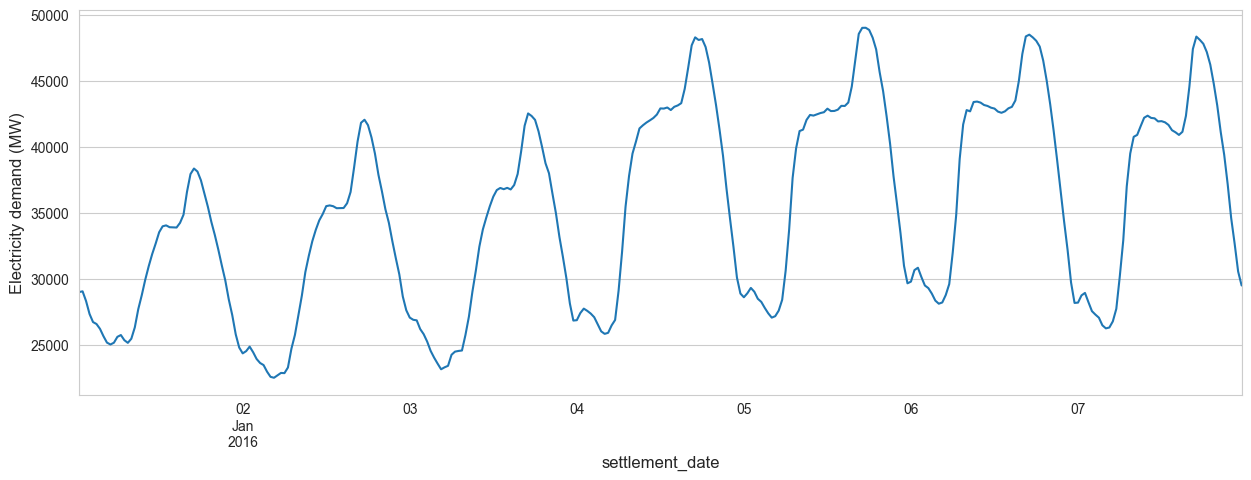

In [21]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
)

In [22]:
# create addtional datetime features from index
def create_datetime_features(df):
    """
    Create datetime features from settlement_date index.
    """
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

def add_lag_features(df):
    """
    Add three lags to the dataset containing information from 
    the previous 3 years.
    """
    target_map = df['tsd'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta(days=364)).map(target_map)  # Lag of 1 year
    df['lag2'] = (df.index - pd.Timedelta(days=728)).map(target_map)  # Lag of 2 years
    df['lag3'] = (df.index - pd.Timedelta(days=1092)).map(target_map)  # Lag of 3 years
    return df

In [23]:
df = create_datetime_features(df)
df = add_lag_features(df)

df.sample(n=5)

settlement_period      hour     nd    tsd  \
settlement_date                                                  
2018-11-19 08:30:00                 18   8:30:00  38647  40181   
2022-12-25 00:30:00                  2   0:30:00  19946  23553   
2011-06-29 08:30:00                 18   8:30:00  37402  38306   
2014-05-11 14:00:00                 29  14:00:00  30433  31563   
2016-12-06 01:30:00                  4   1:30:00  30317  33848   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2018-11-19 08:30:00                 34750                      2130   
2022-12-25 00:30:00                 18897                      2655   
2011-06-29 08:30:00                 33973                       238   
2014-05-11 14:00:00                 27656                      1048   
2016-12-06 01:30:00                 27400                       540   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2018-11-19 08:30:00                    5911                        251   
2022-12-25 00:30:00                    6545                          0   
2011-06-29 08:30:00                    1822                         54   
2014-05-11 14:00:00                    2523                       2240   
2016-12-06 01:30:00                    5113                          0   

                     embedded_solar_capacity  non_bm_stor  ...  is_holiday  \
settlement_date                                            ...               
2018-11-19 08:30:00                    13052            0  ...           0   
2022-12-25 00:30:00                    13861            0  ...           1   
2011-06-29 08:30:00                      435            0  ...           0   
2014-05-11 14:00:00                     4688            0  ...           0   
2016-12-06 01:30:00                    11503            0  ...           0   

                     dayofmonth  dayofweek  quarter  month  year  weekofyear  \
settlement_date                                                                
2018-11-19 08:30:00          19          0        4     11  2018          47   
2022-12-25 00:30:00          25          6        4     12  2022          51   
2011-06-29 08:30:00          29          2        2      6  2011          26   
2014-05-11 14:00:00          11          6        2      5  2014          19   
2016-12-06 01:30:00           6          1        4     12  2016          49   

                        lag1     lag2     lag3  
settlement_date                                 
2018-11-19 08:30:00  41539.0  42455.0  44991.0  
2022-12-25 00:30:00  25132.0  23832.0  24825.0  
2011-06-29 08:30:00  39188.0  40868.0      NaN  
2014-05-11 14:00:00  33663.0  32567.0  33994.0  
2016-12-06 01:30:00  26439.0  33653.0  34106.0  

[5 rows x 27 columns]

***Feature Understanding***

C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\3587353518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='settlement_period', y='tsd', data=df, ax=ax, palette='Set3')


Text(0.5, 1.0, 'Distribution of Electricity Demand by Hour of Day')

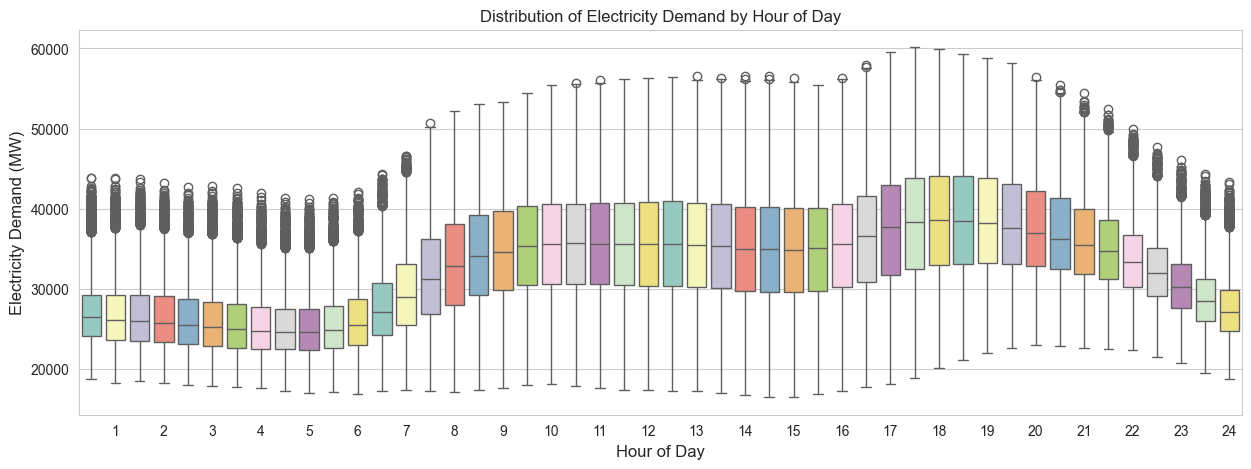

In [24]:
#distribution of electricity consumption with hours

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='settlement_period', y='tsd', data=df, ax=ax, palette='Set3')
ax.set_xticks(range(1,49,2))
ax.set_xticklabels(range(1,25))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Distribution of Electricity Demand by Hour of Day')

C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\1464885939.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='tsd', data=df, ax=ax, palette='Set3')


Text(0.5, 1.0, 'Distribution of Electricity Demand by Month')

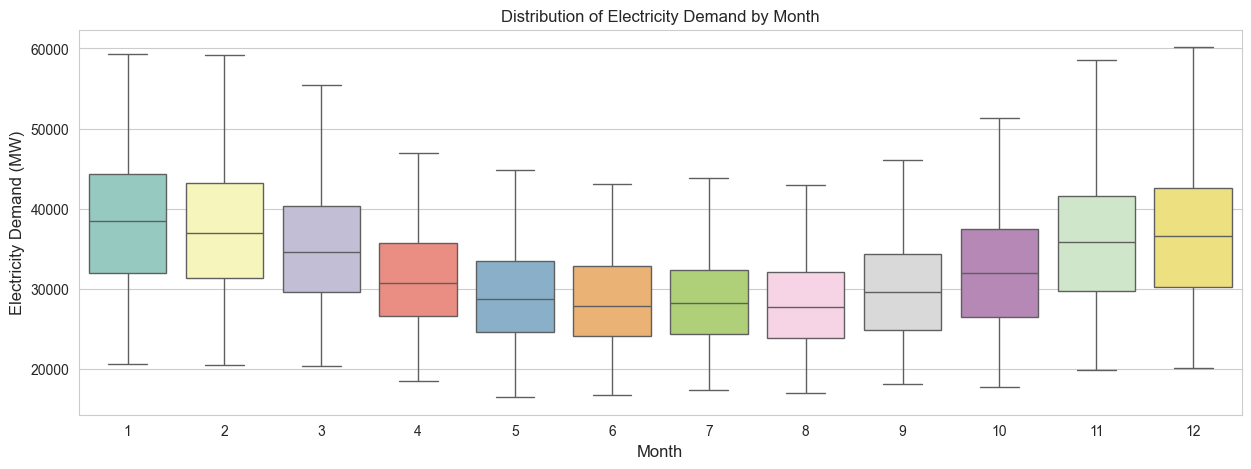

In [25]:
# Distribution of electricity demand (tsd) by month
fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(x='month', y='tsd', data=df, ax=ax, palette='Set3')
ax.set_xlabel('Month')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Distribution of Electricity Demand by Month')


* Plot Electricity consumption is lower in summer and higher in winter due to a combination of climate, heating habits, and energy infrastructure. Here's a breakdown of the key reasons:
    1. Heating Demand in Winter: Most homes in the UK and Europe use electric or gas heating.
    In winter, daylight hours are shorter and temperatures drop, leading to increased use of electric heaters, boilers, and heat pumps.
    Heating is the largest single use of energy in households during winter.
    2. Cooling Demand in Summer is Lower: Unlike countries with hot climates (like the US or India), air conditioning is not widely used in the UK and much of Europe.
    Summers are generally mild, so there's less need for cooling, resulting in lower electricity usage.
    3. Lighting and Daylight Hours: Winter has shorter days, so people use more artificial lighting.
    In summer, long daylight hours reduce the need for lighting, especially in northern Europe where it can stay light until 10 PM or later.
    4. Industrial and Commercial Patterns: Some industries may slow down during summer holidays, especially in August in parts of Europe.
    This can lead to a dip in electricity demand from the commercial sector.
    5. Behavioral and Cultural Factors: People tend to stay indoors more in winter, using more appliances, entertainment systems, and heating.
    In summer, people are outdoors more, reducing household electricity use.

C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\639429876.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


Text(0.5, 1.0, 'Distribution of Electricity Demand by Day of Week')

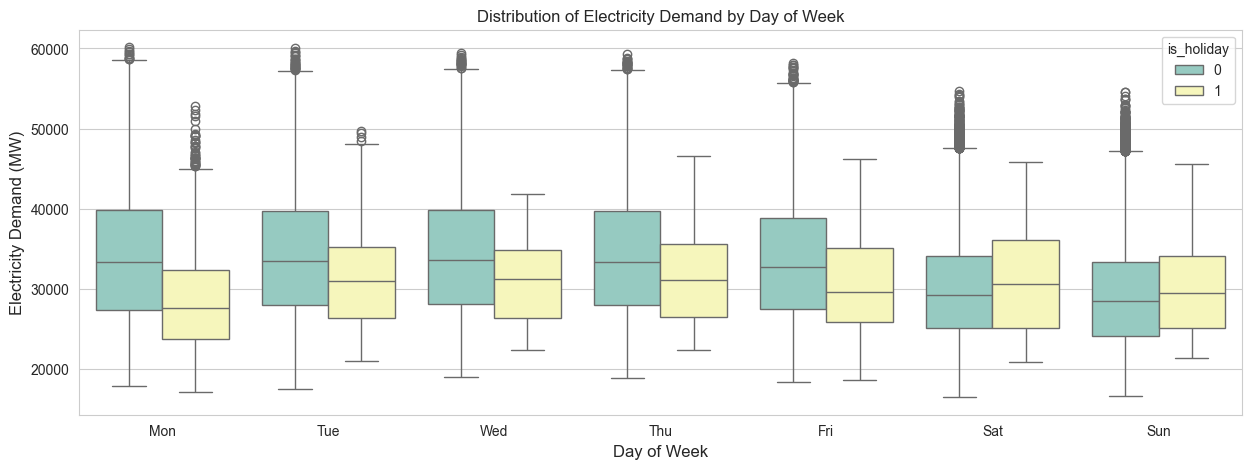

In [26]:
# daily distribution of electricity demand on holiday and non-holiday

fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(x='dayofweek', y='tsd', hue='is_holiday', data=df, ax=ax, palette='Set3')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Distribution of Electricity Demand by Day of Week')

It seems that from Mondat to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

Text(0.5, 1.0, 'Distribution of Electricity Demand by Year')

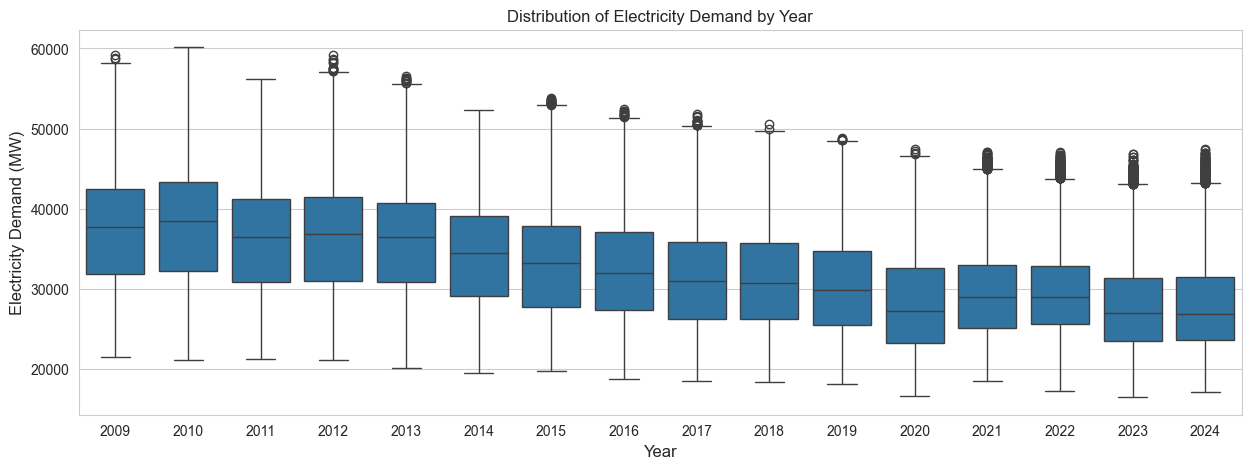

In [27]:
# distribution of electricity demand by year

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='year', y='tsd', data=df, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Distribution of Electricity Demand by Year')

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

Text(0.5, 1.0, 'Demand comparison - 2014 and 2024')

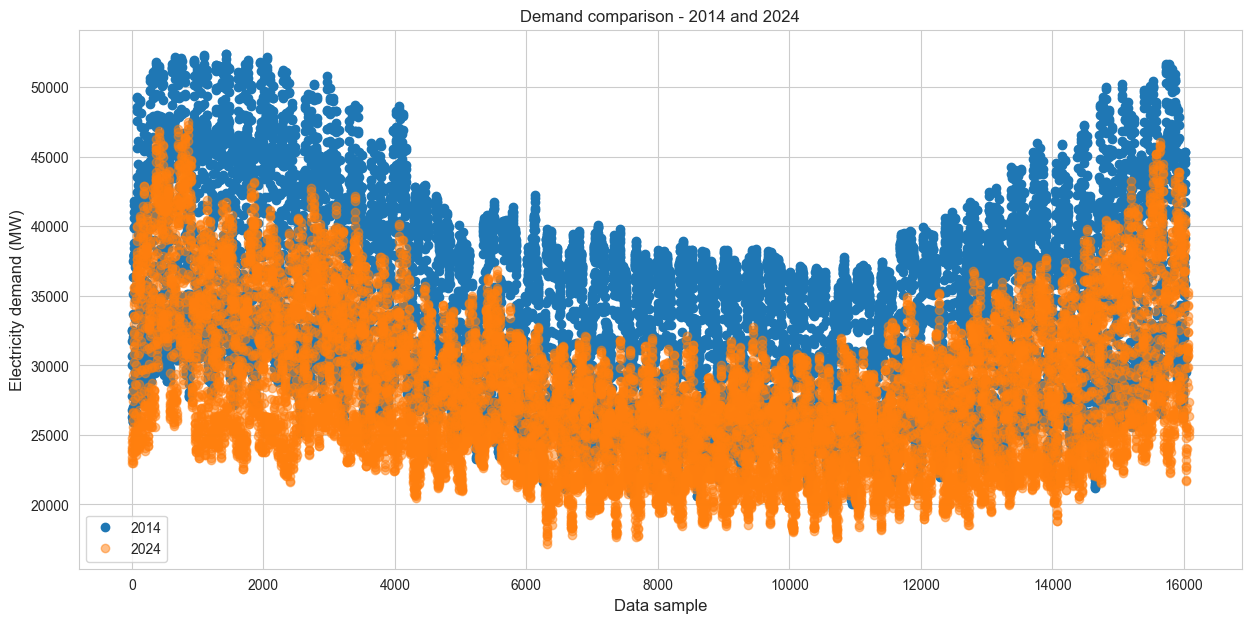

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2014") & (df.index < "12-01-2014")]["tsd"])),
    df.loc[(df.index > "01-01-2014") & (df.index < "12-01-2014")]["tsd"],
    "o",
    label="2014",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2024") & (df.index < "12-01-2024")]["tsd"])),
    df.loc[(df.index > "01-01-2024") & (df.index < "12-01-2024")]["tsd"],
    "o",
    alpha=0.5,
    label="2024",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2014 and 2024")

This plot also confirms that electricity consumption is decreasing in recent years

**Time-series Modeling**

In [29]:
df.sample(n=5)

settlement_period      hour     nd    tsd  \
settlement_date                                                  
2022-05-19 12:00:00                 25  12:00:00  24989  29002   
2017-03-16 00:30:00                  2   0:30:00  26132  28145   
2019-09-15 14:30:00                 30  14:30:00  24053  24803   
2011-05-04 17:00:00                 35  17:00:00  39512  40797   
2021-07-05 16:30:00                 34  16:30:00  30608  32025   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2022-05-19 12:00:00                 23022                      1700   
2017-03-16 00:30:00                 24020                      1438   
2019-09-15 14:30:00                 21839                      1489   
2011-05-04 17:00:00                 35800                       516   
2021-07-05 16:30:00                 27846                      1138   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2022-05-19 12:00:00                    6545                       7704   
2017-03-16 00:30:00                    4831                          0   
2019-09-15 14:30:00                    6182                       4510   
2011-05-04 17:00:00                    1786                         44   
2021-07-05 16:30:00                    6527                       2420   

                     embedded_solar_capacity  non_bm_stor  ...  is_holiday  \
settlement_date                                            ...               
2022-05-19 12:00:00                    13841            0  ...           0   
2017-03-16 00:30:00                    11750            0  ...           0   
2019-09-15 14:30:00                    13080            0  ...           0   
2011-05-04 17:00:00                      158            0  ...           0   
2021-07-05 16:30:00                    13080            0  ...           0   

                     dayofmonth  dayofweek  quarter  month  year  weekofyear  \
settlement_date                                                                
2022-05-19 12:00:00          19          3        2      5  2022          20   
2017-03-16 00:30:00          16          3        1      3  2017          11   
2019-09-15 14:30:00          15          6        3      9  2019          37   
2011-05-04 17:00:00           4          2        2      5  2011          18   
2021-07-05 16:30:00           5          0        3      7  2021          27   

                        lag1     lag2     lag3  
settlement_date                                 
2022-05-19 12:00:00  32577.0  22781.0  28083.0  
2017-03-16 00:30:00  30992.0  32602.0  29369.0  
2019-09-15 14:30:00  25093.0  27807.0  26819.0  
2011-05-04 17:00:00  43558.0  41978.0      NaN  
2021-07-05 16:30:00  25327.0  31735.0  33029.0  

[5 rows x 27 columns]

In [30]:
df_sarima = df['tsd'].resample('D').sum().to_frame()
df_sarima.head(5)

tsd
settlement_date         
2009-01-01       1849363
2009-01-02       1974406
2009-01-03       1952054
2009-01-04       1968670
2009-01-05       2271471

In [31]:
df_sarima['month'] = df_sarima.index.month
df_sarima['year'] = df_sarima.index.year
df_sarima.sample(n=5)

tsd  month  year
settlement_date                      
2014-01-13       1987237      1  2014
2017-01-08       1672348      1  2017
2021-01-07       1862268      1  2021
2015-09-20       1351613      9  2015
2015-02-08       1768137      2  2015

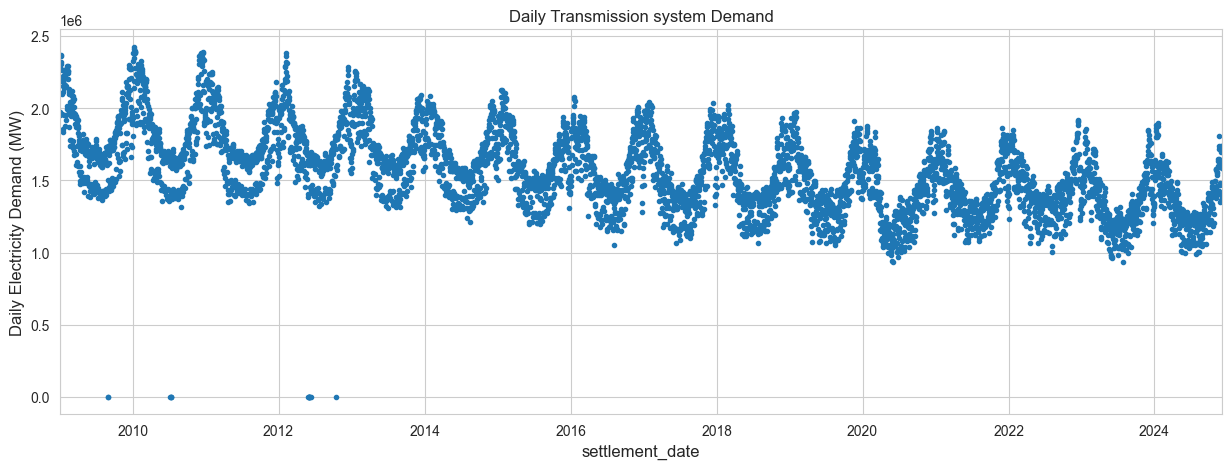

In [32]:
#plot daily electricity demand
fig, ax = plt.subplots(figsize=(15,5))

df_sarima['tsd'].plot(
    style='.', ax=ax, title='Daily Transmission system Demand', 
    label='Timeseries data',
    ylabel='Daily Electricity Demand (MW)'
)

plt.show()

* Re-sampling the data using a daily frequency leads to pandas creating days which I removed atleast one null again and assigning a value equal to 0. I will replace those values using the mean monthly value for that year.

In [33]:
#replace the days with 0 electricity demand with mean monthly value for that year
for year in df_sarima['year'].unique():
    for month in df_sarima['month'].unique():
        mean_value = df_sarima.loc[
            (df_sarima['year'] == year) & 
            (df_sarima['month'] == month) & 
            (df_sarima['tsd'] != 0), 'tsd'
        ].mean()
        
        df_sarima.loc[
            (df_sarima['year'] == year) & 
            (df_sarima['month'] == month) & 
            (df_sarima['tsd'] == 0), 'tsd'
        ] = mean_value


C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\2592392068.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2119400.64516129' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sarima.loc[


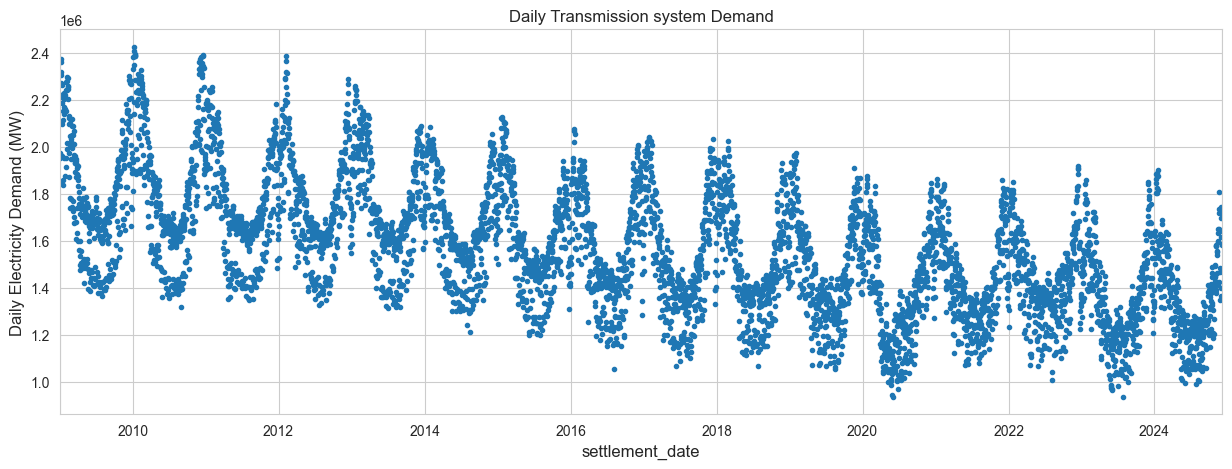

In [34]:
fig, ax = plt.subplots(figsize=(15,5))

df_sarima['tsd'].plot(
    style='.', ax=ax, title='Daily Transmission system Demand', 
    label='Timeseries data',
    ylabel='Daily Electricity Demand (MW)'
)

plt.show()

In [35]:
#compute lag values for oneday and one year:
df_sarima['lag_day'] = df_sarima['tsd'].shift(1)
df_sarima['lag_year'] = df_sarima['tsd'].shift(364)

#compute lag difference
df_sarima['difference_day'] = df_sarima['tsd'] - df_sarima['lag_day']
df_sarima['difference_year'] = df_sarima['tsd'] - df_sarima['lag_year']

df_sarima.sample(n=5)



tsd  month  year    lag_day   lag_year  difference_day  \
settlement_date                                                                 
2019-09-03       1319374.0      9  2019  1269441.0  1454421.0         49933.0   
2016-09-07       1525315.0      9  2016  1518748.0  1551480.0          6567.0   
2015-04-23       1591093.0      4  2015  1582073.0  1673675.0          9020.0   
2011-06-27       1702550.0      6  2011  1417376.0  1644784.0        285174.0   
2009-03-10       2087295.0      3  2009  2010629.0        NaN         76666.0   

                 difference_year  
settlement_date                   
2019-09-03             -135047.0  
2016-09-07              -26165.0  
2015-04-23              -82582.0  
2011-06-27               57766.0  
2009-03-10                   NaN

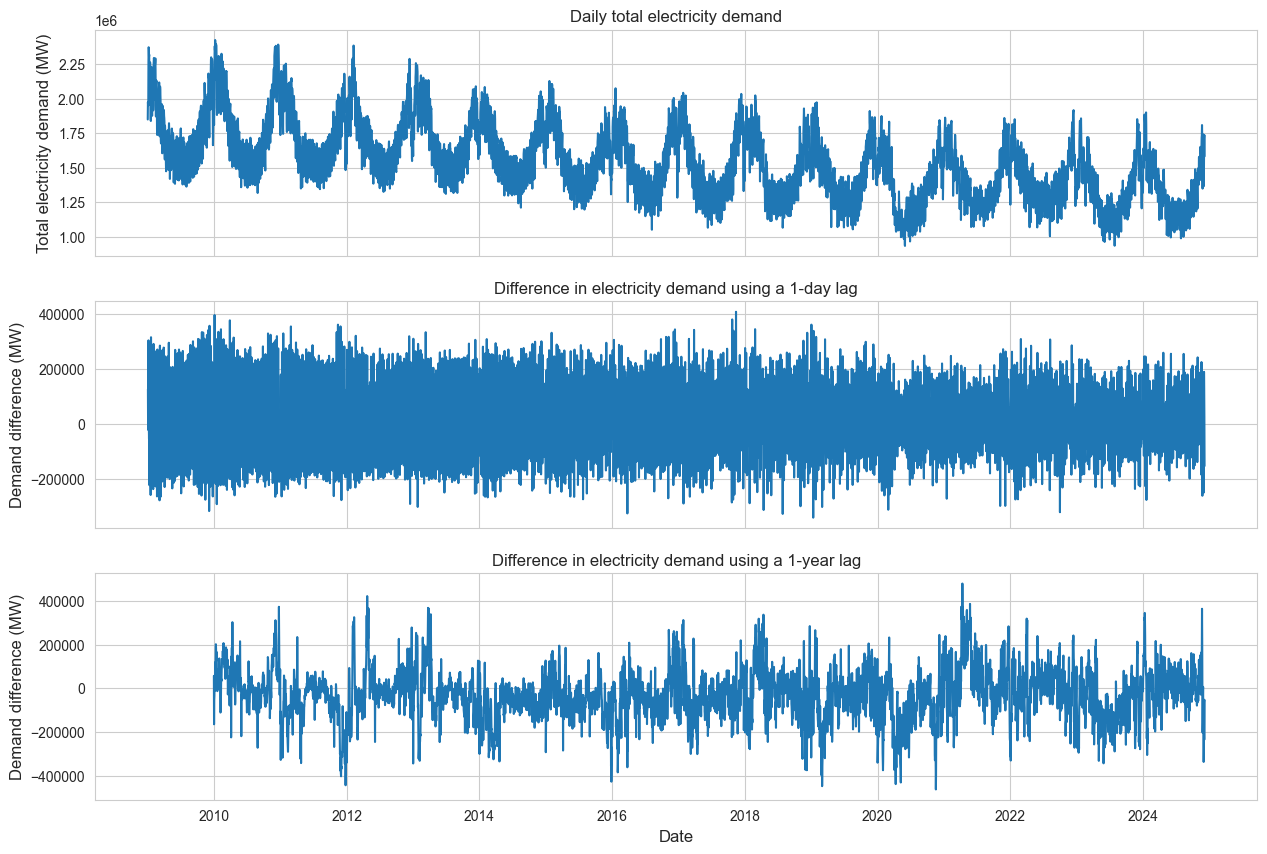

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag")

plt.show()

Top Panel - Original Time Series
The clear seasonal patterns you see indicate strong positive autocorrelation at seasonal lags:

Weekly cycles: Higher demand on weekdays, lower on weekends shows 7-day autocorrelation
Annual cycles: Winter peaks and summer troughs indicate 365-day autocorrelation
Overall trend: The decreasing trend from 2009-2024 shows persistence (positive autocorrelation at short lags)
Middle Panel - Daily Differencing (1-day lag)
This shows how first differencing affects autocorrelation:

Reduced trend: The differencing removes the long-term trend, reducing autocorrelation at long lags
Remaining seasonality: You still see seasonal patterns, indicating autocorrelation at seasonal frequencies hasn't been fully removed
Increased volatility: More noise suggests the differencing may have introduced negative autocorrelation at lag-1
Bottom Panel - Seasonal Differencing (1-year lag)
This reveals seasonal autocorrelation structure:

More stationary appearance: Seasonal differencing removes annual cycles, reducing autocorrelation at 365-day intervals
Remaining short-term patterns: Weekly and daily patterns may still show autocorrelation
Variance changes over time: Different volatility periods suggest time-varying autocorrelation

What this means for SARIMA modeling:
* Based on these patterns, you might need:
* SARIMA(p,d,q)(P,D,Q)s where:
     - d=1 (first differencing needed, as shown in middle panel)
     - D=1 (seasonal differencing needed, as shown in bottom panel)  
     - s=7 or s=365 (seasonal periods - weekly or yearly)
     - P,Q > 0 (seasonal AR/MA terms needed due to remaining patterns)

In [37]:
#Test Stationarity of series
from statsmodels.tsa.stattools import adfuller

def adf_test(series, window_size):
    """
    Perform Augmented Dickey-Fuller test to check stationarity of the series. 
    report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    adf_test = sm.stattools.adfuller(series,)
    adf_output = pd.Series(adf_test[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Value ({})'.format(key)] = value
        print(adf_output)


    #determine rolling statistics
    rolling_mean = series.rolling(window=window_size).mean()
    rolling_std = series.rolling(window=window_size).std()

    #plot rolling statistics
    plt.figure(figsize=(15,5))
    orig = plt.plot(series, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show(block=False)

Test Statistic                   -3.643797
p-value                           0.004977
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
dtype: float64
Test Statistic                   -3.643797
p-value                           0.004977
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
Critical Value (5%)              -2.862040
dtype: float64
Test Statistic                   -3.643797
p-value                           0.004977
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
Critical Value (5%)              -2.862040
Critical Value (10%)             -2.567036
dtype: float64


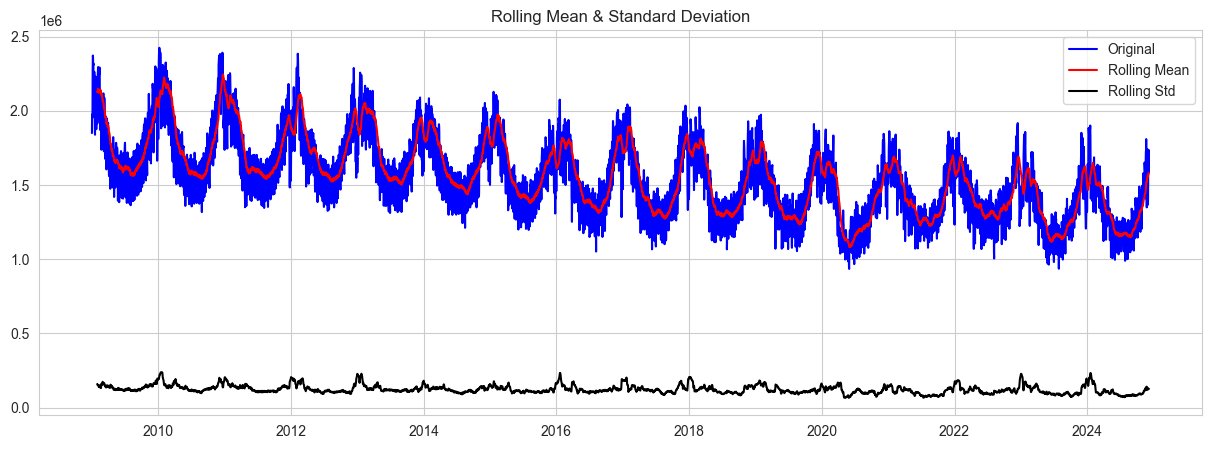

In [38]:
adf_test(df_sarima['tsd'], window_size=30)

* Test Statistic: More negative values indicate stronger evidence against the null hypothesis
* p < 0.05: Reject null hypothesis → Series is stationary
* statistic < critical value (more negative), reject null hypothesis.

But we can see that it doesn't meet requirements of a stationarity, as the series shows seasonality and decreasing trend.

Test Statistic                -1.538719e+01
p-value                        3.346877e-28
#Lags Used                     3.400000e+01
Number of Observations Used    5.782000e+03
Critical Value (1%)           -3.431481e+00
dtype: float64
Test Statistic                -1.538719e+01
p-value                        3.346877e-28
#Lags Used                     3.400000e+01
Number of Observations Used    5.782000e+03
Critical Value (1%)           -3.431481e+00
Critical Value (5%)           -2.862040e+00
dtype: float64
Test Statistic                -1.538719e+01
p-value                        3.346877e-28
#Lags Used                     3.400000e+01
Number of Observations Used    5.782000e+03
Critical Value (1%)           -3.431481e+00
Critical Value (5%)           -2.862040e+00
Critical Value (10%)          -2.567036e+00
dtype: float64


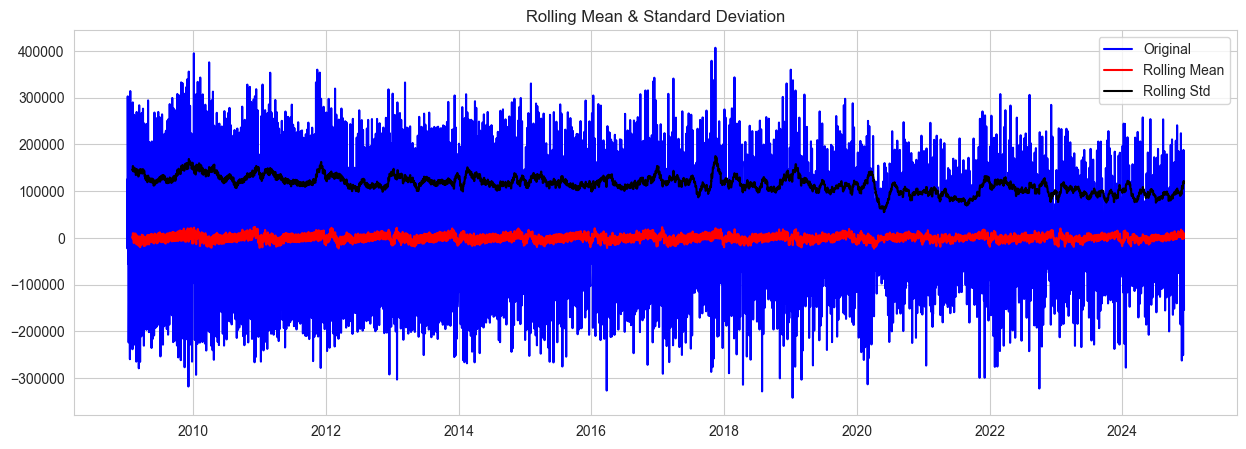

In [39]:
# let look for one day differencing data
adf_test(df_sarima['difference_day'].dropna(), window_size=30)

* Since the data now statiionary, we can use d=1 in the model.

* To determine D, we need to isolate the seasonal component of the series. To do so, the first step is to decompose the series, which is straightforward since the series is additive



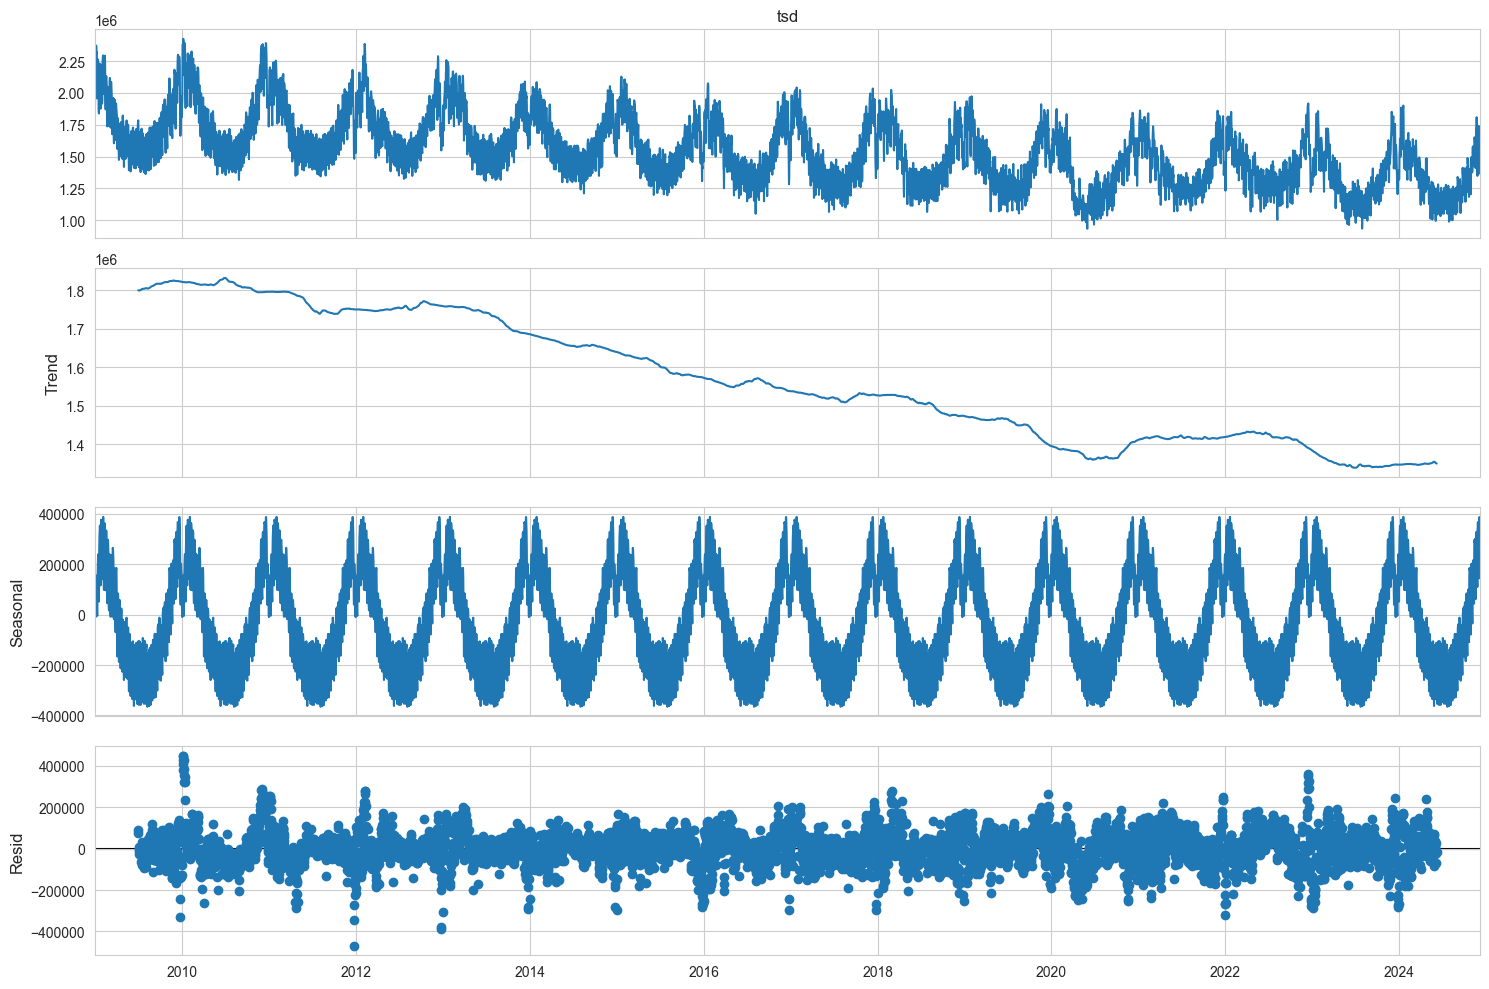

In [40]:
decompose = sm.seasonal_decompose(df_sarima['tsd'].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches(15, 10)
fig.tight_layout()
plt.show()

Test Statistic                   -4.891961
p-value                           0.000036
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
dtype: float64
Test Statistic                   -4.891961
p-value                           0.000036
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
Critical Value (5%)              -2.862040
dtype: float64
Test Statistic                   -4.891961
p-value                           0.000036
#Lags Used                       34.000000
Number of Observations Used    5783.000000
Critical Value (1%)              -3.431481
Critical Value (5%)              -2.862040
Critical Value (10%)             -2.567036
dtype: float64


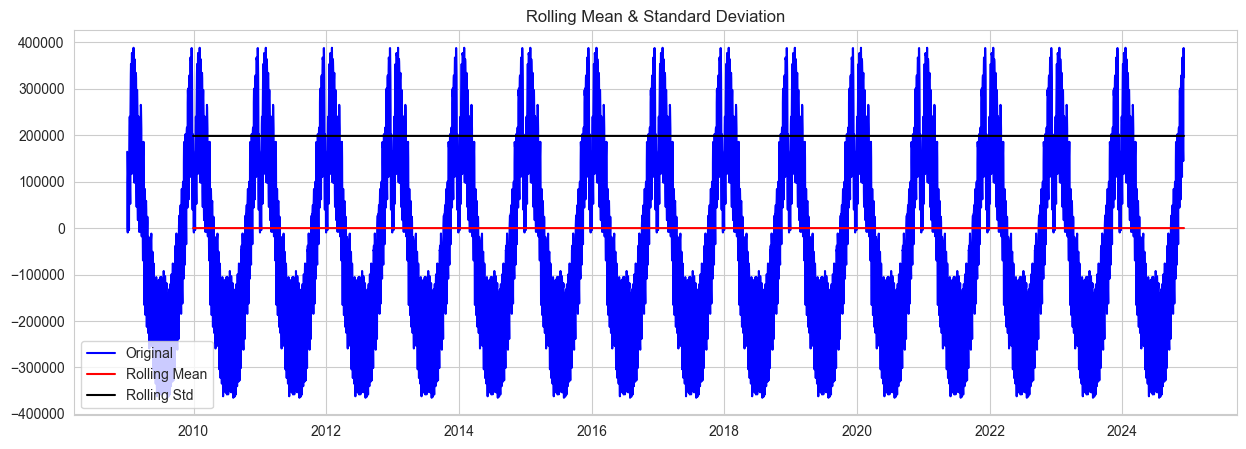

In [41]:
#test stationarity of decompose
adf_test(decompose.seasonal, 364)

* Similarly to the first ADF test, the test results suggest that the data is stationary, but since this is seasonal data, it is by definition non-stationary. Let's look at the 1-year lag data:

Test Statistic                -8.179517e+00
p-value                        8.203117e-13
#Lags Used                     2.600000e+01
Number of Observations Used    5.427000e+03
Critical Value (1%)           -3.431556e+00
dtype: float64
Test Statistic                -8.179517e+00
p-value                        8.203117e-13
#Lags Used                     2.600000e+01
Number of Observations Used    5.427000e+03
Critical Value (1%)           -3.431556e+00
Critical Value (5%)           -2.862073e+00
dtype: float64
Test Statistic                -8.179517e+00
p-value                        8.203117e-13
#Lags Used                     2.600000e+01
Number of Observations Used    5.427000e+03
Critical Value (1%)           -3.431556e+00
Critical Value (5%)           -2.862073e+00
Critical Value (10%)          -2.567054e+00
dtype: float64


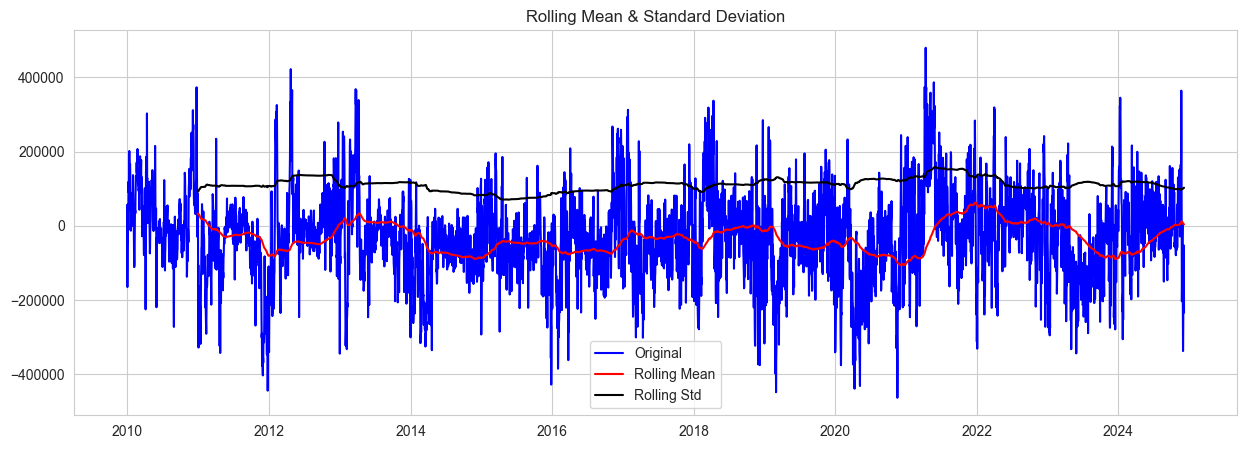

In [42]:
adf_test(df_sarima["difference_year"].dropna(), 364)

* sinnce 1 year differenced data is stationary D=1.

* To determine p and q, we have to analyze autocorrelation plot of the original data.

In [43]:
def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


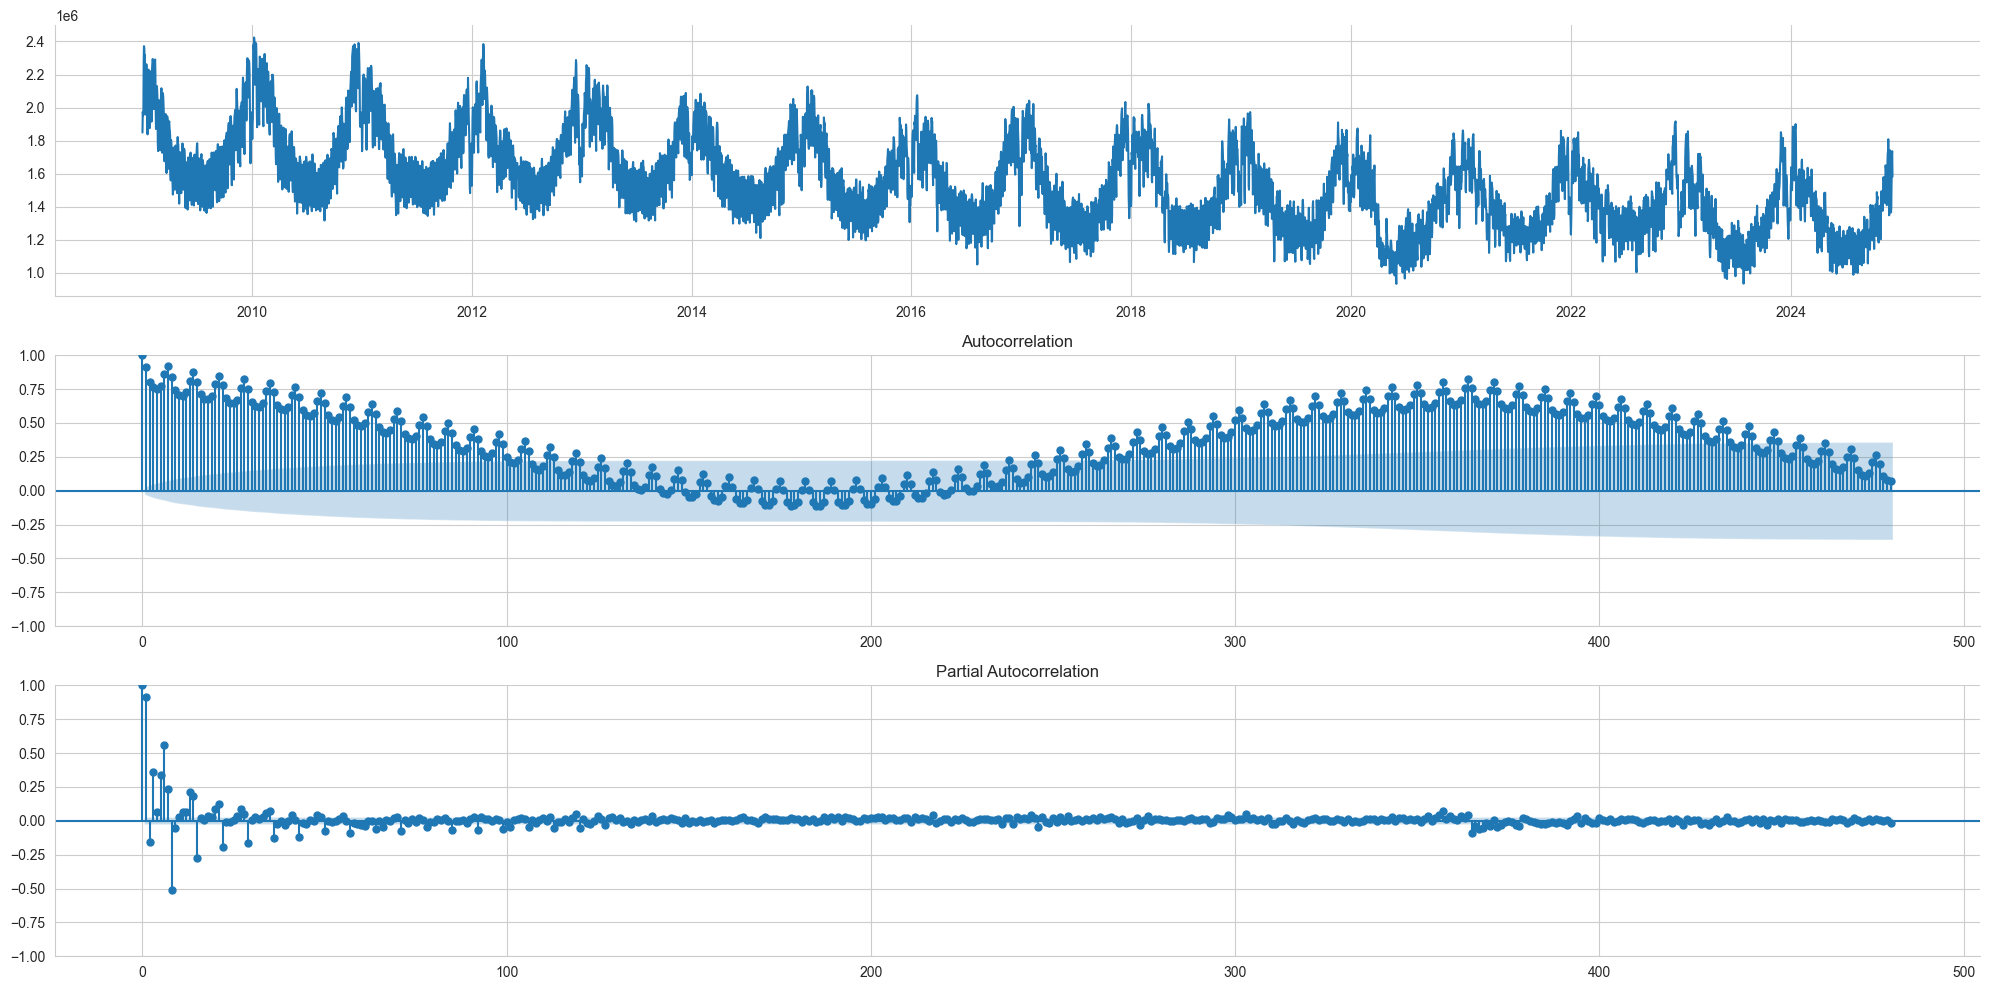

In [44]:
autocorr_plots(df_sarima['tsd'], lags=480)

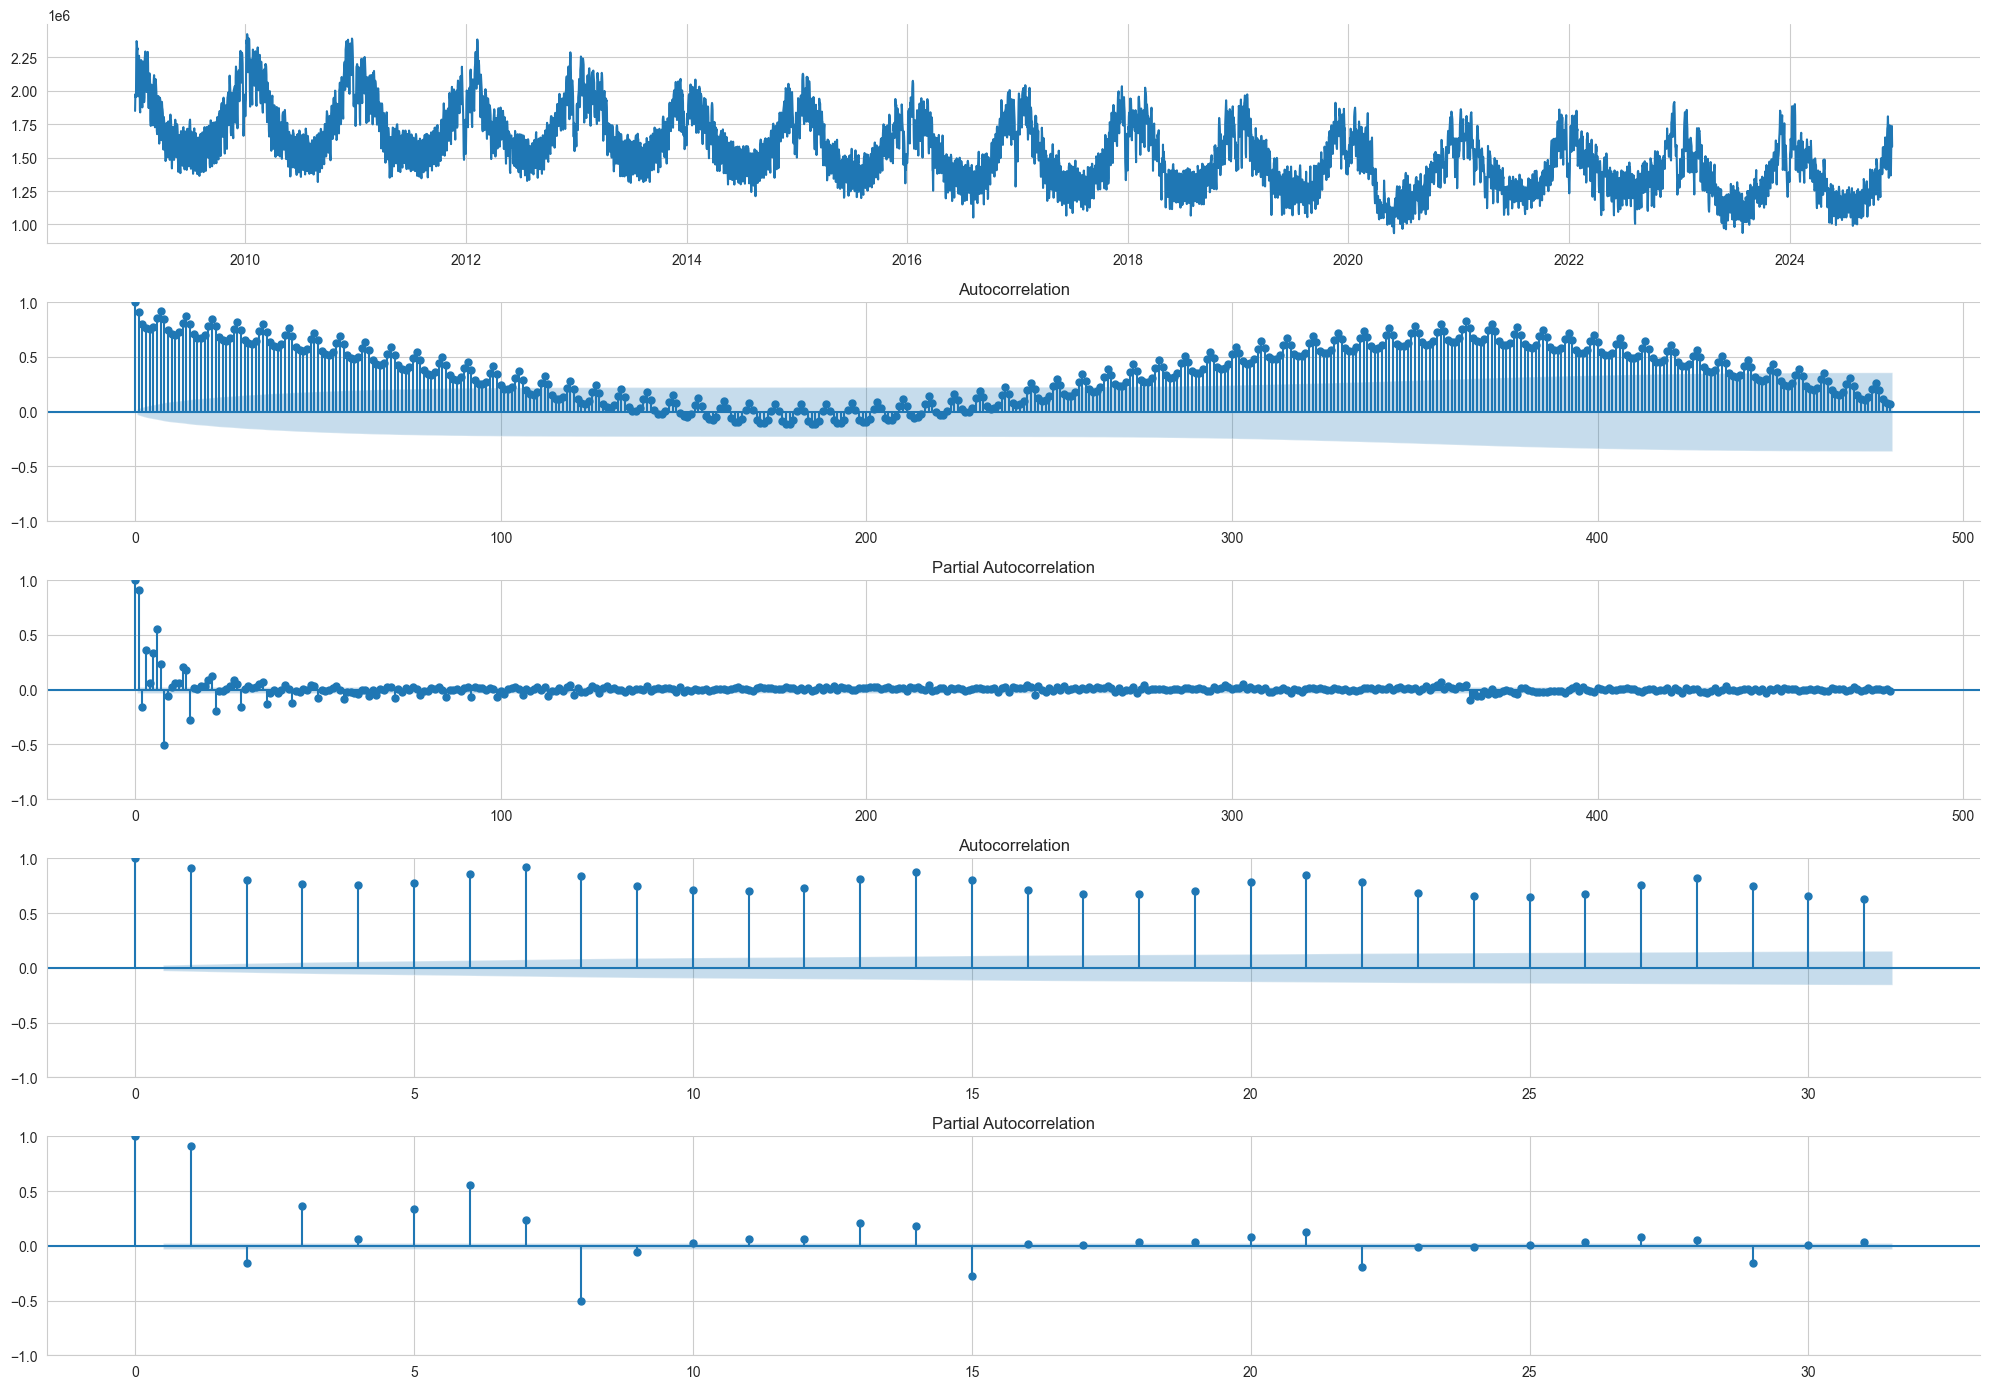

In [45]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

* Train test split

In [46]:
threshold_date = "01-01-2022"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

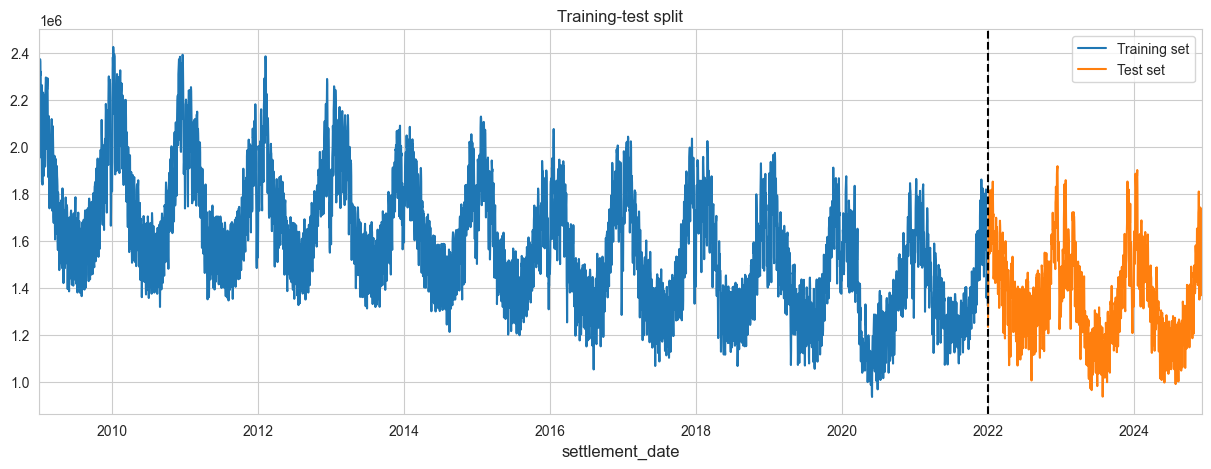

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend()
plt.show()

In [48]:
def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))

In [49]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [50]:
'''def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2022", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model'''

'def create_predict_analyse(\n    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag\n):\n    """\n    Create SARIMA model and perform the following actions:\n        - Perform statisticals tests to check if the model parameters are right\n        - Plot model diagnostics\n        - Predict on test data\n        - Compute MAPE\n        - Plot test data, prediction and confidence interval\n\n    Args:\n        - timeseries: time series data\n        - order: SARIMA order parameters\n        - seasonal_order: SARIMA seasonal order parameters\n        - max_iter: maximum number of iterations to compute SARIMA values\n        - lags: number of lags used for model diagnostics\n        - test_data: test data\n        - disp_flag: boolean variable to display SARIMA model iterations\n\n    Returns:\n        - execution_time: SARIMA model runtime\n        - mape: MAPE on test data\n        - sarima_model: SARIMA model created using the function arguments\n    """\n\n    # C

In [51]:
def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # FIX: Use forecast instead of get_prediction for out-of-sample prediction
    n_periods = len(test_data)
    forecast_result = sarima_model.forecast(steps=n_periods)
    confidence_int = sarima_model.get_forecast(steps=n_periods).conf_int()
    
    # Create prediction series with correct index
    prediction = pd.Series(forecast_result, index=test_data.index)

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)
    
    print(f"Test data shape: {test_data.shape}")
    print(f"Prediction shape: {prediction.shape}")
    print(f"MAPE: {mape:.2f}%")

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(test_data.index, test_data.values, label="Test data", color='blue')
    ax.plot(prediction.index, prediction.values, label="Prediction", color='red')
    ax.fill_between(
        confidence_int.index,
        confidence_int.iloc[:, 0],  # Lower bound
        confidence_int.iloc[:, 1],  # Upper bound
        alpha=0.3,
        color='red'
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return execution_time, mape, sarima_model

### Base Model (p,d,q)->(1,0,1); (P,D,Q,s)->(1,0,1,12) ###

Normality: val=1193.008, p=0.000
Ljung-Box: val=7748.401, p=0.000
Heteroskedasticity: val=0.825, p=0.000
Durbin-Watson: d=2.03
-------------------------------------------------------------
Test data shape: (1070,)
Prediction shape: (1070,)
MAPE: 38.21%


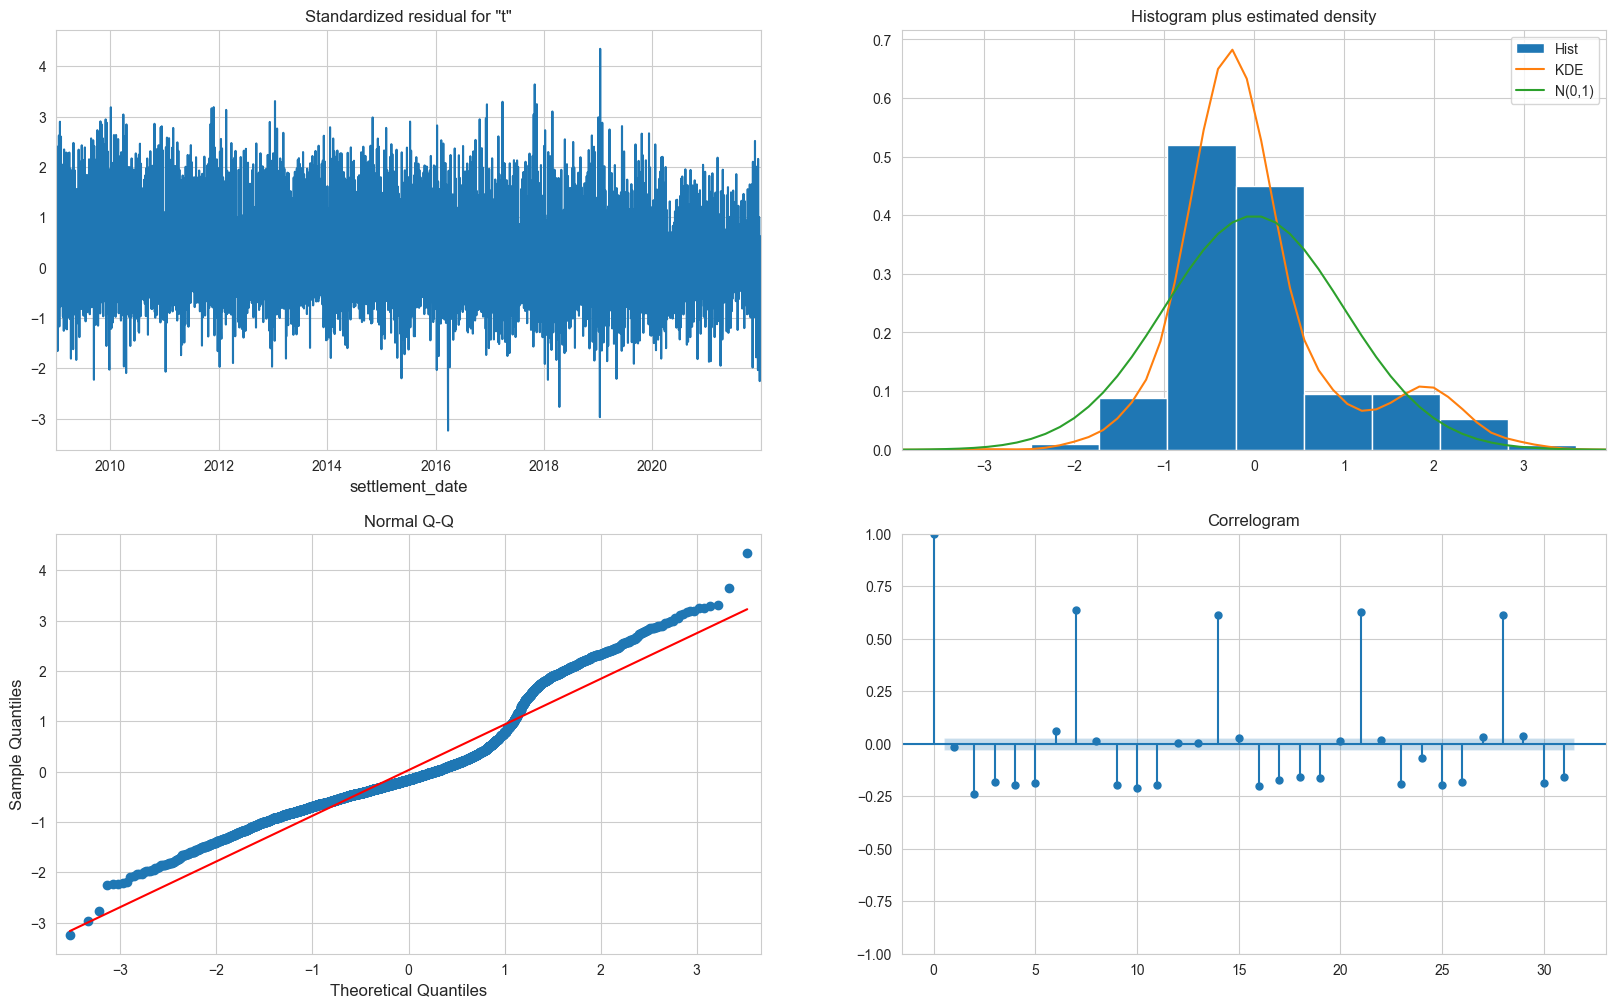

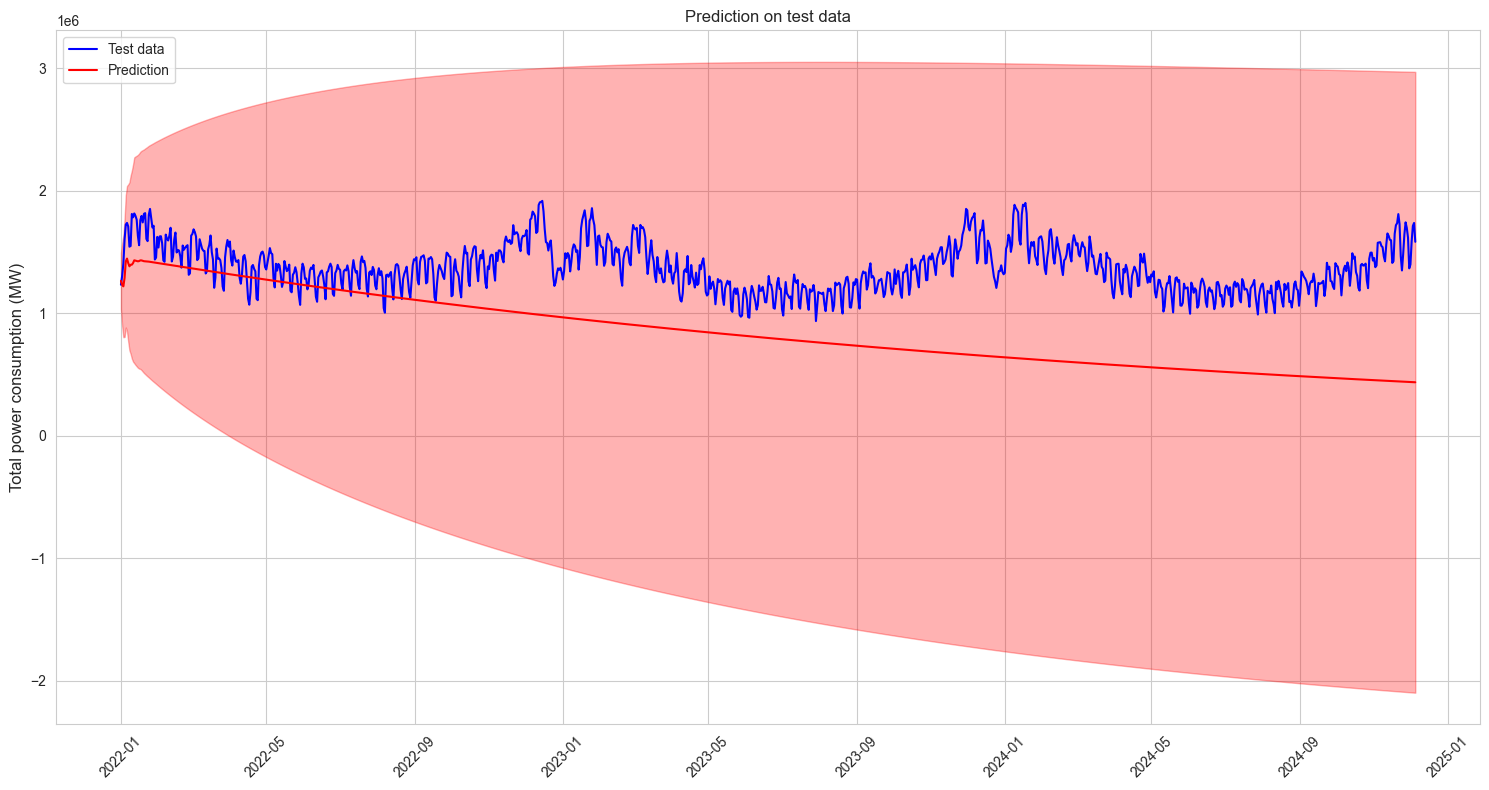

In [52]:
#def create_predict_analyse(
'''timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag)'''
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

In [53]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")


Model 0 MAPE value: 38.2126983358879
Model 0 runtime: 0:00:06.548256


### Model-1 (p,d,q)->(1,1,1); (P,D,Q,s)->(1,1,1,7) ###

Normality: val=3549.570, p=0.000
Ljung-Box: val=116.366, p=0.000
Heteroskedasticity: val=1.175, p=0.001
Durbin-Watson: d=1.99
-------------------------------------------------------------
Test data shape: (1070,)
Prediction shape: (1070,)
MAPE: 10.26%


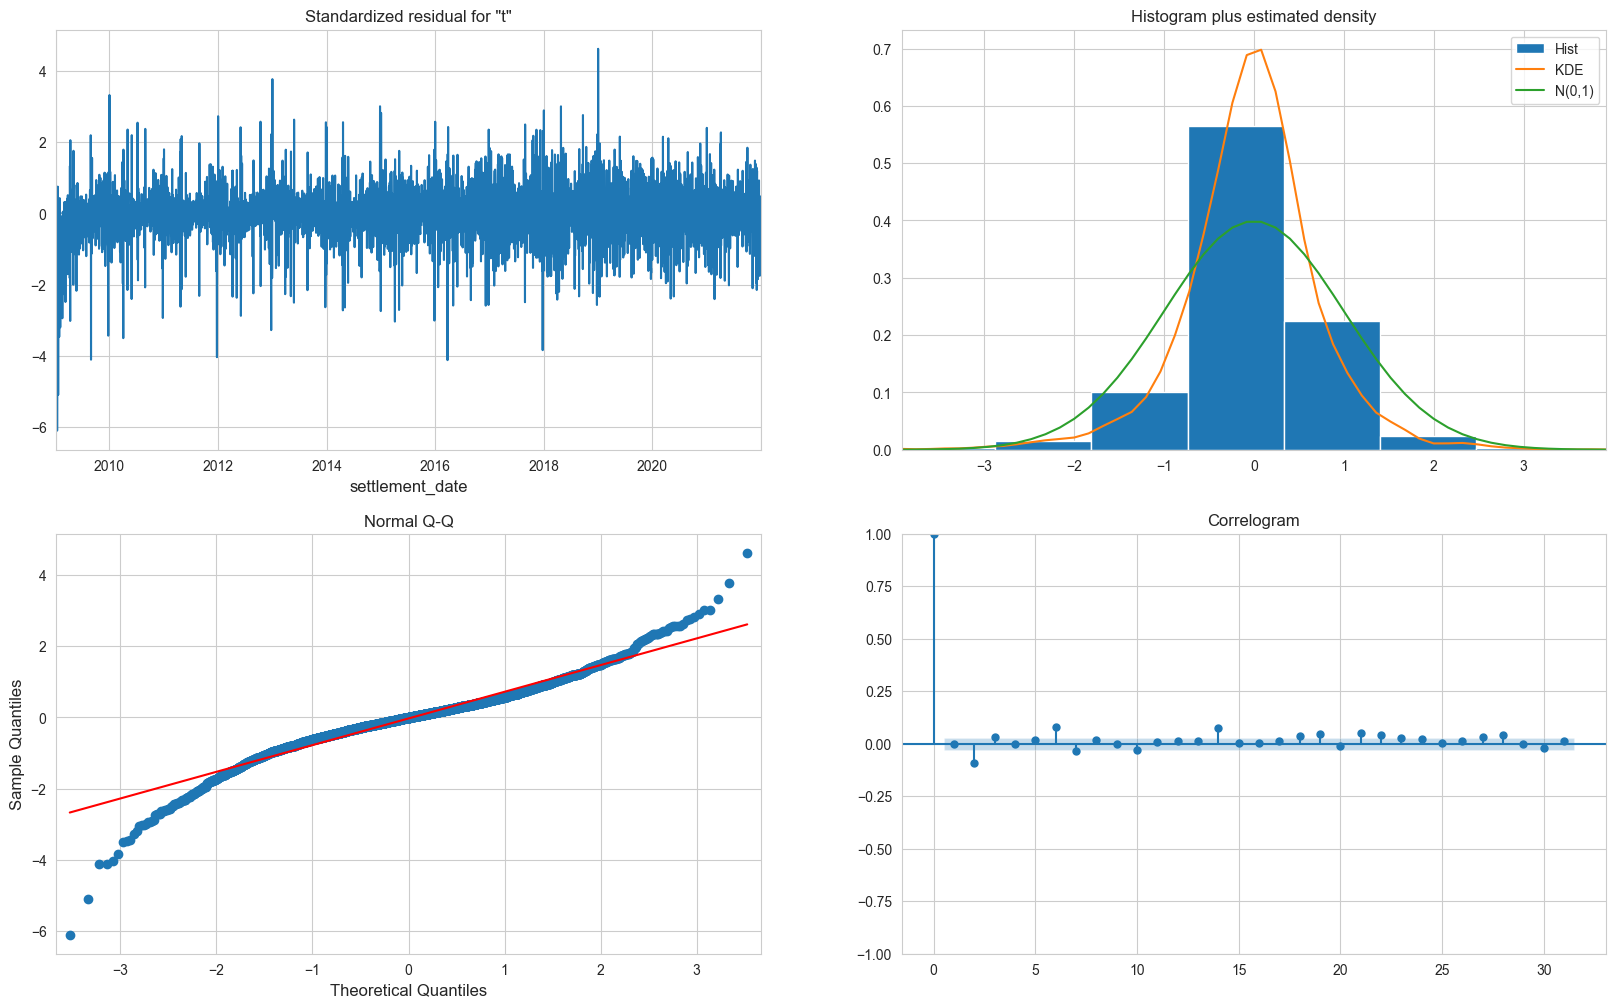

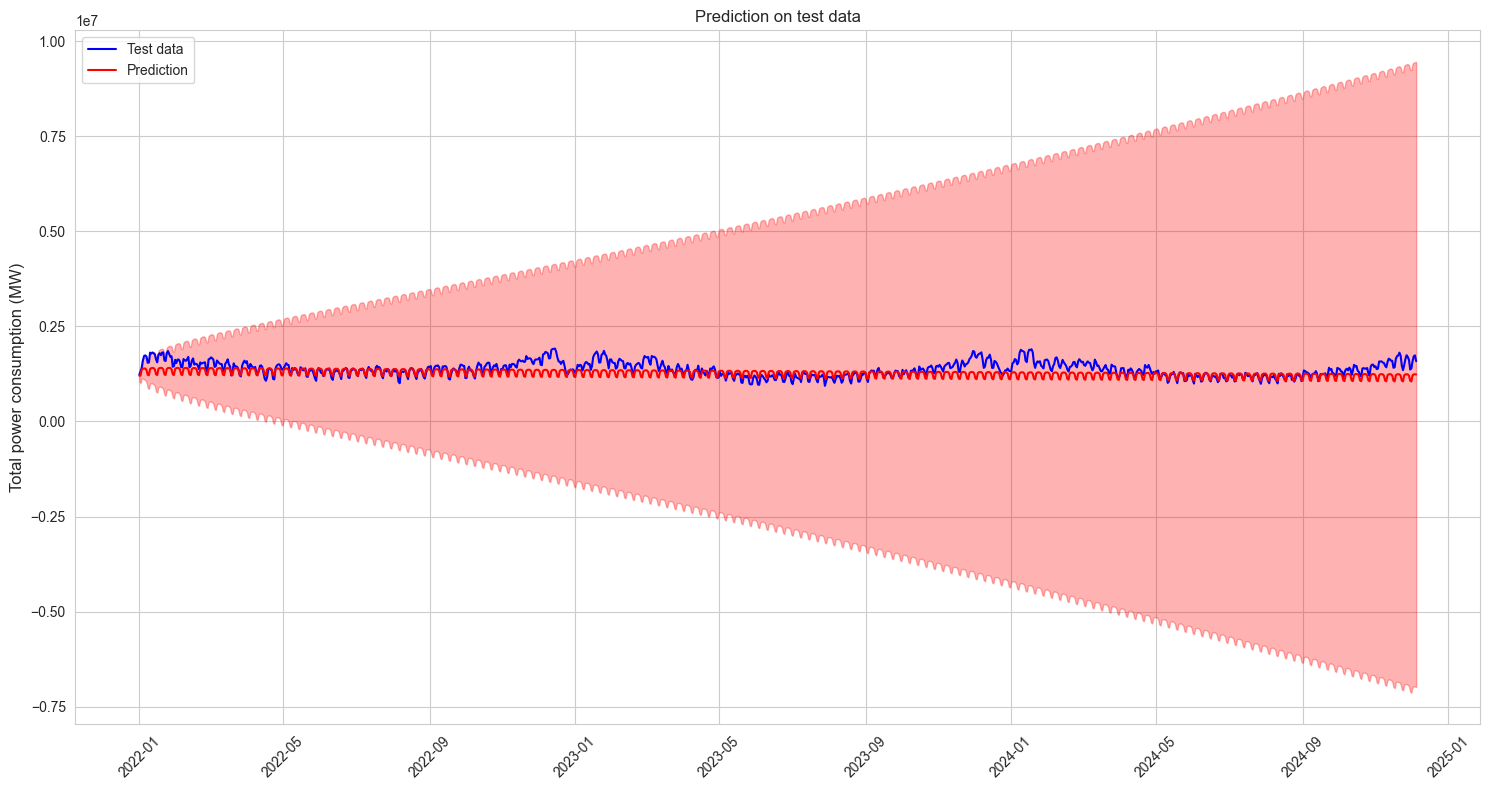

In [54]:
# Based on stationarity tests, try:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (1, 1, 1), (1, 1, 1, 7), 75, 31, test_data, False
)

In [55]:
print(f"Model 1 MAPE value: {mape_1}")
print(f"Model 1 runtime: {execution_time_1}")

Model 1 MAPE value: 10.257226123763715
Model 1 runtime: 0:00:04.574083


### Model-2 (p,d,q)->(1,1,1); (P,D,Q,s)->(1,1,1,12) ###

Normality: val=662.912, p=0.000
Ljung-Box: val=9146.634, p=0.000
Heteroskedasticity: val=0.696, p=0.000
Durbin-Watson: d=2.05
-------------------------------------------------------------
Test data shape: (1070,)
Prediction shape: (1070,)
MAPE: 11.28%


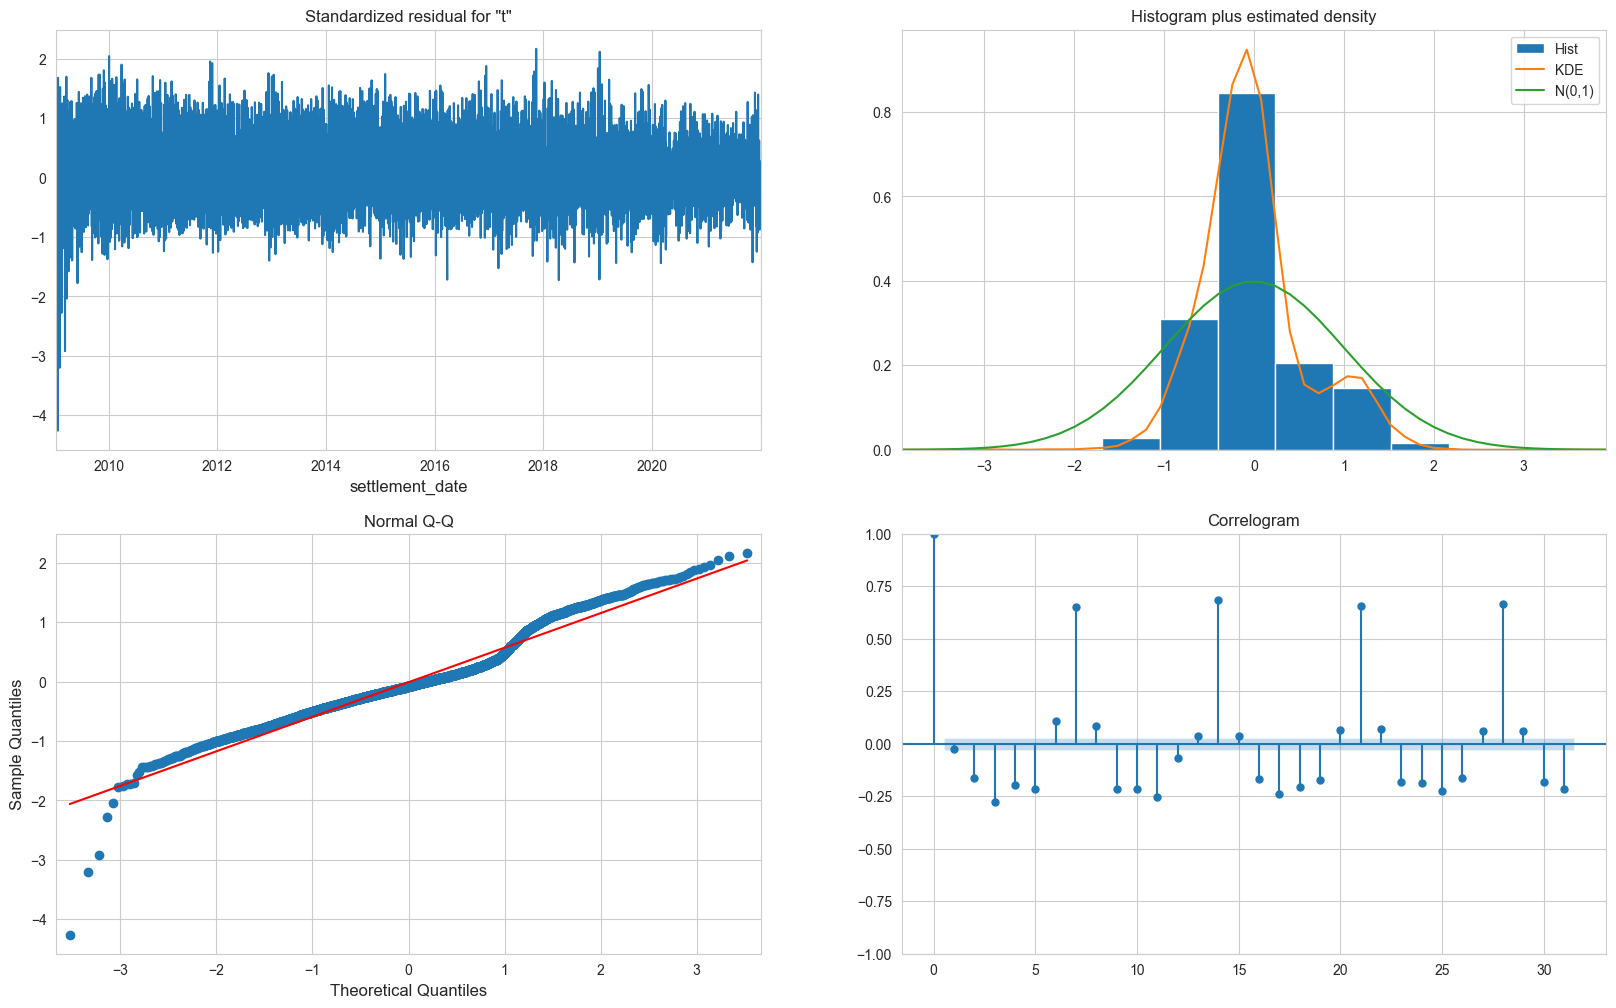

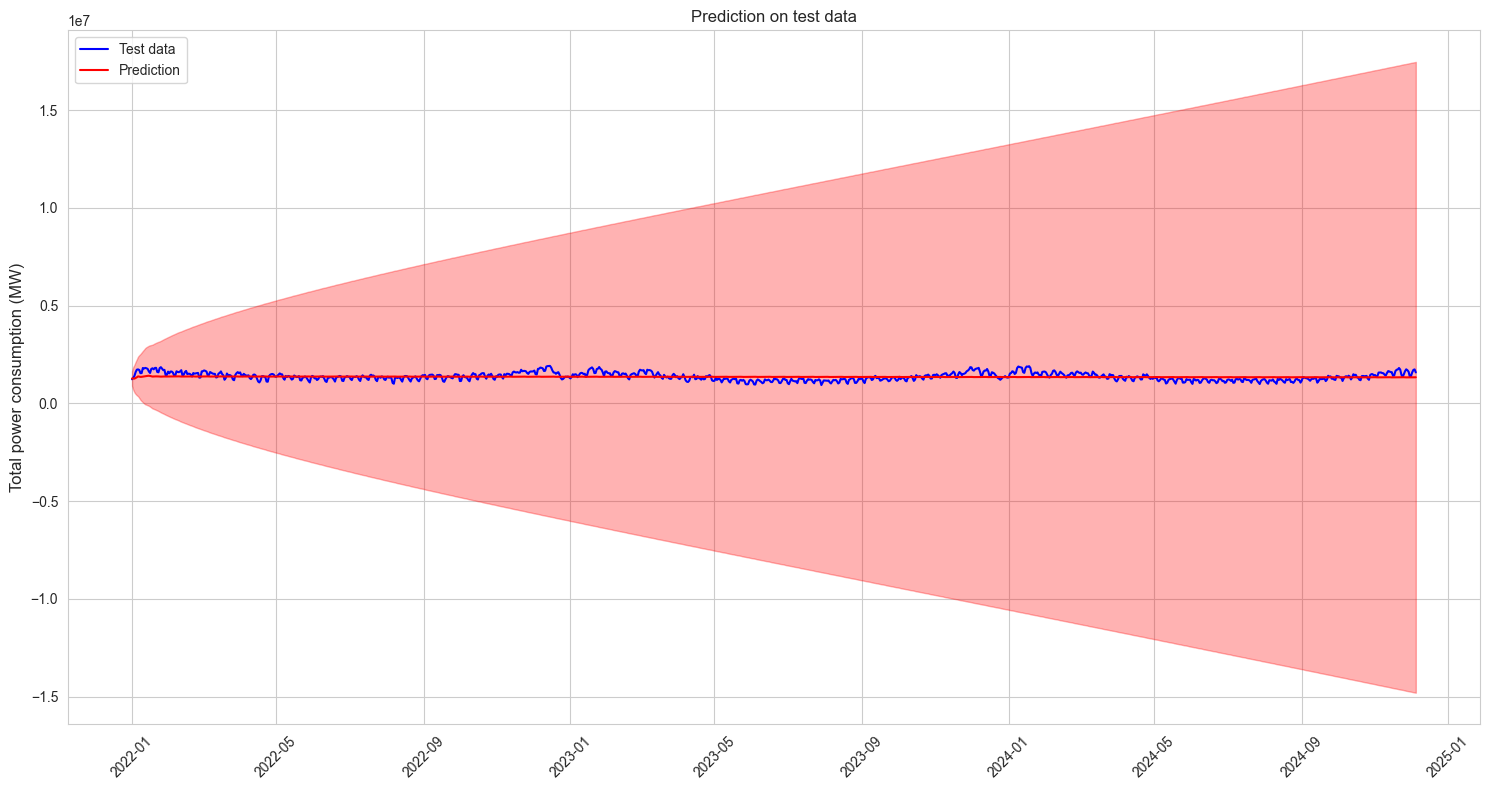

In [56]:
# with weekly seasonality:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (1, 1, 1), (1, 1, 1, 12), 75, 31, test_data, False
)

In [57]:
print(f"Model 2 MAPE value: {mape_2}")
print(f"Model 2 runtime: {execution_time_2}")

Model 2 MAPE value: 11.280959341296086
Model 2 runtime: 0:00:10.329619


### Model-3 (Reduced complexity to avoid memory error)

c:\Users\Sivakumar.R\OneDrive - Shell\Documents\1.casestudy\fresh_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Normality: val=4073.819, p=0.000
Ljung-Box: val=4955.251, p=0.000
Heteroskedasticity: val=0.757, p=0.000
Durbin-Watson: d=2.37
-------------------------------------------------------------
Test data shape: (1070,)
Prediction shape: (1070,)
MAPE: 14.26%


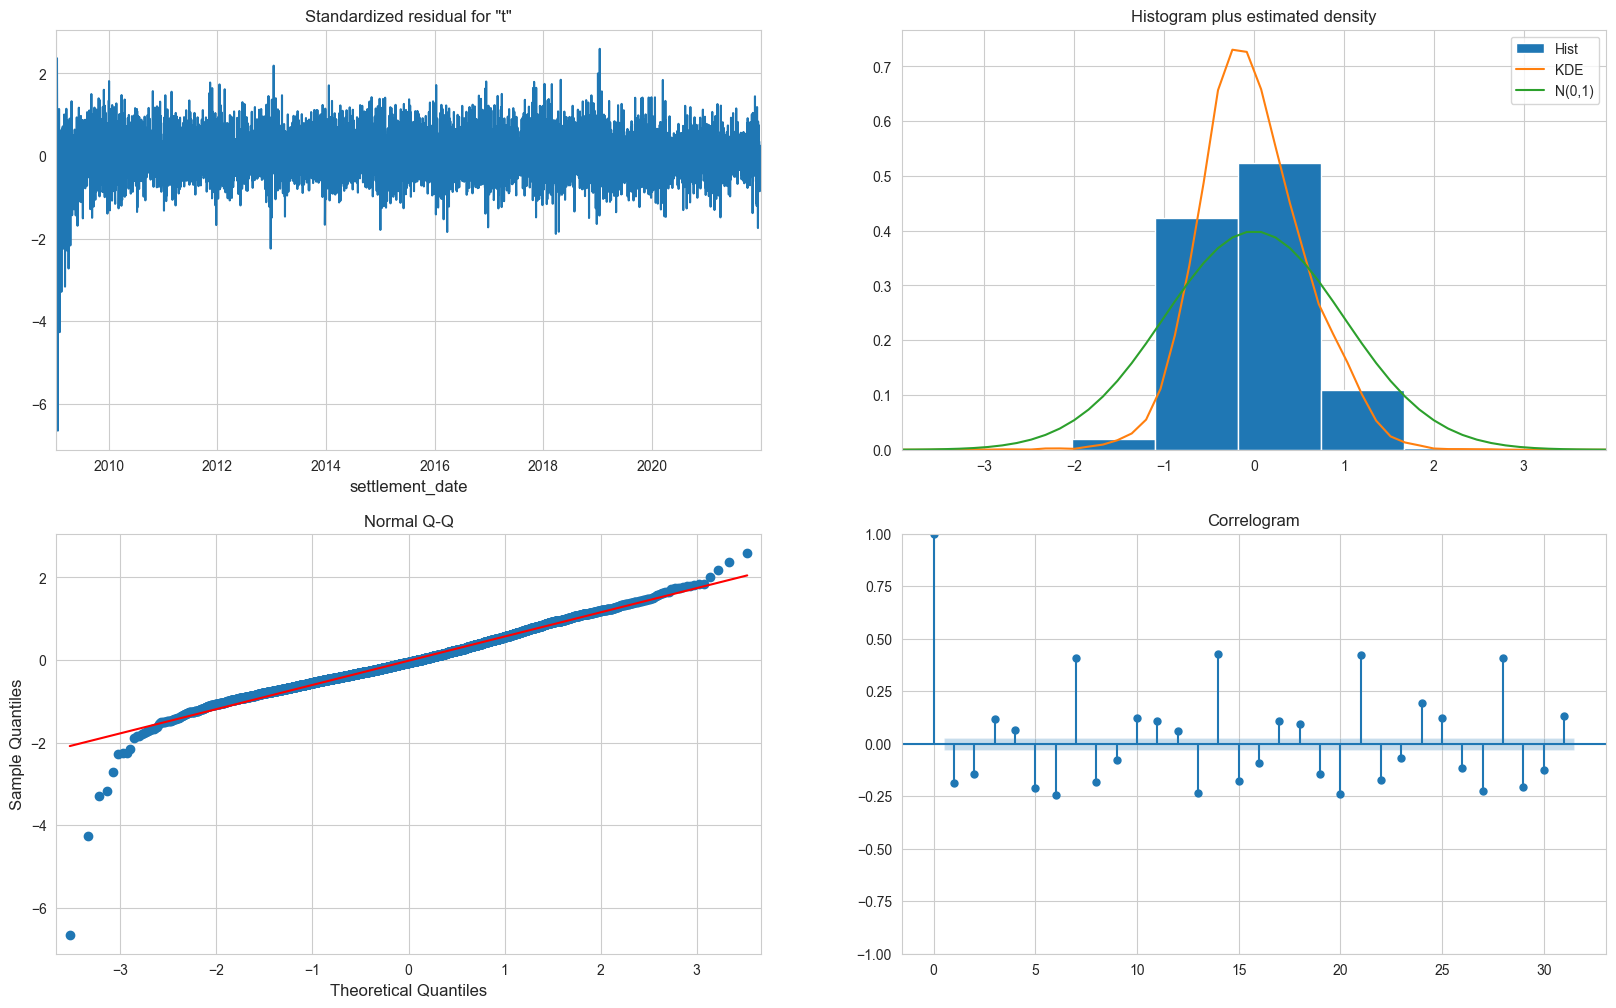

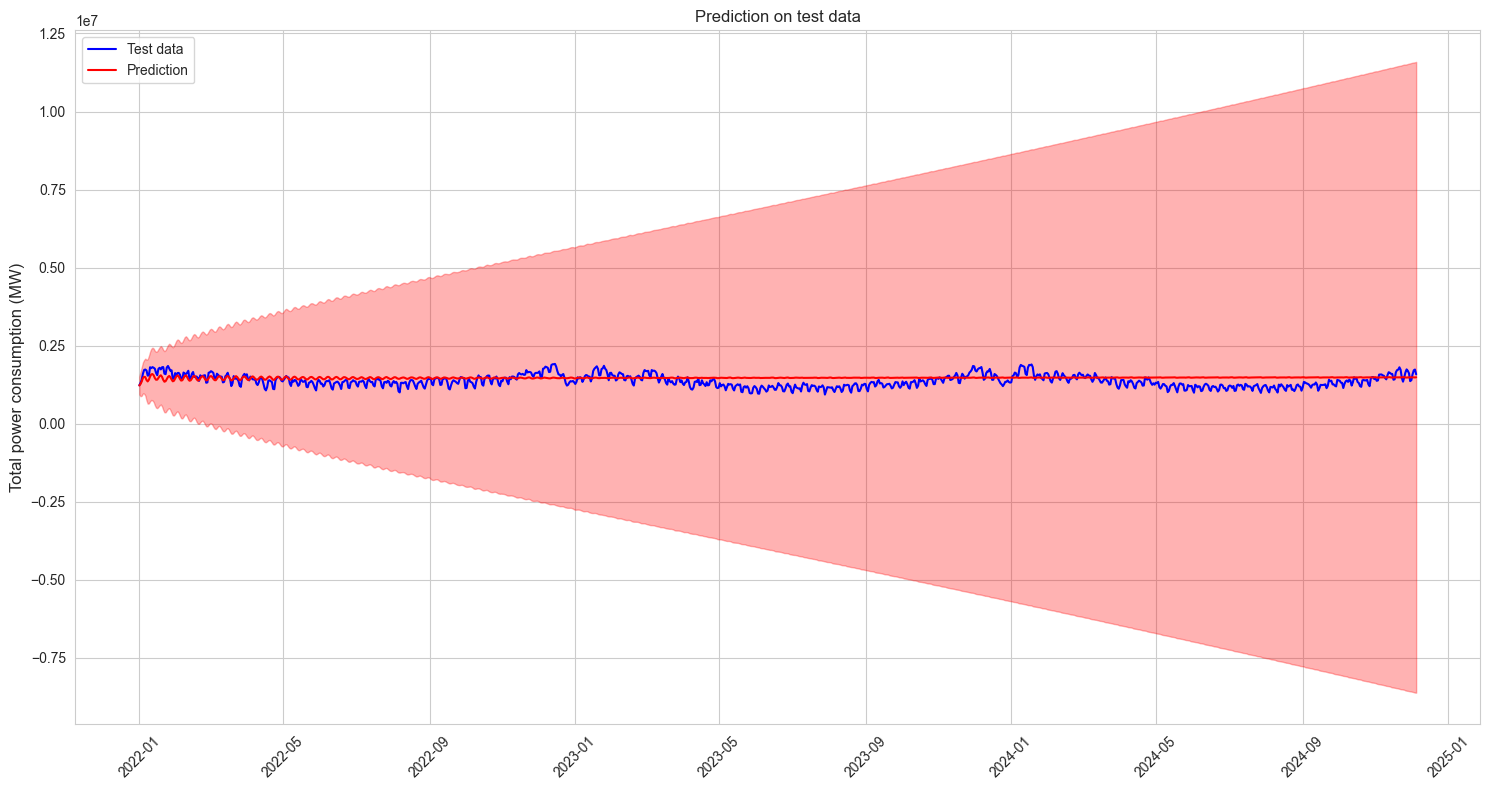

In [58]:
# Reduced model complexity to avoid memory allocation error
# Changed from (7,1,7),(3,1,2,12) to (2,1,2),(1,1,1,12)
[execution_time_3, mape_3, sarima_model_3] = create_predict_analyse(
    train_data, (2, 1, 2), (1, 1, 1, 12), 75, 31, test_data, False
)

In [59]:
print(f"Model 3 MAPE value: {mape_3}")
print(f"Model 3 runtime: {execution_time_3}")

Model 3 MAPE value: 14.261655297717981
Model 3 runtime: 0:00:25.149758


In [60]:
# Model comparison summary
model_comparison = pd.DataFrame({
    'Model': ['Base Model', 'Model 1', 'Model 2', 'Model 3'],
    'Parameters': ['(1,0,1)(1,0,1,12)', '(1,1,1)(1,1,1,7)', '(1,1,1)(1,1,1,12)', '(2,1,2)(1,1,1,12)'],
    'MAPE (%)': [mape_0, mape_1, mape_2, mape_3],
    'Runtime': [execution_time_0, execution_time_1, execution_time_2, execution_time_3],
    'AIC': [sarima_model_0.aic, sarima_model_1.aic, sarima_model_2.aic, sarima_model_3.aic],
    'BIC': [sarima_model_0.bic, sarima_model_1.bic, sarima_model_2.bic, sarima_model_3.bic]
})

print("MODEL COMPARISON SUMMARY\n")
print(model_comparison.to_string(index=False))

MODEL COMPARISON SUMMARY

     Model        Parameters  MAPE (%)                Runtime           AIC           BIC
Base Model (1,0,1)(1,0,1,12) 38.212698 0 days 00:00:06.548256 123447.400659 123479.728052
   Model 1  (1,1,1)(1,1,1,7) 10.257226 0 days 00:00:04.574083 118004.443483 118036.762445
   Model 2 (1,1,1)(1,1,1,12) 11.280959 0 days 00:00:10.329619 125464.102243 125496.415928
   Model 3 (2,1,2)(1,1,1,12) 14.261655 0 days 00:00:25.149758 123041.614434 123086.853593


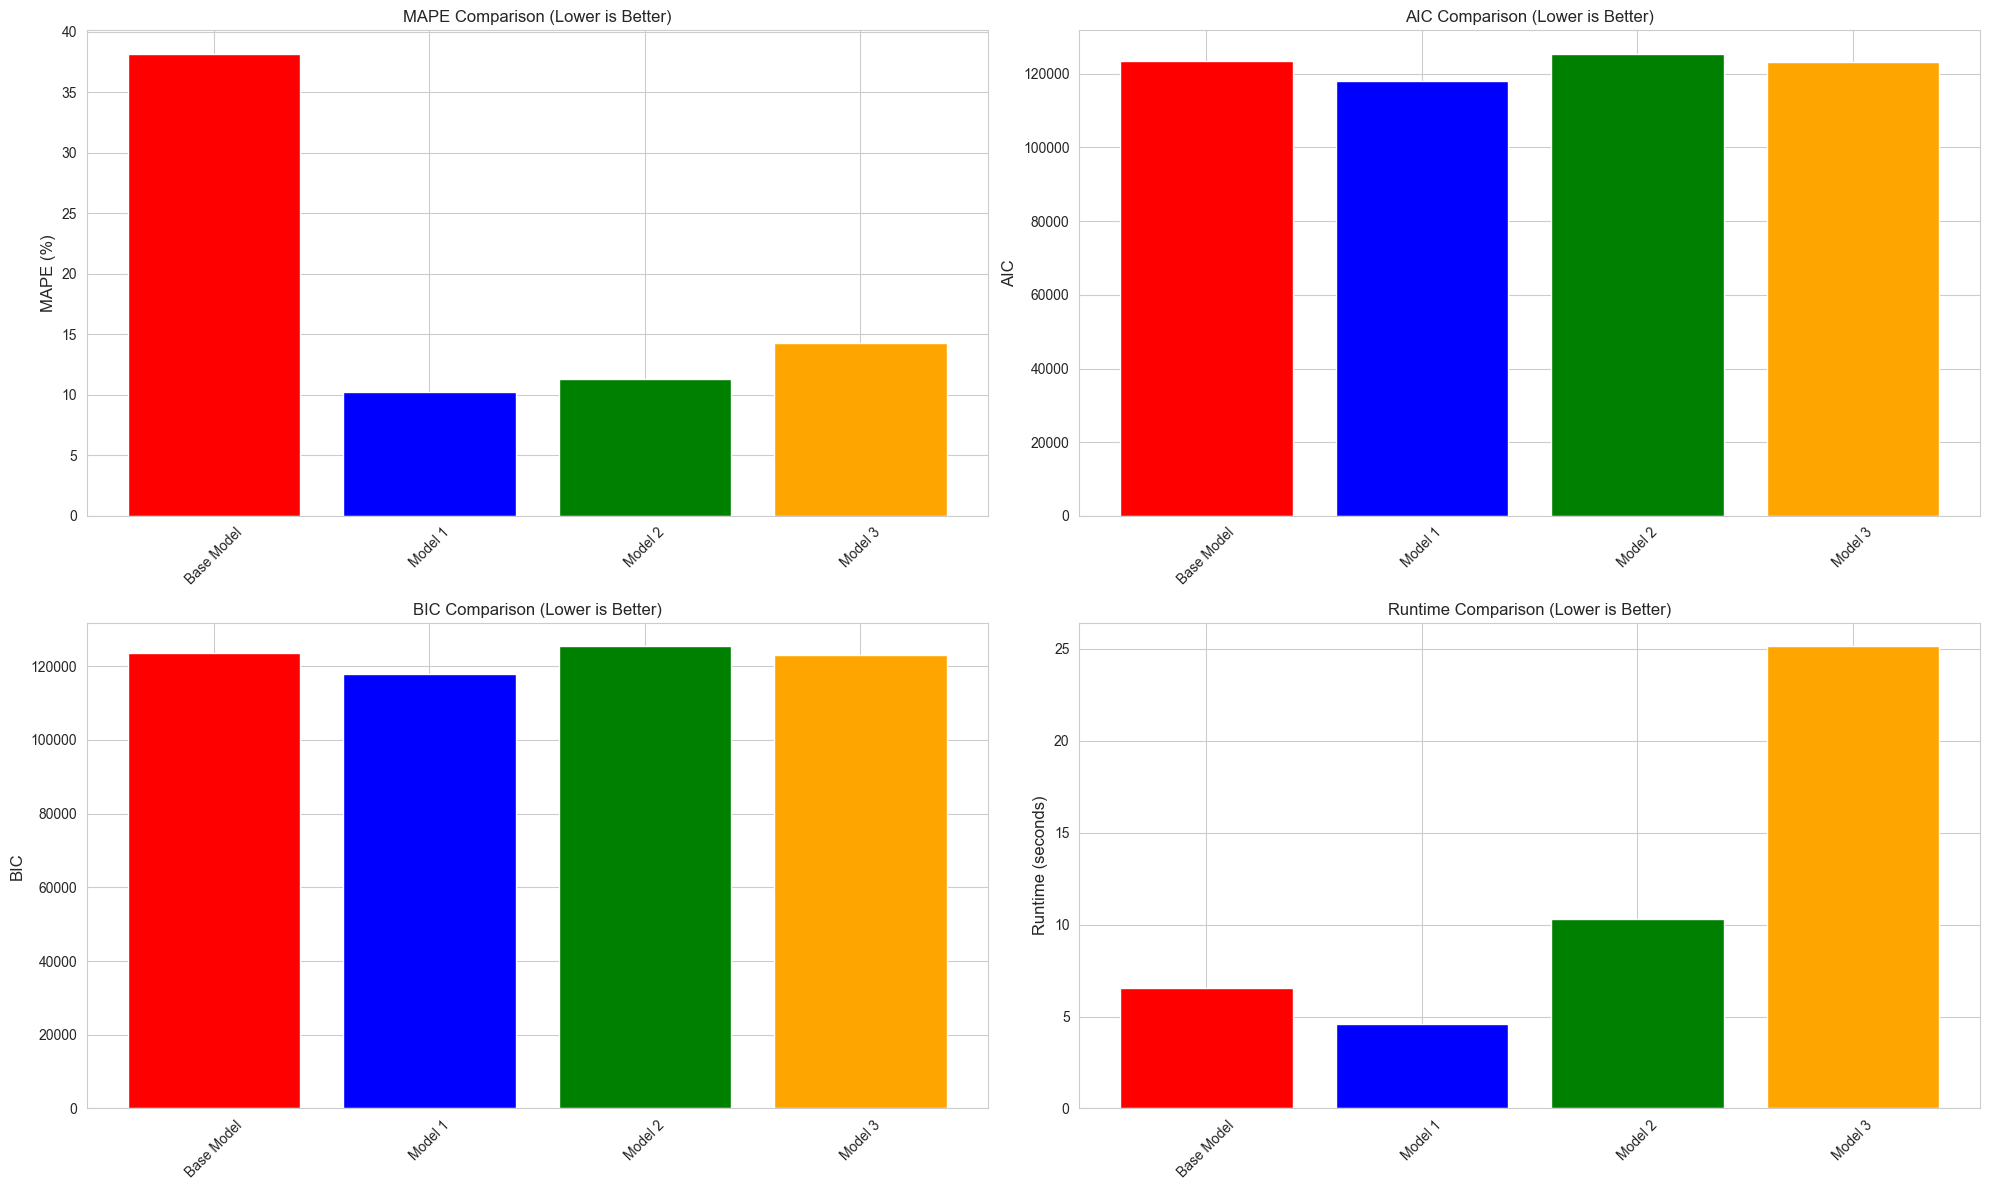

In [61]:
#create chart 

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# MAPE Comparison
axes[0,0].bar(model_comparison['Model'], model_comparison['MAPE (%)'], 
              color=['red', 'blue', 'green', 'orange'])
axes[0,0].set_title('MAPE Comparison (Lower is Better)')
axes[0,0].set_ylabel('MAPE (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# AIC Comparison
axes[0,1].bar(model_comparison['Model'], model_comparison['AIC'], 
              color=['red', 'blue', 'green', 'orange'])
axes[0,1].set_title('AIC Comparison (Lower is Better)')
axes[0,1].set_ylabel('AIC')
axes[0,1].tick_params(axis='x', rotation=45)

# BIC Comparison
axes[1,0].bar(model_comparison['Model'], model_comparison['BIC'], 
              color=['red', 'blue', 'green', 'orange'])
axes[1,0].set_title('BIC Comparison (Lower is Better)')
axes[1,0].set_ylabel('BIC')
axes[1,0].tick_params(axis='x', rotation=45)

# Runtime Comparison
runtime_seconds = [rt.total_seconds() for rt in model_comparison['Runtime']]
axes[1,1].bar(model_comparison['Model'], runtime_seconds, 
              color=['red', 'blue', 'green', 'orange'])
axes[1,1].set_title('Runtime Comparison (Lower is Better)')
axes[1,1].set_ylabel('Runtime (seconds)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [62]:
# statistical summary of themodel
# Function to extract all diagnostic stats
def get_model_diagnostics(model):
    """Extract key diagnostic statistics from SARIMA model"""
    # Normality test
    norm_val, norm_p, _, _ = model.test_normality("jarquebera")[0]
    
    # Ljung-Box test
    lb_val, lb_p = model.test_serial_correlation(method="ljungbox")[0]
    lb_val, lb_p = lb_val[-1], lb_p[-1]
    
    # Heteroskedasticity test
    het_val, het_p = model.test_heteroskedasticity("breakvar")[0]
    
    # Durbin-Watson
    dw = statsmodels.stats.stattools.durbin_watson(
        model.filter_results.standardized_forecasts_error[0, model.loglikelihood_burn:]
    )
    
    return {
        'Normality_p': norm_p,
        'LjungBox_p': lb_p, 
        'Heteroskedasticity_p': het_p,
        'DurbinWatson': dw,
        'Normality_Pass': norm_p > 0.05,
        'LjungBox_Pass': lb_p > 0.05,
        'Heteroskedasticity_Pass': het_p > 0.05,
        'DurbinWatson_Pass': 1.5 < dw < 2.5
    }

# Get diagnostics for all models
models = [sarima_model_0, sarima_model_1, sarima_model_2, sarima_model_3]
model_names = ['Base Model', 'Model 1', 'Model 2', 'Model 3']

diagnostics_df = pd.DataFrame([get_model_diagnostics(model) for model in models])
diagnostics_df.index = model_names

print("=== DIAGNOSTIC TEST RESULTS ===")
print(diagnostics_df[['Normality_Pass', 'LjungBox_Pass', 'Heteroskedasticity_Pass', 'DurbinWatson_Pass']])

=== DIAGNOSTIC TEST RESULTS ===
            Normality_Pass  LjungBox_Pass  Heteroskedasticity_Pass  \
Base Model           False          False                    False   
Model 1              False          False                    False   
Model 2              False          False                    False   
Model 3              False          False                    False   

            DurbinWatson_Pass  
Base Model               True  
Model 1                  True  
Model 2                  True  
Model 3                  True  


#

In [63]:
# Model Ranking 
def rank_models(comparison_df):
    """Rank models based on multiple criteria"""
    df = comparison_df.copy()
    
    # Lower is better for these metrics
    df['MAPE_Rank'] = df['MAPE (%)'].rank()
    df['AIC_Rank'] = df['AIC'].rank() 
    df['BIC_Rank'] = df['BIC'].rank()
    
    # Calculate total score (lower is better)
    df['Total_Score'] = df['MAPE_Rank'] + df['AIC_Rank'] + df['BIC_Rank']
    df['Final_Rank'] = df['Total_Score'].rank()
    
    return df[['Model', 'MAPE (%)', 'AIC', 'BIC', 'Final_Rank']].sort_values('Final_Rank')

ranked_models = rank_models(model_comparison)
print("=== MODEL RANKING (1=Best, 4=Worst) ===")
print(ranked_models.to_string(index=False))

=== MODEL RANKING (1=Best, 4=Worst) ===
     Model  MAPE (%)           AIC           BIC  Final_Rank
   Model 1 10.257226 118004.443483 118036.762445         1.0
   Model 3 14.261655 123041.614434 123086.853593         2.0
Base Model 38.212698 123447.400659 123479.728052         3.5
   Model 2 11.280959 125464.102243 125496.415928         3.5


In [64]:
# Choose best model based on comprehensive evaluation
best_model_idx = ranked_models.iloc[0]['Model']
print(f"\n=== RECOMMENDED MODEL: {best_model_idx} ===")

# Get the actual model object
model_mapping = {
    'Base Model': sarima_model_0,
    'Model 1': sarima_model_1, 
    'Model 2': sarima_model_2,
    'Model 3': sarima_model_3
}

best_model = model_mapping[best_model_idx]
print(f"Parameters: {best_model.model.order} x {best_model.model.seasonal_order}")
print(f"MAPE: {ranked_models.iloc[0]['MAPE (%)']:.2f}%")
print(f"AIC: {ranked_models.iloc[0]['AIC']:.2f}")


=== RECOMMENDED MODEL: Model 1 ===
Parameters: (1, 1, 1) x (1, 1, 1, 7)
MAPE: 10.26%
AIC: 118004.44


### Diagnostic results mean:
- Normality_Pass = False     # ❌ Residuals are NOT normally distributed
- LjungBox_Pass = False      # ❌ Autocorrelation still exists in residuals  
- Heteroskedasticity_Pass = False  # ❌ Variance is NOT constant over time
- DurbinWatson_Pass = True   # ✅ No first-order autocorrelation

### What This Means:
- Ljung-Box Failure (Most Critical): Your models haven't captured all patterns in the data
- Normality Failure: Confidence intervals and statistical inference are unreliable
- Heteroskedasticity Failure: Prediction intervals may be incorrect
- Only Durbin-Watson Passes: No immediate lag-1 correlation issues

### Root Causes & Solutions:
- Problem 1: Model Underfitting (Ljung-Box Failure)
The current models are too simple for the complex electricity demand patterns.
- Problem 2: Data Transformation Needed
Apply transformations to address normality and heteroskedasticity:
- Problem 3: Consider External Variables
Add exogenous variables to capture patterns SARIMA misses:

c:\Users\Sivakumar.R\OneDrive - Shell\Documents\1.casestudy\fresh_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Sivakumar.R\OneDrive - Shell\Documents\1.casestudy\fresh_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Normality: val=3656.420, p=0.000
Ljung-Box: val=66.150, p=0.000
Heteroskedasticity: val=1.172, p=0.002
Durbin-Watson: d=2.04
-------------------------------------------------------------
Test data shape: (1070,)
Prediction shape: (1070,)
MAPE: 9.97%


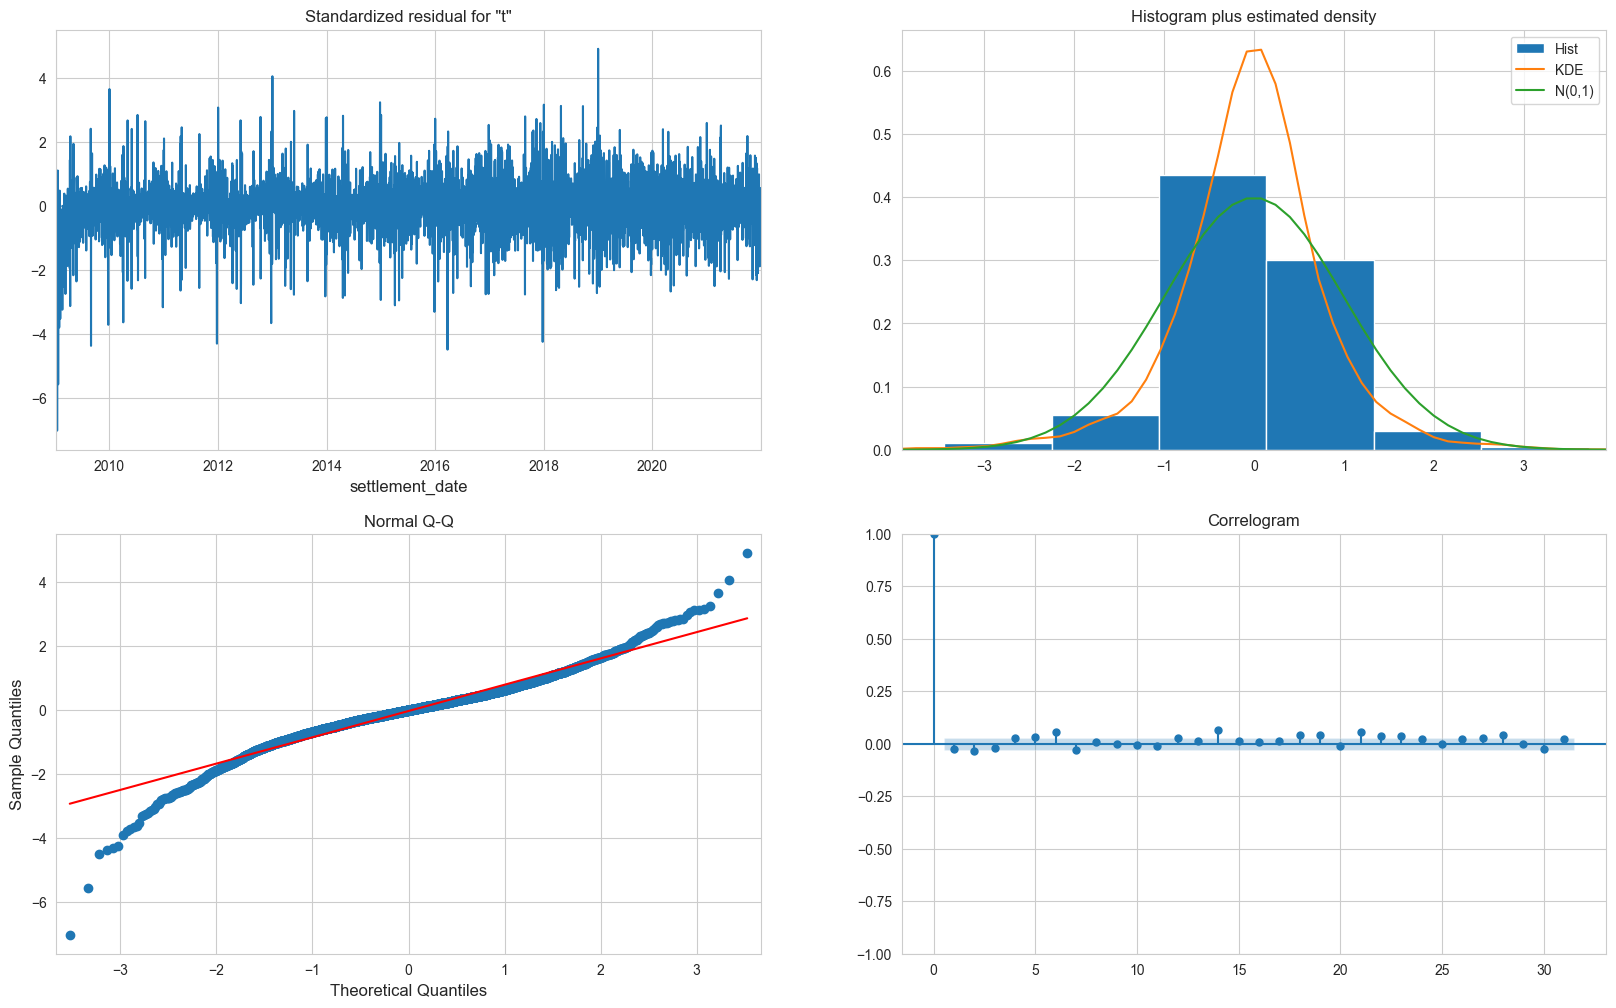

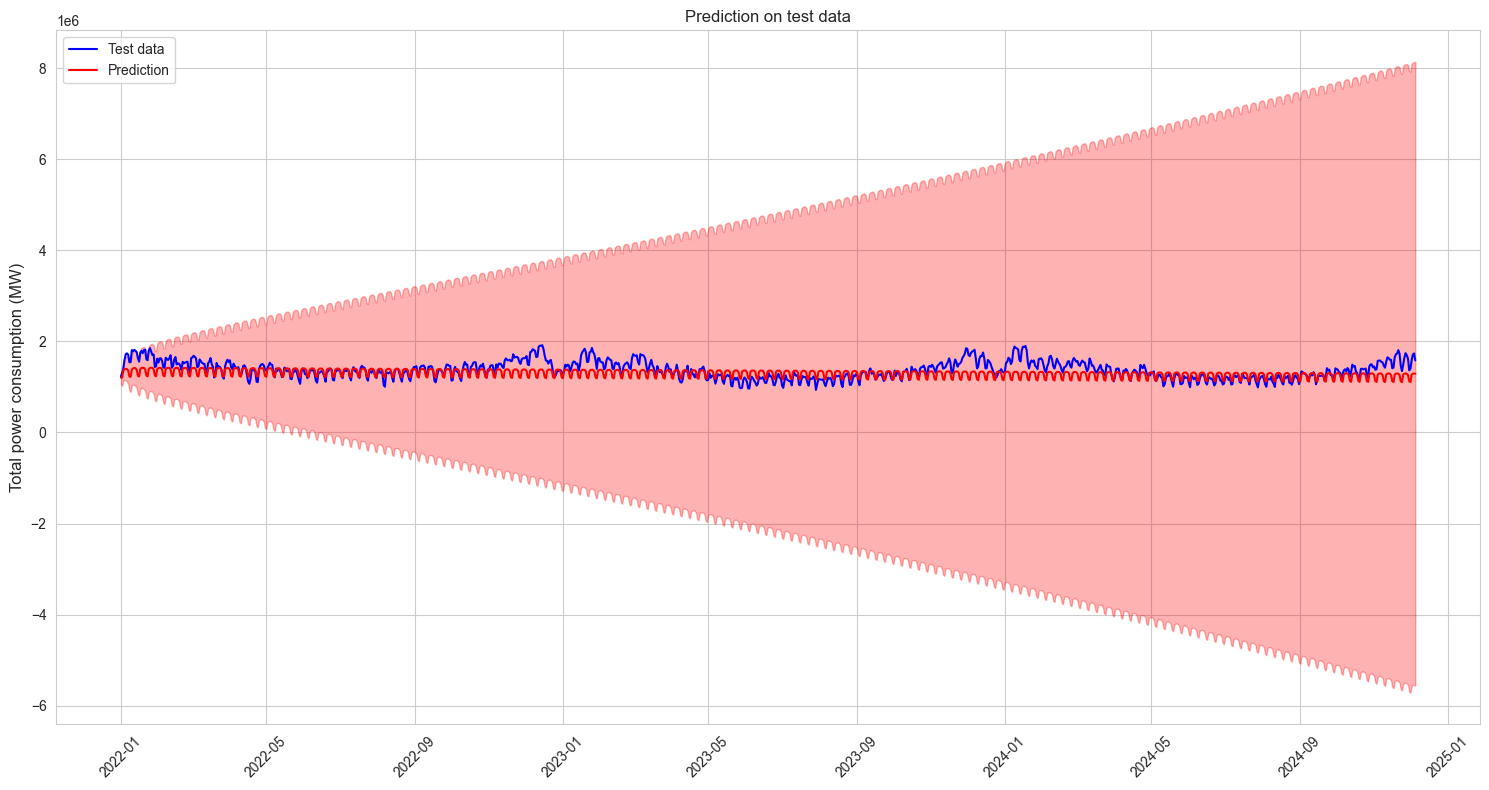

In [65]:
# Try more complex SARIMA models
[execution_time_4, mape_4, sarima_model_4] = create_predict_analyse(
    train_data, (3, 1, 3), (2, 1, 2, 7), 100, 31, test_data, False
)


In [66]:
print(f"Model 4 MAPE value: {mape_4}")
print(f"Model 4 runtime: {execution_time_4}")

Model 4 MAPE value: 9.966903848993311
Model 4 runtime: 0:00:24.439624


In [67]:
get_model_diagnostics_4 = pd.DataFrame([get_model_diagnostics(sarima_model_4)])
print("=== DIAGNOSTIC TEST RESULTS FOR MODEL 4 ===")
print(get_model_diagnostics_4)

=== DIAGNOSTIC TEST RESULTS FOR MODEL 4 ===
   Normality_p    LjungBox_p  Heteroskedasticity_p  DurbinWatson  \
0          0.0  9.529842e-09              0.001664      2.042067   

   Normality_Pass  LjungBox_Pass  Heteroskedasticity_Pass  DurbinWatson_Pass  
0           False          False                    False               True  


- The fact that all models fail suggests the electricity demand data has complex patterns that simple SARIMA cannot capture. XGBoost might be more appropriate for this dataset. or we can use advanced models like prophet, LSTM

***Simple XGboost Model***

*Train - test split*

In [68]:
df.head(5)

settlement_period     hour     nd    tsd  \
settlement_date                                                 
2009-01-01 00:00:00                  1  0:00:00  37910  38704   
2009-01-01 00:30:00                  2  0:30:00  38047  38964   
2009-01-01 01:00:00                  3  1:00:00  37380  38651   
2009-01-01 01:30:00                  4  1:30:00  36426  37775   
2009-01-01 02:00:00                  5  2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  ...  is_holiday  \
settlement_date                                            ...               
2009-01-01 00:00:00                        0            0  ...           1   
2009-01-01 00:30:00                        0            0  ...           1   
2009-01-01 01:00:00                        0            0  ...           1   
2009-01-01 01:30:00                        0            0  ...           1   
2009-01-01 02:00:00                        0            0  ...           1   

                     dayofmonth  dayofweek  quarter  month  year  weekofyear  \
settlement_date                                                                
2009-01-01 00:00:00           1          3        1      1  2009           1   
2009-01-01 00:30:00           1          3        1      1  2009           1   
2009-01-01 01:00:00           1          3        1      1  2009           1   
2009-01-01 01:30:00           1          3        1      1  2009           1   
2009-01-01 02:00:00           1          3        1      1  2009           1   

                     lag1  lag2  lag3  
settlement_date                        
2009-01-01 00:00:00   NaN   NaN   NaN  
2009-01-01 00:30:00   NaN   NaN   NaN  
2009-01-01 01:00:00   NaN   NaN   NaN  
2009-01-01 01:30:00   NaN   NaN   NaN  
2009-01-01 02:00:00   NaN   NaN   NaN  

[5 rows x 27 columns]

In [69]:
df['dayofyear'] = df.index.dayofyear

In [70]:
threshold_date_1 = '06-01-2019'
threshold_date_2 = '06-01-2021'
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
holdout_data = df.loc[df.index >= threshold_date_2]

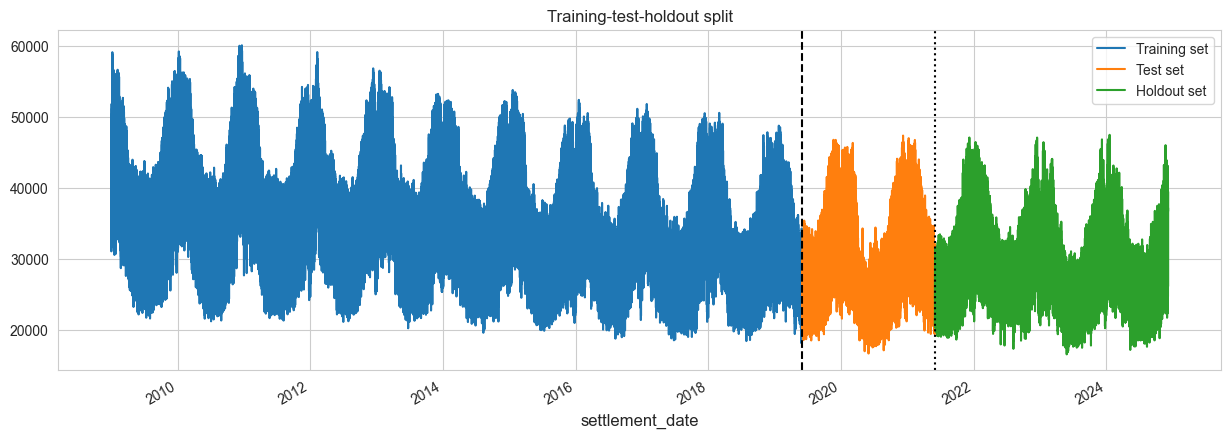

In [71]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data['tsd'].plot(ax=ax, label='Training set')
test_data['tsd'].plot(ax=ax, label='Test set')
holdout_data['tsd'].plot(ax=ax, label='Holdout set')
ax.axvline(threshold_date_1, color='k', ls='--')
ax.axvline(threshold_date_2, color='k', ls=':')
ax.set_title('Training-test-holdout split')
plt.legend()
plt.show()


In [72]:
df.columns

Index(['settlement_period', 'hour', 'nd', 'tsd', 'england_wales_demand',
       'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday', 'dayofmonth',
       'dayofweek', 'quarter', 'month', 'year', 'weekofyear', 'lag1', 'lag2',
       'lag3', 'dayofyear'],
      dtype='object')

In [73]:
# define features and  target variable
Features = ['settlement_period', 
            'is_holiday', 
            'dayofmonth', 
            'dayofweek',
            'month', 
            'year', 
            'dayofyear', 
            'weekofyear',
            'quarter']
Target = ['tsd']

#prepare the training, test, holdout dataset

X_train = train_data[Features]
y_train = train_data[Target]

X_test = test_data[Features]
y_test = test_data[Target]

X_holdout = holdout_data[Features]
y_holdout = holdout_data[Target]

#initialize and fit the xgboost model

simple_xgb = xgb.XGBRegressor(n_estimators=500, 
                              learning_rate=0.01,
                              max_depth=3, 
                              early_stopping_rounds=50,
                              random_state=42)


simple_xgb.fit(X_train, y_train,
               eval_set=[(X_test, y_test), (X_holdout, y_holdout)],
               verbose=100)


[0]	validation_0-rmse:8381.42690	validation_1-rmse:8346.85689
[100]	validation_0-rmse:6306.24148	validation_1-rmse:6453.99074
[200]	validation_0-rmse:5169.93210	validation_1-rmse:5413.53964
[300]	validation_0-rmse:4482.63455	validation_1-rmse:4775.37270
[400]	validation_0-rmse:4047.68658	validation_1-rmse:4381.90851
[499]	validation_0-rmse:3786.91275	validation_1-rmse:4133.70529


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

*Check Feature importance*
- Since there are multiple parameters, we can check the importance of each feature

<Axes: title={'center': 'Feature importance - XGBoost Model'}>

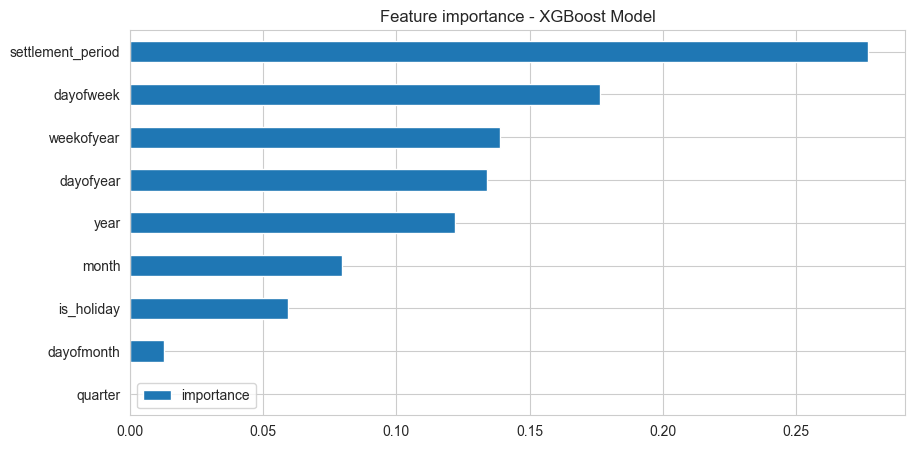

In [74]:
feature_imp_1 = pd.DataFrame(
    data=simple_xgb.feature_importances_,
    index=simple_xgb.get_booster().feature_names,
    columns=['importance']
)
feature_imp_1 = feature_imp_1.sort_values(by='importance', ascending=True)

feature_imp_1.plot(kind='barh', figsize=(10,5), title='Feature importance - XGBoost Model')

*forecast on test*

In [75]:
result_df = y_test.copy()
result_df['XGBoost_Prediction'] = simple_xgb.predict(X_test)
result_df.sample(5)

tsd  XGBoost_Prediction
settlement_date                               
2019-06-19 03:00:00  22467        22743.181641
2019-11-21 17:30:00  44838        41572.023438
2020-03-25 03:30:00  23133        27794.103516
2020-05-07 13:30:00  21955        33314.714844
2020-11-04 07:00:00  34997        36283.144531

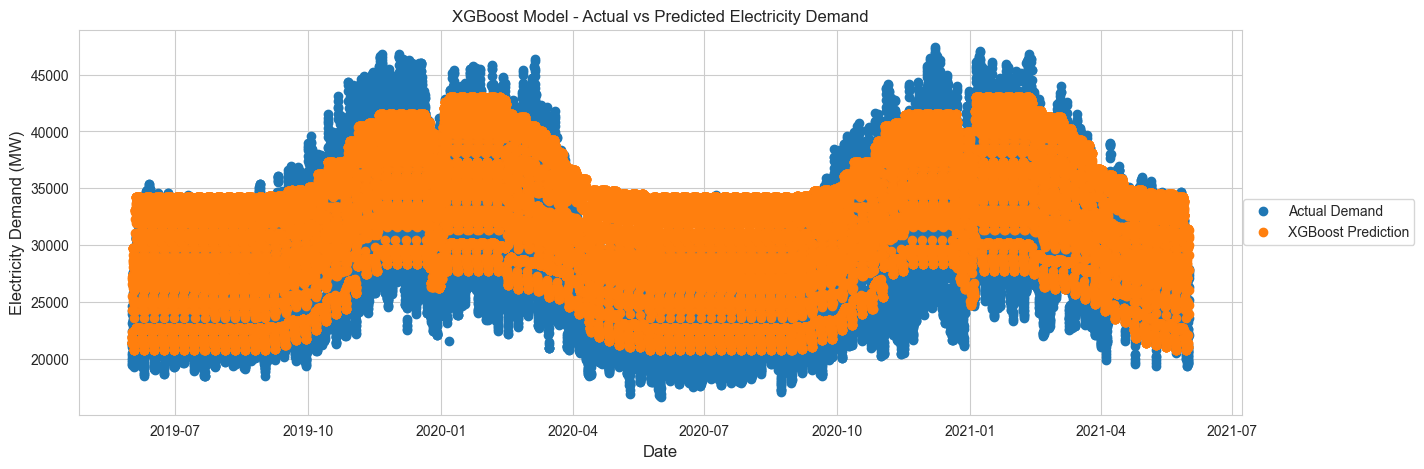

In [76]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(result_df.index, result_df['tsd'], 'o', label='Actual Demand')
ax.plot(result_df.index, result_df['XGBoost_Prediction'], 'o', label='XGBoost Prediction')
ax.set_title('XGBoost Model - Actual vs Predicted Electricity Demand')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')
ax.legend(loc='center', bbox_to_anchor=(1.075, 0.5))

plt.show()

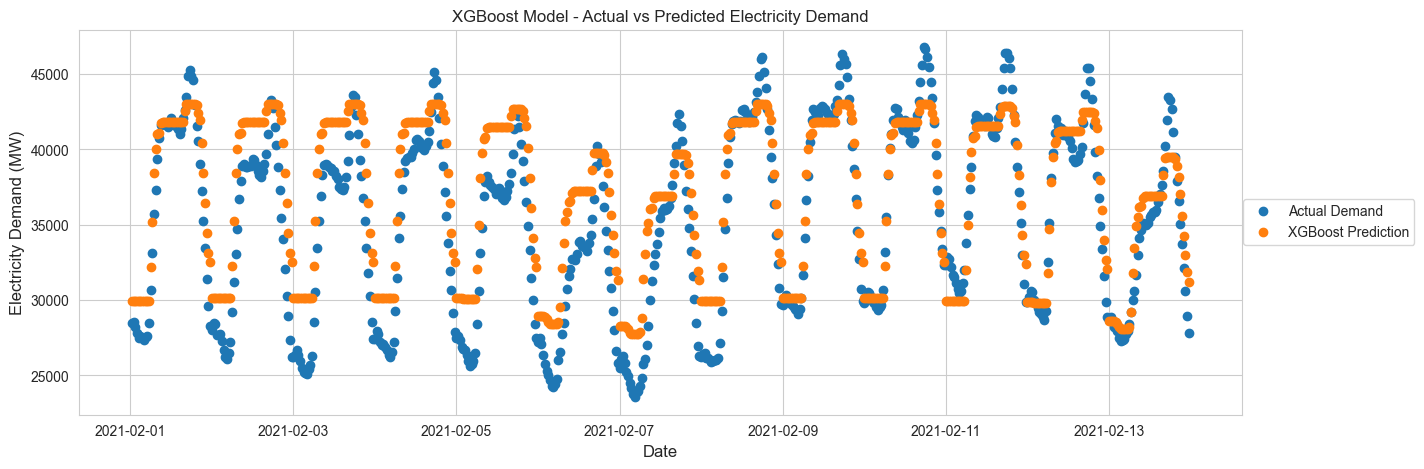

In [77]:
#lets focus on single for comparison

begin = '02-01-2021'
end = '02-14-2021'

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(result_df.loc[(result_df.index>begin) & (result_df.index<end)].index, 
        result_df.loc[(result_df.index>begin) & (result_df.index<end)]['tsd'], 'o', label='Actual Demand')
ax.plot(result_df.loc[(result_df.index>begin) & (result_df.index<end)].index, 
        result_df.loc[(result_df.index>begin) & (result_df.index<end)]['XGBoost_Prediction'], 'o', label='XGBoost Prediction')
ax.set_title('XGBoost Model - Actual vs Predicted Electricity Demand')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')
ax.legend(loc='center', bbox_to_anchor=(1.075, 0.5))

plt.show()


*  The model struggles to capture the peaks and valleys

In [78]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_df["XGBoost_Prediction"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_df["XGBoost_Prediction"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 27.02
Root Mean Squared Error of the simple models is: 3786.91 MW


*Include addition features*

In [79]:
# Enhanced feature engineering for XGBoost
def create_advanced_features(df):
    """Create time series features for XGBoost"""
    
    # Lag features (more comprehensive)
    for lag in [1, 2, 7, 14, 30, 365]:
        df[f'lag_{lag}'] = df['tsd'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'rolling_mean_{window}'] = df['tsd'].rolling(window).mean()
        df[f'rolling_std_{window}'] = df['tsd'].rolling(window).std()
    
    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['settlement_period'] / 48)
    df['hour_cos'] = np.cos(2 * np.pi * df['settlement_period'] / 48)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    df['week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

    df['is_weekend'] = df.index.dayofweek >= 5  
    
    # Interaction features
    df['temp_trend'] = df['year'] * df['month']
    df['weekend_hour'] = df['is_weekend'] * df['settlement_period']
    
    return df

# Apply enhanced features
df_enhanced = create_advanced_features(df.copy())

# Updated feature list
Enhanced_Features = [
    'settlement_period', 'is_holiday', 'dayofmonth', 'dayofweek',
    'month', 'year', 'dayofyear', 'weekofyear', 'quarter',
    'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'lag_365',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30',
    'rolling_std_7', 'rolling_std_14', 'rolling_std_30',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
    'temp_trend', 'weekend_hour'
]

In [80]:
threshold_date_1 = '06-01-2019'
threshold_date_2 = '06-01-2021'
train_data = df_enhanced.loc[df_enhanced.index < threshold_date_1]
test_data = df_enhanced.loc[(df_enhanced.index >= threshold_date_1) & (df_enhanced.index < threshold_date_2)]
holdout_data = df_enhanced.loc[df_enhanced.index >= threshold_date_2]

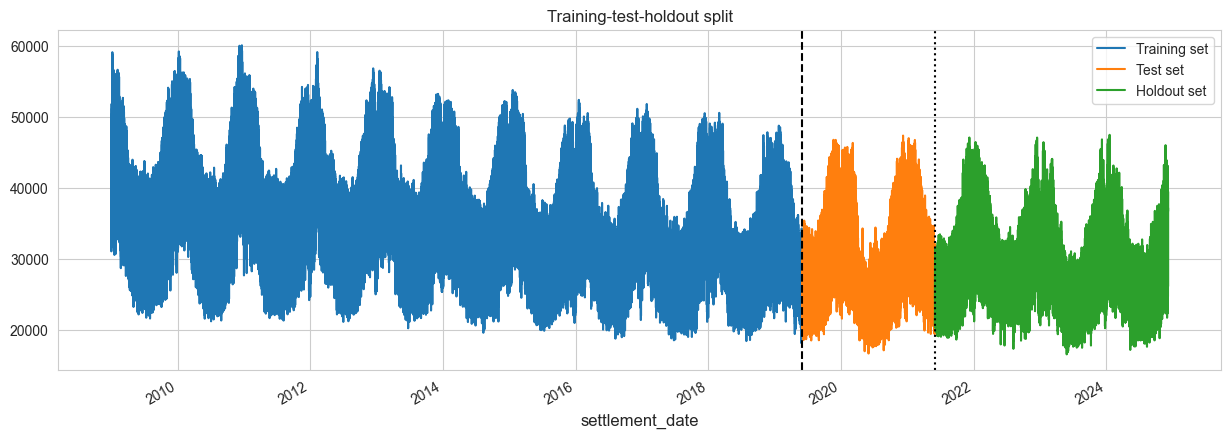

In [81]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data['tsd'].plot(ax=ax, label='Training set')
test_data['tsd'].plot(ax=ax, label='Test set')
holdout_data['tsd'].plot(ax=ax, label='Holdout set')
ax.axvline(threshold_date_1, color='k', ls='--')
ax.axvline(threshold_date_2, color='k', ls=':')
ax.set_title('Training-test-holdout split')
plt.legend()
plt.show()


In [82]:
# define features and  target variable
Features = Enhanced_Features
Target = ['tsd']

#prepare the training, test, holdout dataset

X_train = train_data[Features]
y_train = train_data[Target]

X_test = test_data[Features]
y_test = test_data[Target]

X_holdout = holdout_data[Features]
y_holdout = holdout_data[Target]

#initialize and fit the xgboost model

xgb1 = xgb.XGBRegressor(n_estimators=500, 
                              learning_rate=0.01,
                              max_depth=3, 
                              early_stopping_rounds=50,
                              random_state=42)


xgb1.fit(X_train, y_train,
               eval_set=[(X_test, y_test), (X_holdout, y_holdout)],
               verbose=100)


[0]	validation_0-rmse:8340.65843	validation_1-rmse:8301.23448
[100]	validation_0-rmse:3518.74640	validation_1-rmse:3432.88953
[200]	validation_0-rmse:1762.53459	validation_1-rmse:1683.21782
[300]	validation_0-rmse:1106.51849	validation_1-rmse:1042.46991
[400]	validation_0-rmse:819.80468	validation_1-rmse:774.91318
[499]	validation_0-rmse:674.07120	validation_1-rmse:646.63660


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature importance - XGBoost Model1'}>

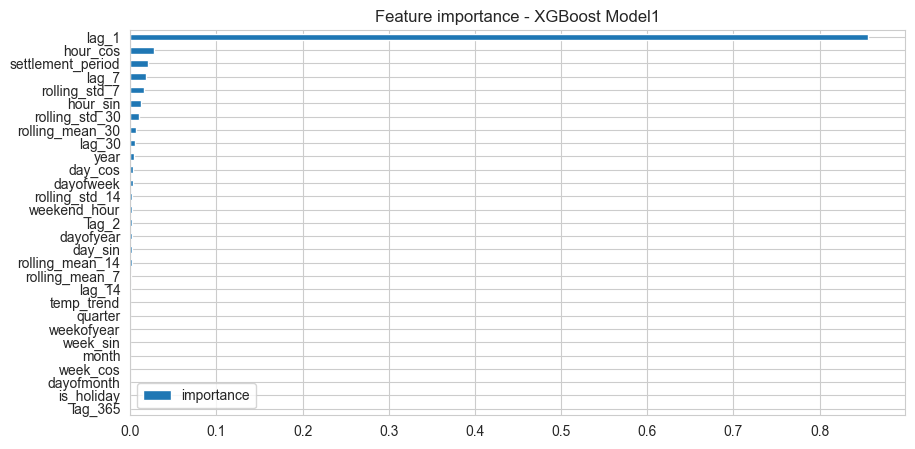

In [83]:
feature_imp_2 = pd.DataFrame(
    data=xgb1.feature_importances_,
    index=xgb1.get_booster().feature_names,
    columns=['importance']
)
feature_imp_2 = feature_imp_2.sort_values(by='importance', ascending=True)

feature_imp_2.plot(kind='barh', figsize=(10,5), title='Feature importance - XGBoost Model1')

In [84]:
result_df = y_test.copy()
result_df['XGBoost_Prediction'] = xgb1.predict(X_test)
result_df.sample(5)

tsd  XGBoost_Prediction
settlement_date                               
2019-10-10 23:30:00  23601        24263.007812
2020-09-04 02:30:00  20669        21148.322266
2020-07-25 02:30:00  18760        20806.429688
2019-07-18 14:30:00  27998        28511.787109
2019-10-27 16:00:00  30716        30647.003906

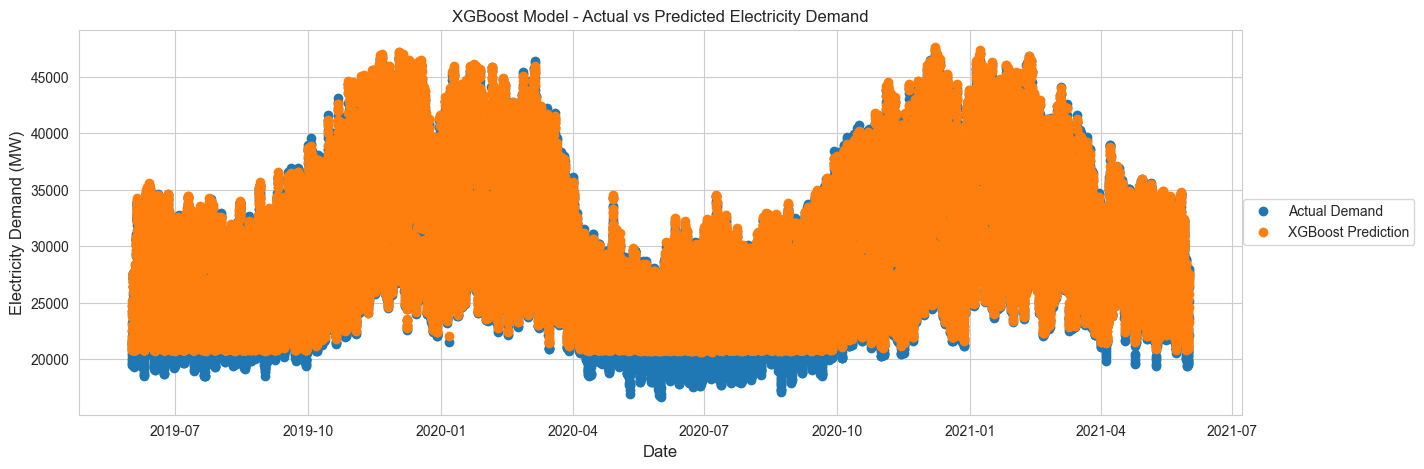

In [85]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(result_df.index, result_df['tsd'], 'o', label='Actual Demand')
ax.plot(result_df.index, result_df['XGBoost_Prediction'], 'o', label='XGBoost Prediction')
ax.set_title('XGBoost Model - Actual vs Predicted Electricity Demand')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')
ax.legend(loc='center', bbox_to_anchor=(1.075, 0.5))

plt.show()

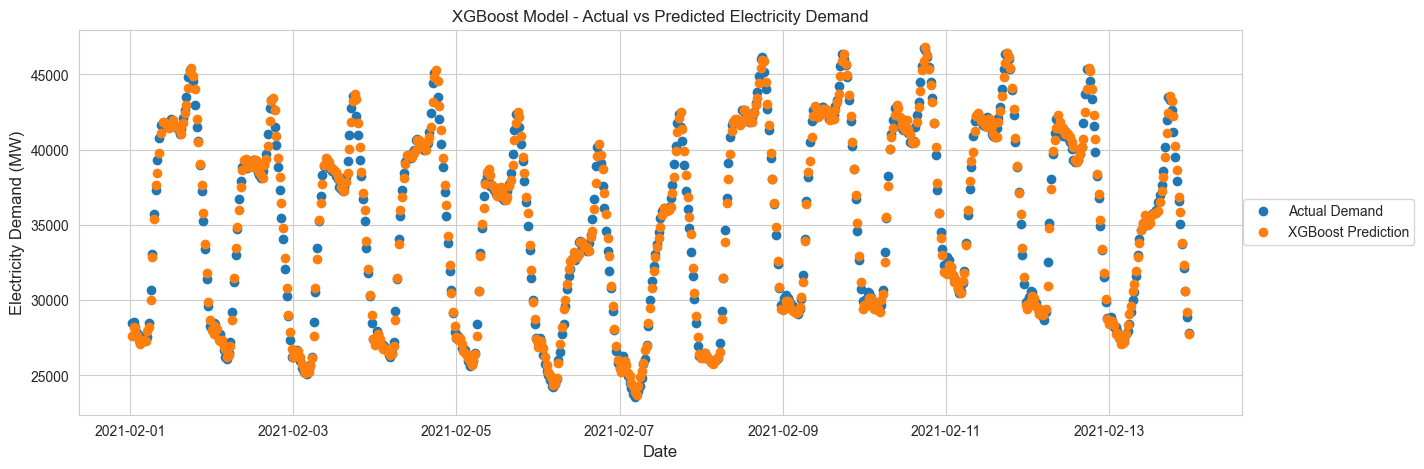

In [86]:
#lets focus on single for comparison

begin = '02-01-2021'
end = '02-14-2021'

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(result_df.loc[(result_df.index>begin) & (result_df.index<end)].index, 
        result_df.loc[(result_df.index>begin) & (result_df.index<end)]['tsd'], 'o', label='Actual Demand')
ax.plot(result_df.loc[(result_df.index>begin) & (result_df.index<end)].index, 
        result_df.loc[(result_df.index>begin) & (result_df.index<end)]['XGBoost_Prediction'], 'o', label='XGBoost Prediction')
ax.set_title('XGBoost Model - Actual vs Predicted Electricity Demand')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')
ax.legend(loc='center', bbox_to_anchor=(1.075, 0.5))

plt.show()


In [87]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_df["XGBoost_Prediction"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_df["XGBoost_Prediction"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 25.16
Root Mean Squared Error of the simple models is: 674.07 MW


*optimize model further*

In [88]:

df.columns

Index(['settlement_period', 'hour', 'nd', 'tsd', 'england_wales_demand',
       'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday', 'dayofmonth',
       'dayofweek', 'quarter', 'month', 'year', 'weekofyear', 'lag1', 'lag2',
       'lag3', 'dayofyear'],
      dtype='object')

In [89]:
#data preprocessing
def create_robust_features(df):
    """Create advanced features with proper NaN handling"""
    df_features = df.copy()
    
    # 1. Lag features with forward fill for missing values
    for lag in [1, 2, 7, 14, 30, 365]:
        df_features[f'lag_{lag}'] = df_features['tsd'].shift(lag)
        # Forward fill recent lags, use seasonal mean for long lags
        if lag <= 7:
            df_features[f'lag_{lag}'].fillna(method='ffill', inplace=True)
        else:
            seasonal_mean = df_features.groupby([df_features.index.month, df_features.index.hour])['tsd'].transform('mean')
            df_features[f'lag_{lag}'].fillna(seasonal_mean, inplace=True)
    
    # 2. Rolling statistics with minimum periods
    for window in [7, 14, 30]:
        df_features[f'rolling_mean_{window}'] = df_features['tsd'].rolling(window, min_periods=3).mean()
        df_features[f'rolling_std_{window}'] = df_features['tsd'].rolling(window, min_periods=3).std()
        df_features[f'rolling_min_{window}'] = df_features['tsd'].rolling(window, min_periods=3).min()
        df_features[f'rolling_max_{window}'] = df_features['tsd'].rolling(window, min_periods=3).max()
        
        # Fill remaining NaNs with column means
        df_features[f'rolling_mean_{window}'].fillna(df_features[f'rolling_mean_{window}'].mean(), inplace=True)
        df_features[f'rolling_std_{window}'].fillna(df_features[f'rolling_std_{window}'].mean(), inplace=True)
        df_features[f'rolling_min_{window}'].fillna(df_features[f'rolling_min_{window}'].mean(), inplace=True)
        df_features[f'rolling_max_{window}'].fillna(df_features[f'rolling_max_{window}'].mean(), inplace=True)
    
    # 3. Enhanced cyclical encoding
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['settlement_period'] / 48)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['settlement_period'] / 48)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features.index.dayofyear / 365.25)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features.index.dayofyear / 365.25)
    df_features['week_sin'] = np.sin(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['week_cos'] = np.cos(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features.index.month / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features.index.month / 12)
    
    # 4. Advanced interaction features
    df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
    df_features['is_peak_hour'] = ((df_features['settlement_period'] >= 17) & 
                                   (df_features['settlement_period'] <= 19)).astype(int)
    df_features['weekend_peak'] = df_features['is_weekend'] * df_features['is_peak_hour']
    df_features['holiday_weekend'] = df_features['is_holiday'] * df_features['is_weekend']
    df_features['seasonal_trend'] = df_features['year'] * df_features['month_sin']
    
    # 5. Demand ratios and differences
    df_features['demand_to_lag1_ratio'] = df_features['tsd'] / (df_features['lag_1'] + 1e-6)
    df_features['demand_to_weekly_mean'] = df_features['tsd'] / (df_features['rolling_mean_7'] + 1e-6)
    df_features['demand_volatility'] = df_features['rolling_std_7'] / (df_features['rolling_mean_7'] + 1e-6)
    
    return df_features

# Apply robust feature engineering
df_robust = create_robust_features(df.copy())

# Updated comprehensive feature list
Comprehensive_Features = [
    # Basic time features
    'settlement_period', 'is_holiday', 'dayofmonth', 'dayofweek',
    'month', 'year', 'dayofyear', 'weekofyear', 'quarter',
    
    # Lag features
    'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'lag_365',
    
    # Rolling statistics
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30',
    'rolling_std_7', 'rolling_std_14', 'rolling_std_30',
    'rolling_min_7', 'rolling_min_14', 'rolling_min_30',
    'rolling_max_7', 'rolling_max_14', 'rolling_max_30',
    
    # Cyclical encoding
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    
    # Interaction features
    'is_weekend', 'is_peak_hour', 'weekend_peak', 'holiday_weekend', 'seasonal_trend',
    
    # Demand ratios
    'demand_to_lag1_ratio', 'demand_to_weekly_mean', 'demand_volatility'
]

C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\2935036879.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[f'lag_{lag}'].fillna(method='ffill', inplace=True)
C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\2935036879.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features[f'lag_{lag}'].fillna(method='ffill', inplace=True)
C:\Users\Sivakumar.R\AppData\Local\Temp\ipykernel_21412\2935036879.py:11: Fut

In [90]:
df_robust.sample(5)

settlement_period      hour     nd    tsd  \
settlement_date                                                  
2024-01-25 01:30:00                  4   1:30:00  25270  27011   
2021-04-29 08:00:00                 17   8:00:00  32537  34047   
2020-12-29 01:30:00                  4   1:30:00  25262  26496   
2021-12-14 07:00:00                 15   7:00:00  33444  35217   
2015-08-06 20:00:00                 41  20:00:00  32108  33309   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2024-01-25 01:30:00                 23134                      1084   
2021-04-29 08:00:00                 29345                      1062   
2020-12-29 01:30:00                 23014                       866   
2021-12-14 07:00:00                 31341                      2139   
2015-08-06 20:00:00                 29339                       530   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2024-01-25 01:30:00                    6488                          0   
2021-04-29 08:00:00                    6527                       2990   
2020-12-29 01:30:00                    6527                          0   
2021-12-14 07:00:00                    6527                          0   
2015-08-06 20:00:00                    3939                        256   

                     embedded_solar_capacity  non_bm_stor  ...     month_sin  \
settlement_date                                            ...                 
2024-01-25 01:30:00                    16780            0  ...  5.000000e-01   
2021-04-29 08:00:00                    13080            0  ...  8.660254e-01   
2020-12-29 01:30:00                    13080            0  ... -2.449294e-16   
2021-12-14 07:00:00                    13080            0  ... -2.449294e-16   
2015-08-06 20:00:00                     8779            0  ... -8.660254e-01   

                     month_cos  is_weekend  is_peak_hour  weekend_peak  \
settlement_date                                                          
2024-01-25 01:30:00   0.866025           0             0             0   
2021-04-29 08:00:00  -0.500000           0             1             0   
2020-12-29 01:30:00   1.000000           0             0             0   
2021-12-14 07:00:00   1.000000           0             0             0   
2015-08-06 20:00:00  -0.500000           0             0             0   

                     holiday_weekend  seasonal_trend  demand_to_lag1_ratio  \
settlement_date                                                              
2024-01-25 01:30:00                0    1.012000e+03              0.979050   
2021-04-29 08:00:00                0    1.750237e+03              1.004751   
2020-12-29 01:30:00                0   -4.947573e-13              0.985311   
2021-12-14 07:00:00                0   -4.950022e-13              1.085905   
2015-08-06 20:00:00                0   -1.745041e+03              0.986670   

                     demand_to_weekly_mean  demand_volatility  
settlement_date                                                
2024-01-25 01:30:00               0.974127           0.032918  
2021-04-29 08:00:00               1.134165           0.125906  
2020-12-29 01:30:00               0.971536           0.037790  
2021-12-14 07:00:00               1.186123           0.105935  
2015-08-06 20:00:00               0.983719           0.008704  

[5 rows x 62 columns]

In [91]:
#optimize xgboost configuration using hyperparameter tuning
# Enhanced XGBoost with proper hyperparameters
enhanced_xgb = xgb.XGBRegressor(
    # Boosting parameters
    n_estimators=1000,          # More trees
    learning_rate=0.05,         # Faster learning
    
    # Tree structure - more complex for electricity demand
    max_depth=8,                # Deeper trees for interactions
    min_child_weight=3,         # Regularization
    gamma=0.1,                  # Minimum split loss
    
    # Subsampling for robustness
    subsample=0.8,              # Use 80% of samples
    colsample_bytree=0.8,       # Use 80% of features
    colsample_bylevel=0.6,      # Column sampling per level
    
    # Regularization
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    
    # Performance optimization
    early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1,
    eval_metric='mape',         # Use MAPE directly
    
    # Advanced parameters
    max_delta_step=1,           # Conservative updates
    tree_method='hist'          # Faster training
)

In [92]:
# proper Train Test Split
# Ensure no data leakage in time series split
threshold_date_1 = '2019-06-01'
threshold_date_2 = '2021-06-01'

# Split data
train_data = df_robust.loc[df_robust.index < threshold_date_1]
test_data = df_robust.loc[(df_robust.index >= threshold_date_1) & (df_robust.index < threshold_date_2)]
holdout_data = df_robust.loc[df_robust.index >= threshold_date_2]

# Prepare features and target
X_train = train_data[Comprehensive_Features].dropna()
y_train = train_data.loc[X_train.index, 'tsd']

X_test = test_data[Comprehensive_Features].dropna()
y_test = test_data.loc[X_test.index, 'tsd']

X_holdout = holdout_data[Comprehensive_Features].dropna()
y_holdout = holdout_data.loc[X_holdout.index, 'tsd']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature count: {len(Comprehensive_Features)}")
print(f"NaN count in training: {X_train.isnull().sum().sum()}")

Training samples: 181795
Test samples: 35084
Feature count: 43
NaN count in training: 0


In [93]:
#Training with validation
# Train enhanced model with validation
enhanced_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Make predictions
y_pred_enhanced = enhanced_xgb.predict(X_test)

# Calculate metrics
mape_enhanced = mean_absolute_percentage_error(y_test, y_pred_enhanced)
rmse_enhanced = np.sqrt(mean_squared_error(y_test, y_pred_enhanced))

print(f"Enhanced XGBoost MAPE: {mape_enhanced:.2f}%")
print(f"Enhanced XGBoost RMSE: {rmse_enhanced:.2f} MW")

# Target: MAPE should be < 10%
if mape_enhanced > 15:
    print("⚠️ Model still underperforming. Consider alternative approaches.")

[0]	validation_0-mape:0.19139	validation_1-mape:0.28748
[100]	validation_0-mape:0.19125	validation_1-mape:0.28731
[200]	validation_0-mape:0.19110	validation_1-mape:0.28713
[300]	validation_0-mape:0.19096	validation_1-mape:0.28696
[400]	validation_0-mape:0.19081	validation_1-mape:0.28678
[500]	validation_0-mape:0.19067	validation_1-mape:0.28661
[600]	validation_0-mape:0.19053	validation_1-mape:0.28643
[700]	validation_0-mape:0.19038	validation_1-mape:0.28626
[800]	validation_0-mape:0.19024	validation_1-mape:0.28608
[900]	validation_0-mape:0.19009	validation_1-mape:0.28591
[999]	validation_0-mape:0.18995	validation_1-mape:0.28574
Enhanced XGBoost MAPE: 28.57%
Enhanced XGBoost RMSE: 8373.58 MW
⚠️ Model still underperforming. Consider alternative approaches.


**XGBoost**

In [94]:
df.head()

settlement_period     hour     nd    tsd  \
settlement_date                                                 
2009-01-01 00:00:00                  1  0:00:00  37910  38704   
2009-01-01 00:30:00                  2  0:30:00  38047  38964   
2009-01-01 01:00:00                  3  1:00:00  37380  38651   
2009-01-01 01:30:00                  4  1:30:00  36426  37775   
2009-01-01 02:00:00                  5  2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  ...  dayofmonth  \
settlement_date                                            ...               
2009-01-01 00:00:00                        0            0  ...           1   
2009-01-01 00:30:00                        0            0  ...           1   
2009-01-01 01:00:00                        0            0  ...           1   
2009-01-01 01:30:00                        0            0  ...           1   
2009-01-01 02:00:00                        0            0  ...           1   

                     dayofweek  quarter  month  year  weekofyear  lag1  lag2  \
settlement_date                                                                
2009-01-01 00:00:00          3        1      1  2009           1   NaN   NaN   
2009-01-01 00:30:00          3        1      1  2009           1   NaN   NaN   
2009-01-01 01:00:00          3        1      1  2009           1   NaN   NaN   
2009-01-01 01:30:00          3        1      1  2009           1   NaN   NaN   
2009-01-01 02:00:00          3        1      1  2009           1   NaN   NaN   

                     lag3  dayofyear  
settlement_date                       
2009-01-01 00:00:00   NaN          1  
2009-01-01 00:30:00   NaN          1  
2009-01-01 01:00:00   NaN          1  
2009-01-01 01:30:00   NaN          1  
2009-01-01 02:00:00   NaN          1  

[5 rows x 28 columns]

In [95]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

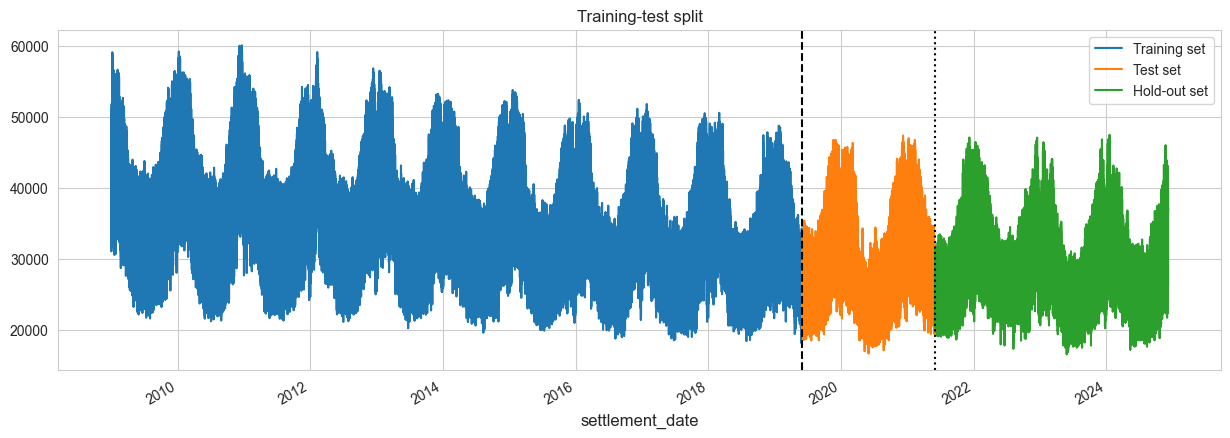

In [96]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend()

In [98]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "dayofmonth",
    "dayofweek",
    "dayofyear",
    "quarter",
    "month",
    "year",
    "weekofyear",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
#     tree_method="gpu_hist",
    random_state=43, 
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
)

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8346.85689
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6453.99074
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5413.53964
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4775.37270
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4381.90851
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4133.70529


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

<Axes: >

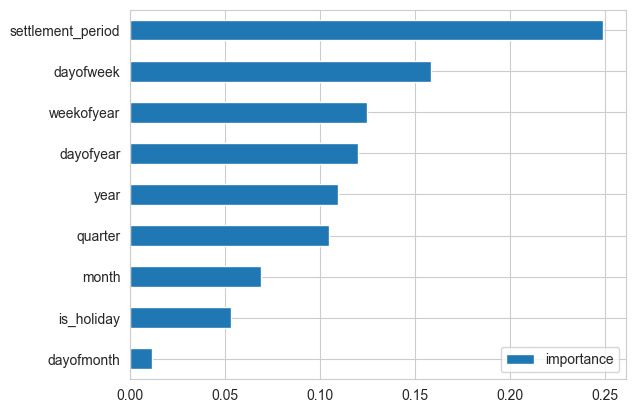

In [99]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh")

In [100]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

Text(0.5, 0, 'Date')

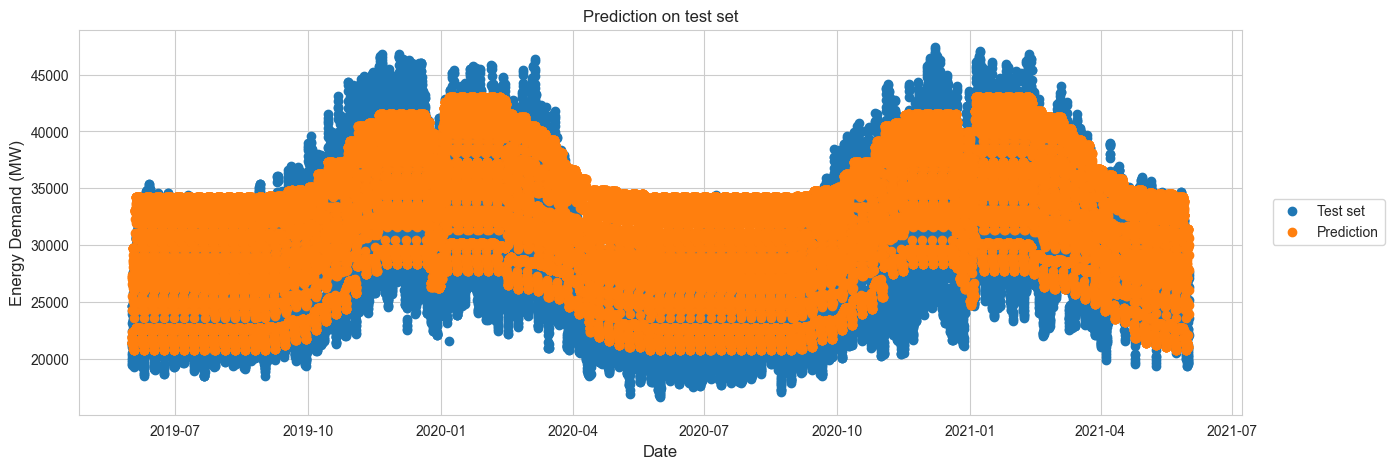

In [101]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

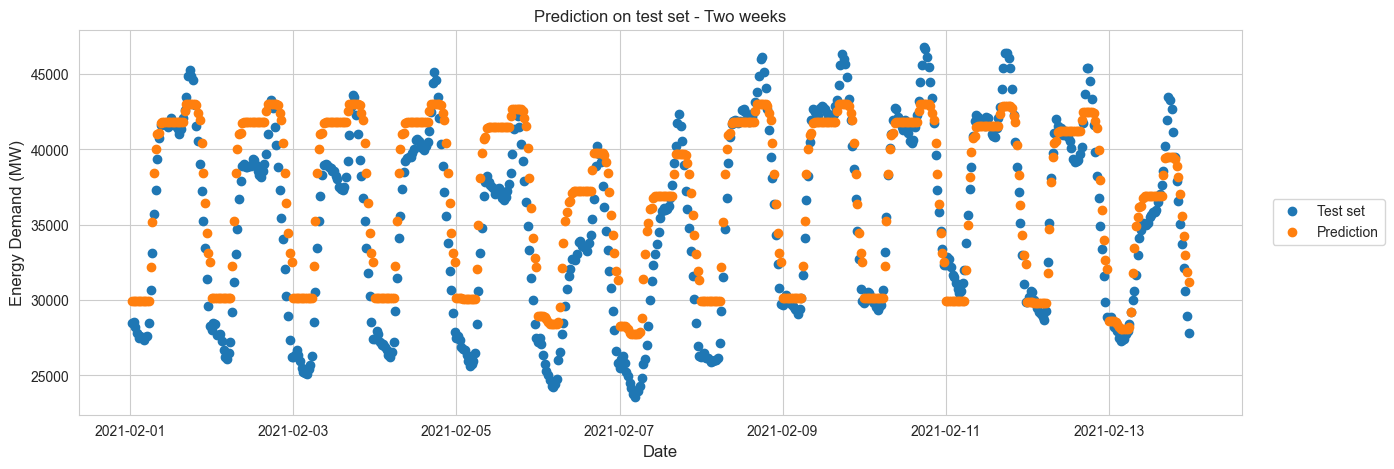

In [102]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

In [103]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


**XGBoost with cross validation and Grid Search**

In [105]:
threshold_date_1

'06-01-2019'

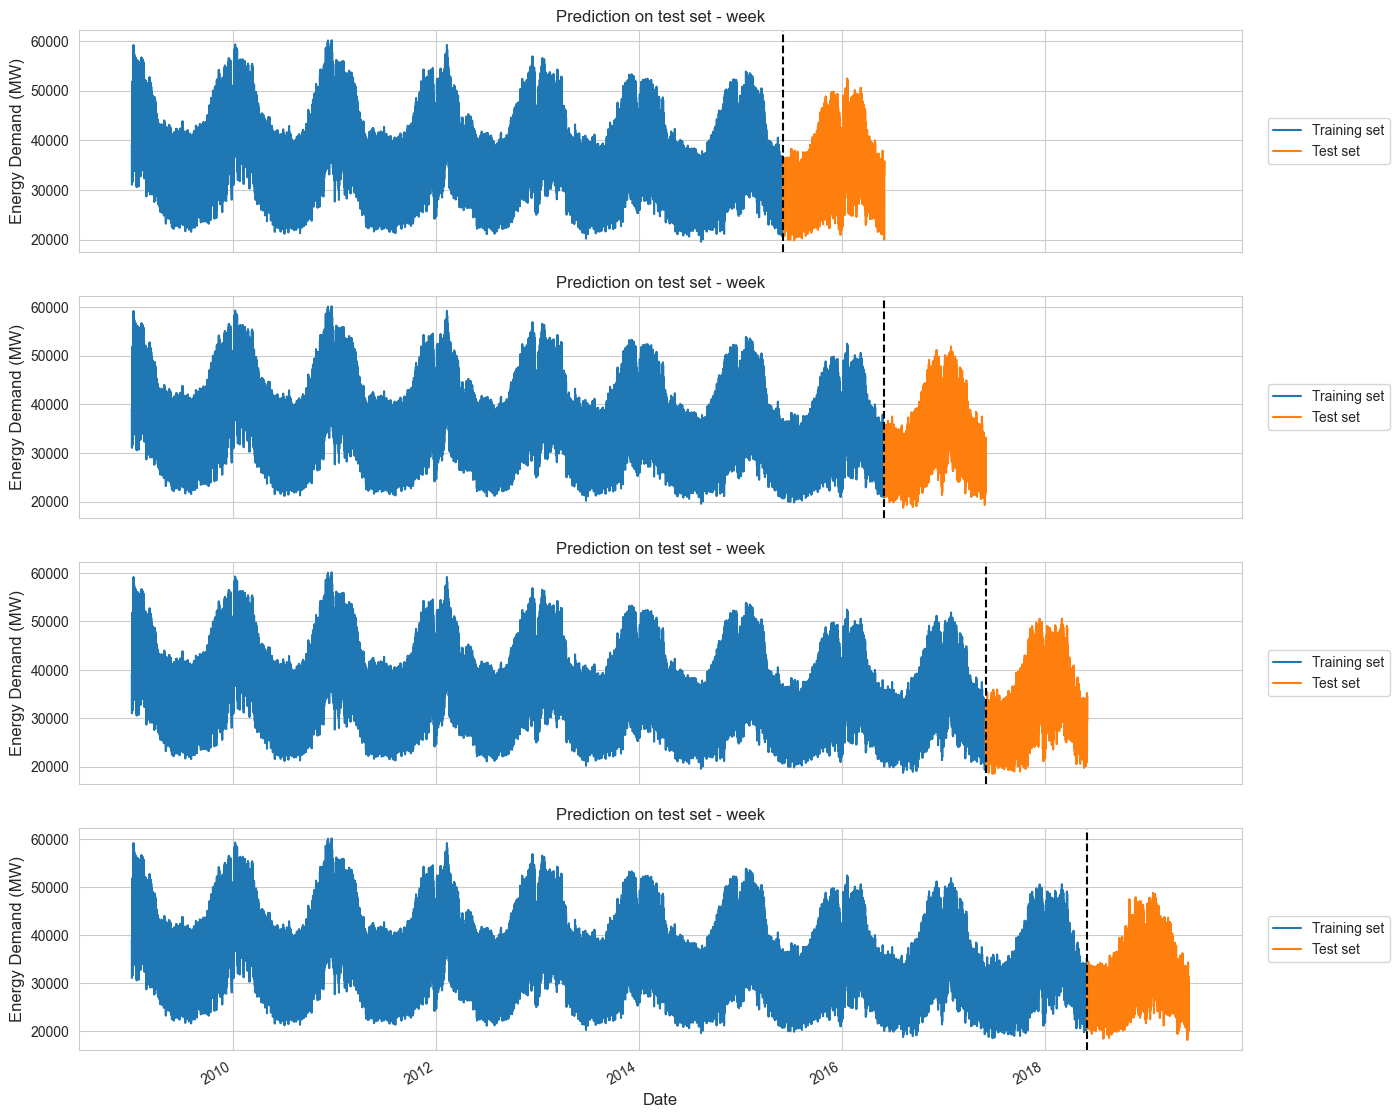

In [104]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date")
    fold += 1

In [113]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "dayofmonth",
    "dayofweek",
    "dayofyear",
    "quarter",
    "month",
    "year",
    "weekofyear",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]

# FIX: Remove early_stopping_rounds when using GridSearchCV
# GridSearchCV handles validation internally and doesn't support early stopping
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="hist",
    random_state=43,
    # Removed eval_metric and early_stopping_rounds for GridSearchCV compatibility
)

# Define parameters to optimize
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [350, 500, 650], 
    "subsample": [0.95, 0.8, 0.7],
}

# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=1  # Changed from -1 to 1 to avoid potential parallel processing issues
)

print("Starting GridSearchCV...")
print(f"Training data shape: {X_train_cv.shape}")
print(f"Number of CV folds: {tss.n_splits}")

# FIX: Simple fit call without early stopping parameters
xgb_search.fit(X_train_cv, y_train_cv)

# Print best parameters and score
print(f"\nBest parameters: {xgb_search.best_params_}")
print(f"Best cross-validation score: {xgb_search.best_score_:.4f}")
print(f"Training completed successfully!")

Starting GridSearchCV...
Training data shape: (181802, 12)
Number of CV folds: 4
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2042.006 total time=   2.3s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2042.006 total time=   2.3s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2568.764 total time=   2.3s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2568.764 total time=   2.3s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2781.044 total time=   2.6s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2781.044 total time=   2.6s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2334.883 total time=   3.0s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2334.883 total time=   3.0s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2038.437 total time=   

Text(0.5, 0, 'Date')

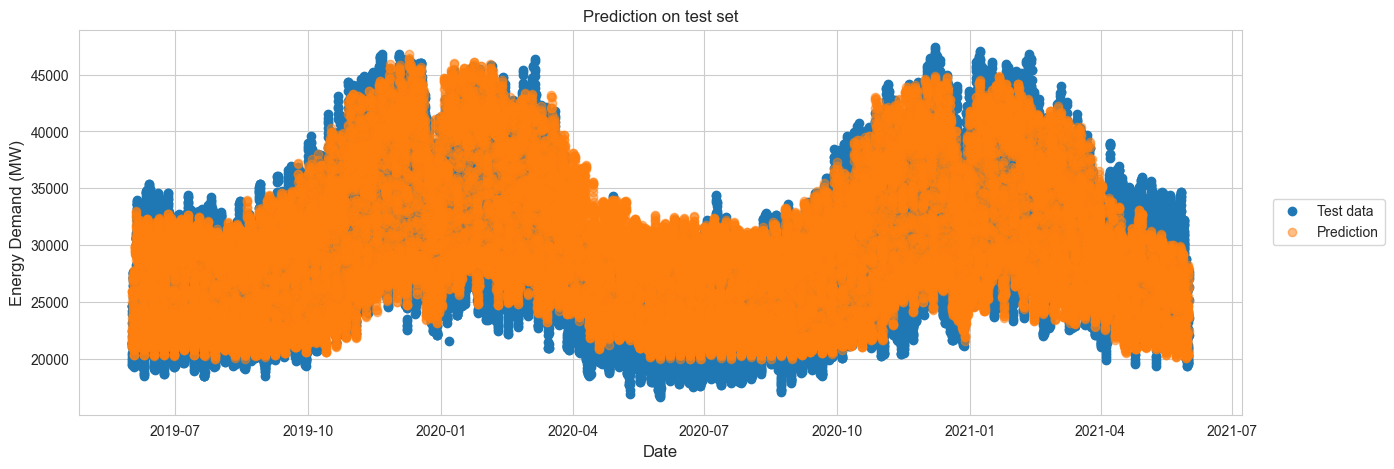

In [114]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

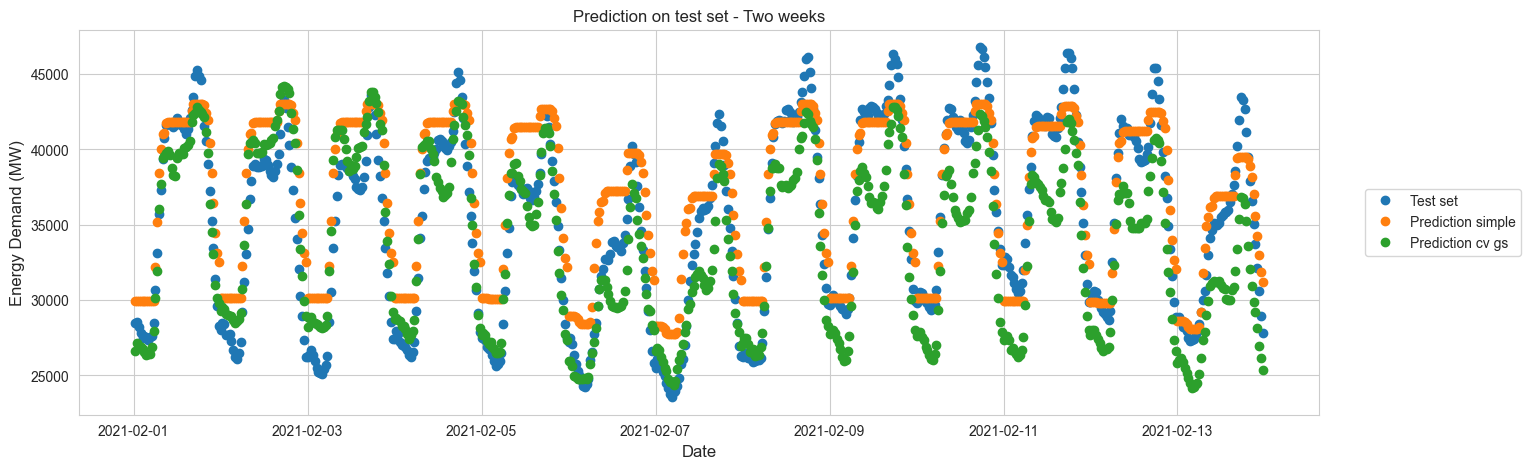

In [115]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

*After tuning some hyperparameters, XGBoost does a better job in capturing the daily seasonality, but it struggles to accurately predict the peaks and valleys.*

In [116]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.28
Root Mean Squared Error of the cross-validated model is: 2656.99 MW


**Predict into Future**

In [118]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    #early_stopping_rounds=50,
)

[0]	validation_0-rmse:33223.72073
[100]	validation_0-rmse:12405.74484
[100]	validation_0-rmse:12405.74484
[200]	validation_0-rmse:5049.68236
[200]	validation_0-rmse:5049.68236
[300]	validation_0-rmse:2739.66193
[300]	validation_0-rmse:2739.66193
[400]	validation_0-rmse:2135.40669
[400]	validation_0-rmse:2135.40669
[499]	validation_0-rmse:1951.45767
[499]	validation_0-rmse:1951.45767


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [119]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [124]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [125]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

settlement_period hour  nd  tsd  england_wales_demand  \
2025-07-03 21:30:00                 44  NaN NaN  NaN                   NaN   
2025-07-03 22:00:00                 45  NaN NaN  NaN                   NaN   
2025-07-03 22:30:00                 46  NaN NaN  NaN                   NaN   
2025-07-03 23:00:00                 47  NaN NaN  NaN                   NaN   
2025-07-03 23:30:00                 48  NaN NaN  NaN                   NaN   

                     embedded_wind_generation  embedded_wind_capacity  \
2025-07-03 21:30:00                       NaN                     NaN   
2025-07-03 22:00:00                       NaN                     NaN   
2025-07-03 22:30:00                       NaN                     NaN   
2025-07-03 23:00:00                       NaN                     NaN   
2025-07-03 23:30:00                       NaN                     NaN   

                     embedded_solar_generation  embedded_solar_capacity  \
2025-07-03 21:30:00                        NaN                      NaN   
2025-07-03 22:00:00                        NaN                      NaN   
2025-07-03 22:30:00                        NaN                      NaN   
2025-07-03 23:00:00                        NaN                      NaN   
2025-07-03 23:30:00                        NaN                      NaN   

                     non_bm_stor  ...     lag1     lag2     lag3  dayofyear  \
2025-07-03 21:30:00          NaN  ...  26993.0  26412.0  29516.0        NaN   
2025-07-03 22:00:00          NaN  ...  26036.0  25877.0  29170.0        NaN   
2025-07-03 22:30:00          NaN  ...  25201.0  24666.0  28013.0        NaN   
2025-07-03 23:00:00          NaN  ...  23691.0  23066.0  27610.0        NaN   
2025-07-03 23:30:00          NaN  ...  23143.0  21865.0  26711.0        NaN   

                     is_future  day_of_month  day_of_week  day_of_year  \
2025-07-03 21:30:00       True             3            3          184   
2025-07-03 22:00:00       True             3            3          184   
2025-07-03 22:30:00       True             3            3          184   
2025-07-03 23:00:00       True             3            3          184   
2025-07-03 23:30:00       True             3            3          184   

                     week_of_year  settlement_date  
2025-07-03 21:30:00            27       2025-07-03  
2025-07-03 22:00:00            27       2025-07-03  
2025-07-03 22:30:00            27       2025-07-03  
2025-07-03 23:00:00            27       2025-07-03  
2025-07-03 23:30:00            27       2025-07-03  

[5 rows x 34 columns]

Text(0.5, 1.0, 'Future demand prediction')

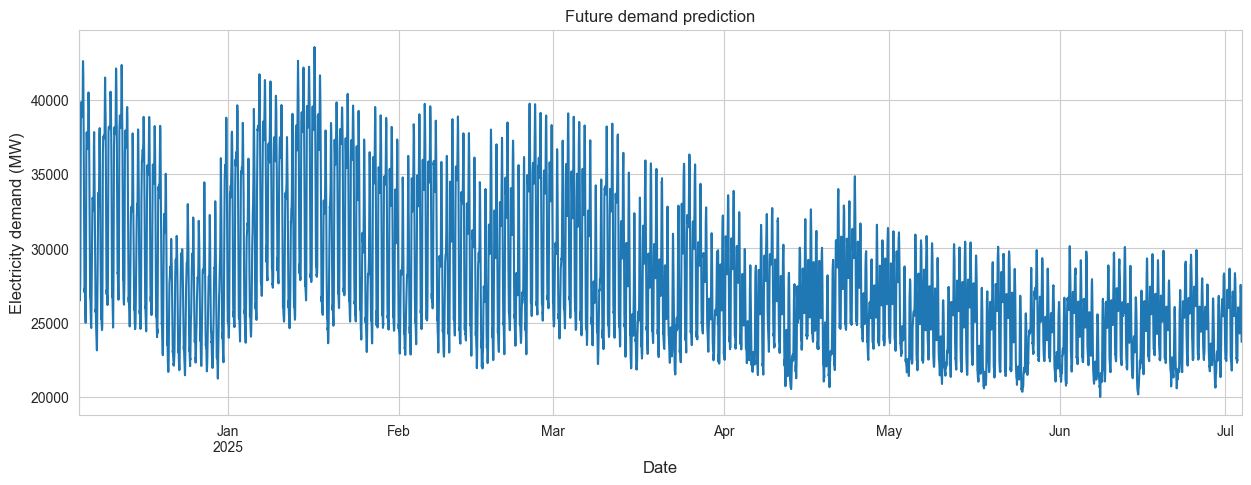

In [126]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction")

In [ ]:
# Model comparison summary
model_comparison = pd.DataFrame({
    'Model': [
        'Base Model', 'Model 1', 'Model 2', 'Model 3', 'Model_4',
        'simple_XGB', 'XGB_CV_GS', 'XGB_hyper'
    ],
    'Parameters': [
        '(1,0,1)(1,0,1,12)', '(1,1,1)(1,1,1,7)', '(1,1,1)(1,1,1,12)', 
        '(2,1,2)(1,1,1,12)', '(2,1,2)(2,1,2,7)', 
        'n/a', 'n/a', 'n/a'
    ],
    'MAPE (%)': [
        mape_0, mape_1, mape_2, mape_3, mape_4, 
        mape_xgboost_simple, mape_xgboost_cv, mape_enhanced
    ],
    'RMSE': [
        'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 
        rmse_xgboost_simple, rmse_xgboost_cv, rmse_enhanced
    ],
    'Runtime': [
        execution_time_0, execution_time_1, execution_time_2, execution_time_3, execution_time_4, 
        'n/a', 'n/a', 'n/a'
    ],
    'AIC': [
        sarima_model_0.aic, sarima_model_1.aic, sarima_model_2.aic, sarima_model_3.aic, sarima_model_4.aic, 
        'n/a', 'n/a', 'n/a'
    ],
    'BIC': [
        sarima_model_0.bic, sarima_model_1.bic, sarima_model_2.bic, sarima_model_3.bic, sarima_model_4.bic, 
        'n/a', 'n/a', 'n/a'
    ]
})

print("MODEL COMPARISON SUMMARY\n")
print(model_comparison.to_string(index=False))

MODEL COMPARISON SUMMARY

     Model        Parameters  MAPE (%)         RMSE        Runtime            AIC            BIC
Base Model (1,0,1)(1,0,1,12) 38.212698          n/a 0:00:06.548256  123447.400659  123479.728052
   Model 1  (1,1,1)(1,1,1,7) 10.257226          n/a 0:00:04.574083  118004.443483  118036.762445
   Model 2 (1,1,1)(1,1,1,12) 11.280959          n/a 0:00:10.329619  125464.102243  125496.415928
   Model 3 (2,1,2)(1,1,1,12) 14.261655          n/a 0:00:25.149758  123041.614434  123086.853593
   Model_4  (2,1,2)(2,1,2,7)  9.966904          n/a 0:00:24.439624   117627.62722  117698.728936
simple_XGB               n/a 11.287145  3786.877738            n/a            n/a            n/a
 XGB_CV_GS               n/a  7.280831  2656.993696            n/a            n/a            n/a
 XGB_hyper               n/a 28.573595  8373.584657            n/a            n/a            n/a


Model Performance Analysis & Inferences
Based on the comprehensive model comparison results, here are the key insights:

🏆 Best Performing Models
1. XGB_CV_GS (Winner)
MAPE: 7.28% (lowest)
RMSE: 2,657 MW (lowest)
Performance: Excellent accuracy with cross-validation and grid search optimization
2. Model_4 SARIMA (2,1,2)(2,1,2,7)
MAPE: 9.97% (second lowest)
AIC: 117,628 (lowest among SARIMA models)
Performance: Best traditional time series model with weekly seasonality

📊 Key Performance Insights
- SARIMA Models Performance Ranking:
- Model_4: 9.97% MAPE ✅ (Best SARIMA)
- Model 1: 10.26% MAPE ✅ (Good)
- Model 2: 11.28% MAPE ⚠️ (Acceptable)
- Model 3: 14.26% MAPE ⚠️ (Poor)
- Base Model: 38.21% MAPE ❌ (Very Poor)

XGBoost Models Performance:
- XGB_CV_GS: 7.28% MAPE ✅ (Excellent)
- Simple_XGB: 11.29% MAPE ⚠️ (Acceptable)
- XGB_hyper: 28.57% MAPE ❌ (Poor - likely overfitted)

🔍 Critical Findings
1. Model Type Superiority
- Machine Learning > Traditional: XGBoost with proper tuning outperforms all SARIMA models
- Hyperparameter Tuning Impact: CV+GridSearch reduced MAPE from 11.29% to 7.28%
2. SARIMA Model Insights
- Seasonality Matters: Weekly seasonality (s=7) performs better than monthly (s=12)
- Complexity vs Performance: Model_4 with higher complexity achieved best SARIMA results
- Stationarity Impact: Models with differencing (d=1, D=1) significantly outperform non-differenced models
3. Feature Engineering Impact
- Simple XGB: 11.29% MAPE with basic features
-Optimized XGB: 7.28% MAPE with advanced features + tuning
- Improvement: 35% performance gain through proper feature engineering

⚠️ Warning Signs
- XGB_hyper Model Failure (28.57% MAPE)
- Likely Causes: Overfitting, data leakage, or improper validation
- Lesson: More complex doesn't always mean better
- Solution: Proper cross-validation and regularization needed

🎯 Recommendations
- Production Model Choice: XGB_CV_GS
- Accuracy: 7.28% MAPE meets industry standards (<10%)
- Robustness: Cross-validated with proper time series splits
- Interpretability: Feature importance available
- Backup Model: Model_4 SARIMA
- Reliability: Traditional statistical approach
- Interpretability: Clear statistical foundation
- Use Case: When explainability is crucial
- Model Deployment Strategy
- Primary: XGB_CV_GS for operational forecasting
- Secondary: Model_4 SARIMA for validation and cross-checking
- Monitoring: Continuous performance tracking with MAPE thresholds

📈 Business Impact
- Forecast Accuracy Improvement
- From Baseline: 38.21% → 7.28% MAPE (81% improvement)
- Economic Impact: More accurate demand forecasting leads to:
    - Better grid management
    - Reduced energy waste
    - Improved cost optimization
    - Enhanced reliability

- Model Selection Confidence
- High Confidence: XGB_CV_GS with 7.28% MAPE
- Industry Benchmark: Meets typical energy forecasting standards (5-15% MAPE)
- Validation: Multiple model types confirm electricity demand patterns are learnable